# Generation of hyperspectral samples using Wasserstein-GANs

Wasserstein-GANs are Generative Adversarial Models that can be used to generate synthetic data that approximates a specific input distribution of real data.

In this notebook, we show how to use such a tool to generate *ex nihilo* synthetic hyperspectral samples.

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.utils.data
from scipy.io import loadmat
from skimage import io
from PIL import Image


We load the Pavia University dataset. The `.mat` files are available on [this website](http://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes).

In [3]:
img = loadmat('./PaviaU.mat')['paviaU']
gt = loadmat('./PaviaU_gt.mat')['paviaU_gt']


In [4]:
img = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_hsi_radiance.tif')
img_rgb = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_rgb.tif')
# gt = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_labels.tif')
gt = io.imread('./gt_new.tif')
gt = gt.astype(int)

img = np.rot90(img,1,(0,2))
img_rgb =  np.rot90(img_rgb,1,(0,1))


img = img[:3974,:1972,:]
img_rgb = img_rgb[:3974,:1972,:]
gt = gt[:3974,:1972]

print(np.shape(img))
print(np.shape(img_rgb))
print(gt.shape)

# gt =  np.rot90(gt,1,(0,1))

# classes = np.array([
#     [153 ,  0 ,  0], #unspecified
#     [  0 ,  0 ,255], #roads
#     [  0, 255 ,  0], #vegetation
#     [  0 ,255 ,255], #water
#     [255 ,  0 ,0],#buidings 
#     [255 ,127 , 80]#cars
# ])
# # d = {
# #     repr([153 ,  0 ,  0]): 0,
# #     repr([0 ,  0 ,255]): 1,
# #     repr([ 0, 255 ,  0]): 2,
# #     repr([ 0 ,255 ,255]): 3,
# #     repr([255 ,  0 ,0]): 4,
# #     repr([255 ,127 , 80]): 5,
# # }
# gt_temp = np.zeros((gt.shape[0],gt.shape[1]))

# for i in range(gt.shape[0]):
#     for j in range(gt.shape[1]):
#         val = gt[i][j]
#         for id in range(len(classes)):
#             if np.array_equal(val, classes[id]):
#                 gt_temp[i][j] = id
        
        
# gt = gt_temp        
# gt_new = Image.fromarray(gt)
# gt_new.save('gt_new.tif')



(3974, 1972, 51)
(3974, 1972, 3)
(3974, 1972)


In [5]:
mask = np.random.randint(0, 100, gt.shape) < 5
train_gt = np.copy(gt)

train_gt[np.nonzero(~mask)] = 0
test_gt = np.copy(gt)
test_gt[train_gt > 0] = 0
# (51, 1973, 3975)
# (1973, 3975, 3)
# (1973, 3975, 3)
# (610, 340, 103)
# (610, 340)
# (610, 340)
rgb = img_rgb
# rgb = img[:,:,(55,41,12)]
rgb = (255 * (rgb.astype(np.float32) - rgb.min())/(rgb.max() - rgb.min())).astype(np.uint8)
print(np.shape(img))
print(np.shape(gt))
print(np.shape(train_gt))
print(np.shape(rgb))

(3974, 1972, 51)
(3974, 1972)
(3974, 1972)
(3974, 1972, 3)


The ground truth is shown below. We sample 10% from the pixels as training samples.

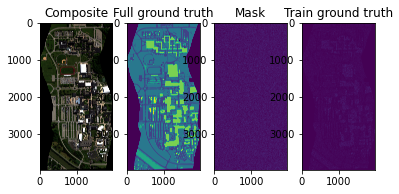

In [6]:
fig = plt.figure()
fig.add_subplot(141)
plt.imshow(rgb)
plt.title("Composite")
fig.add_subplot(142)
plt.imshow(gt)
plt.title("Full ground truth")
fig.add_subplot(143)
plt.imshow(mask)

plt.title("Mask")
fig.add_subplot(144)
plt.imshow(train_gt)
plt.title("Train ground truth")
plt.show()

We define a `HyperX` class to hold the dataset. Note that the label is encoded as a one-hot vector.

In [7]:
from skimage import morphology

class HyperX(torch.utils.data.Dataset):
    
    def __init__(self, data, ground_truth, semi=False):
        super(HyperX, self).__init__()
        # print('init dataloader')
        # Normalize the data in [0,1]
        data = (data - data.min()) / (data.max() - data.min())
        self.data = data
        self.gt = ground_truth
        self.n_classes = len(np.unique(ground_truth))
        if semi:
            # Semi-supervision, include neighbours at 50px
            x_pos, y_pos = np.nonzero(morphology.dilation(ground_truth > 0, morphology.disk(50)))
        else:
            x_pos, y_pos = np.nonzero(ground_truth)
        self.indices = [idx for idx in zip(x_pos, y_pos)]
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, i):
        x, y = self.indices[i]
        data = self.data[x,y]
        # Get the label in one-hot encoded style
        # print(self.n_classes,x, y,np.eye(self.n_classes),self.gt[x, y])
        label = np.asarray(np.eye(self.n_classes)[self.gt[x, y]], dtype='int64')
        return torch.from_numpy(data), torch.from_numpy(label)

In [8]:
import os
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# Basic generator that maps: noise + condition -> fake samples
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # LeakyReLU is preferred to keep gradients flowing even for negative activations
        self.generator = torch.nn.Sequential(
            torch.nn.Linear(z_dim + c_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, X_dim),
            torch.nn.Sigmoid() # smooth [0,1] outputs
        )
        self.apply(weight_init)

    def forward(self, z, c):
        # Concatenate the noise and condition
        inputs = torch.cat([z, c], 1)
        return self.generator(inputs)

# Basic fully connected discriminator: sample -> -infty -- fake - 0 - real -- +infty
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(X_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, 1)
        )
        
        self.apply(weight_init)

    def forward(self, X):
        return self.discriminator(X)

# Basic fully connected classifier: sample -> class
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(X_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, c_dim)
        )
        
        self.apply(weight_init)

    def forward(self, X):
        return self.discriminator(X)

In [9]:
mb_size = 256 # Batch size
z_dim = 30   # Noise dimension
X_dim = img.shape[-1] # Number of bands
print(X_dim)
h_dim = 512  # Hidden layer size
d_step = 5   # Number of discriminator training steps for each generator training step
lr = 5e-5    # Learning rate
c_weight = 0.2 # Auxiliary classifier weight
flip_percentage = 0.0 # Proportion of label flipping
mixup_alpha = 0.1 # Mixup
semi_supervised = True # semi-supervision (set to True to include unlabeled samples)

# Build the dataset and data loader
data_loader = torch.utils.data.DataLoader(
    HyperX(img, train_gt if semi_supervised else gt), batch_size=mb_size, shuffle=True)
# c_dim = condition vector size
c_dim = data_loader.dataset.n_classes

# Ignore the class 0
class_weights = torch.ones((c_dim))
class_weights[0] = 0.
class_weights = class_weights.cuda()

51


In [10]:
# Initialize weights using the He et al. (2015) policy.
def weight_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.Conv3d, nn.ConvTranspose3d)):
        torch.nn.init.kaiming_normal_(m.weight.data)

# Spherical interpolation between two vectors on the unit hypersphere
# See : https://github.com/soumith/dcgan.torch/issues/14
def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return (1.0-val) * low + val * high # L'Hopital's rule/LERP
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

def lerp(val, low, high):
    return (1.0-val) * low + val * high # L'Hopital's rule/LERP

# Gradient penalty from the Improved WGAN training
# From : https://github.com/EmilienDupont/wgan-gp
# Use penalty_weight set at 10, as suggested in the paper
def calc_gradient_penalty(netD, real_data, generated_data, penalty_weight=10):
        batch_size = real_data.size()[0]

        alpha = torch.rand(batch_size, 1) if real_data.dim() == 2 else torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        alpha = alpha.cuda()
        
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        #interpolated = Variable(interpolated, requires_grad=True)
        interpolated.requires_grad_()
        interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = netD(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return penalty_weight * ((gradients_norm - 1) ** 2).mean()
    
def reset_grad(*nets):
    for net in nets:
        net.zero_grad()
        
def plot_mean_std(samples):
    mean_spectrum = np.mean(samples, axis=0)
    std_spectrum = np.std(samples, axis=0)
    plt.plot(mean_spectrum - std_spectrum, linestyle='dotted', label='-std')
    plt.plot(mean_spectrum, label='mean')
    plt.plot(mean_spectrum + std_spectrum, linestyle='dotted', label='+std')

  0%|          | 0/100000 [00:00<?, ?it/s]c:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iter-0; D_loss: -1.967659592628479; G_loss: 2.6461219787597656; C_loss: 1.2297170162200928


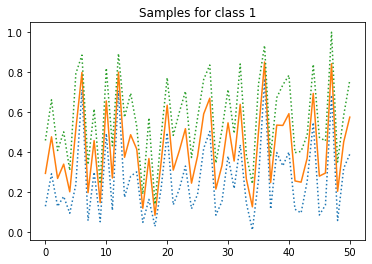

  1%|          | 1000/100000 [03:03<5:11:12,  5.30it/s]

Iter-1000; D_loss: -0.08147189766168594; G_loss: -0.29647257924079895; C_loss: 0.1329221874475479


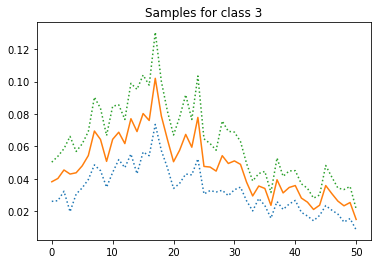

  2%|▏         | 2000/100000 [06:04<4:53:26,  5.57it/s]

Iter-2000; D_loss: -0.07727858424186707; G_loss: -0.29115280508995056; C_loss: 0.033143654465675354


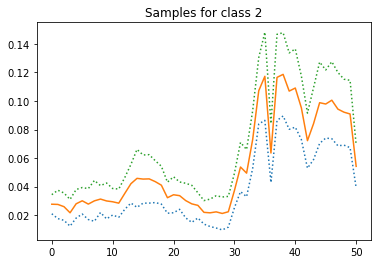

  3%|▎         | 3000/100000 [09:05<4:45:14,  5.67it/s]

Iter-3000; D_loss: -0.0499352291226387; G_loss: -0.3064982295036316; C_loss: 0.03963629901409149


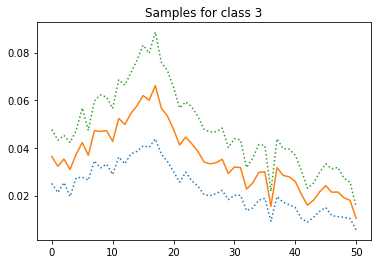

  4%|▍         | 4000/100000 [12:06<4:48:09,  5.55it/s]

Iter-4000; D_loss: -0.02961164340376854; G_loss: -0.3160434365272522; C_loss: 0.03776044398546219


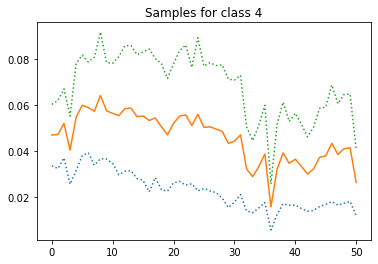

  5%|▌         | 5000/100000 [15:07<4:45:17,  5.55it/s]

Iter-5000; D_loss: -0.04218287393450737; G_loss: -0.23203331232070923; C_loss: 0.030261589214205742


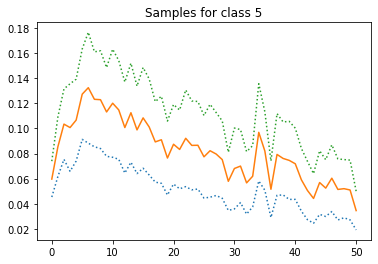

  6%|▌         | 6000/100000 [18:07<5:00:19,  5.22it/s]

Iter-6000; D_loss: -0.02217751182615757; G_loss: -0.1593843400478363; C_loss: 0.04026230424642563


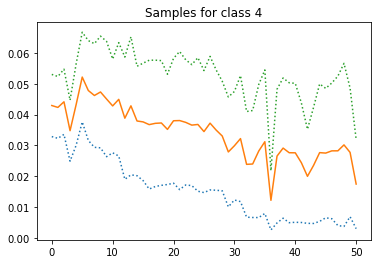

  7%|▋         | 7000/100000 [21:06<4:42:32,  5.49it/s]

Iter-7000; D_loss: -0.02167361043393612; G_loss: -0.18150880932807922; C_loss: 0.02867734618484974


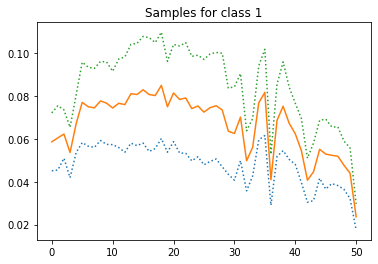

  8%|▊         | 8000/100000 [24:05<4:37:33,  5.52it/s]

Iter-8000; D_loss: -0.015561962500214577; G_loss: -0.17234720289707184; C_loss: 0.025913788005709648


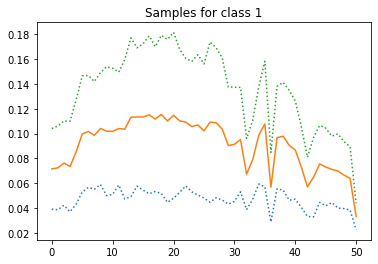

  9%|▉         | 9000/100000 [26:47<4:00:17,  6.31it/s]

Iter-9000; D_loss: -0.015743475407361984; G_loss: -0.17241114377975464; C_loss: 0.038191210478544235


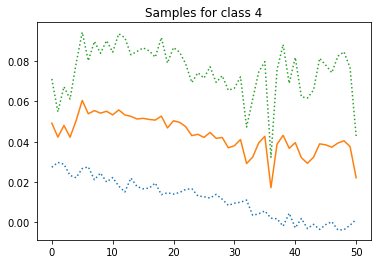

 10%|█         | 10000/100000 [29:22<4:12:50,  5.93it/s]

Iter-10000; D_loss: -0.010836446657776833; G_loss: -0.16099414229393005; C_loss: 0.03389401361346245


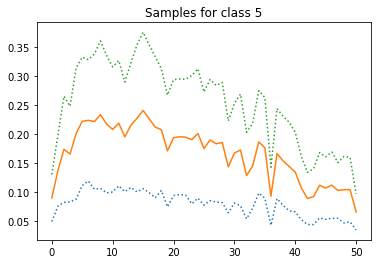

 11%|█         | 11000/100000 [31:58<3:36:43,  6.84it/s]

Iter-11000; D_loss: -0.004629380535334349; G_loss: -0.1527215987443924; C_loss: 0.03222915157675743


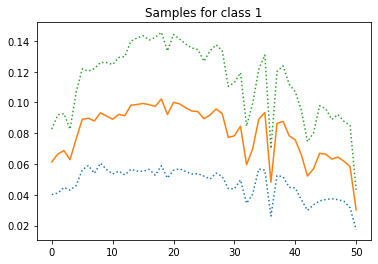

 12%|█▏        | 12000/100000 [34:33<3:56:14,  6.21it/s]

Iter-12000; D_loss: -0.007508487440645695; G_loss: -0.1728435456752777; C_loss: 0.029530543833971024


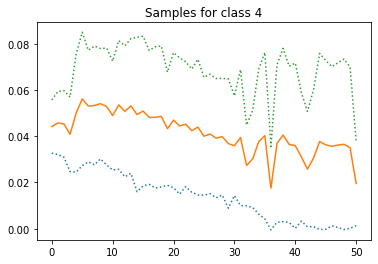

 13%|█▎        | 13000/100000 [37:09<3:34:49,  6.75it/s]

Iter-13000; D_loss: -0.006523622199892998; G_loss: -0.1758960336446762; C_loss: 0.03522604703903198


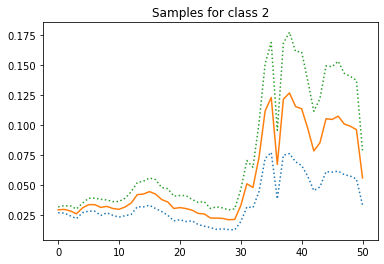

 14%|█▍        | 14000/100000 [40:08<4:31:55,  5.27it/s]

Iter-14000; D_loss: -0.007485246751457453; G_loss: -0.19080311059951782; C_loss: 0.030598996207118034


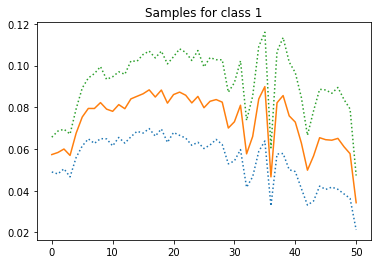

 15%|█▌        | 15000/100000 [43:05<4:18:19,  5.48it/s]

Iter-15000; D_loss: -0.005229055881500244; G_loss: -0.19676800072193146; C_loss: 0.0326555036008358


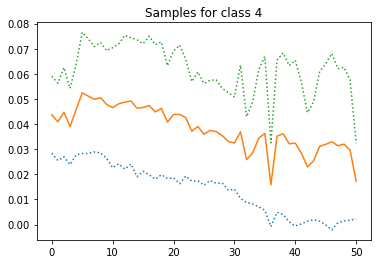

 16%|█▌        | 16000/100000 [46:02<4:02:27,  5.77it/s]

Iter-16000; D_loss: -0.0025801733136177063; G_loss: -0.2113642394542694; C_loss: 0.032562751322984695


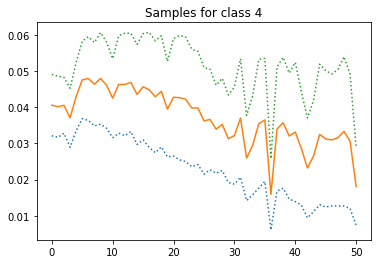

 17%|█▋        | 17000/100000 [49:00<4:02:27,  5.71it/s]

Iter-17000; D_loss: -0.006202524062246084; G_loss: -0.20391032099723816; C_loss: 0.022661253809928894


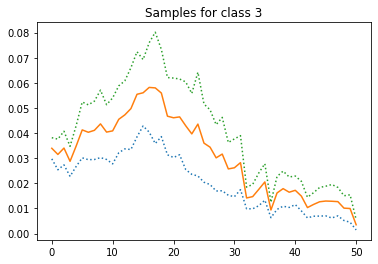

 18%|█▊        | 18000/100000 [51:57<3:57:02,  5.77it/s]

Iter-18000; D_loss: -0.008217600174248219; G_loss: -0.2002246379852295; C_loss: 0.02570655755698681


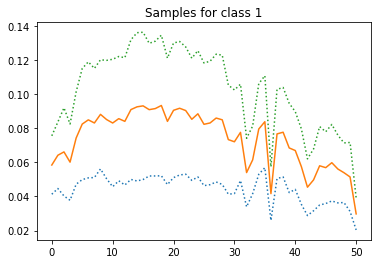

 19%|█▉        | 19000/100000 [54:53<3:59:32,  5.64it/s]

Iter-19000; D_loss: -0.009765399619936943; G_loss: -0.1785259246826172; C_loss: 0.03602346405386925


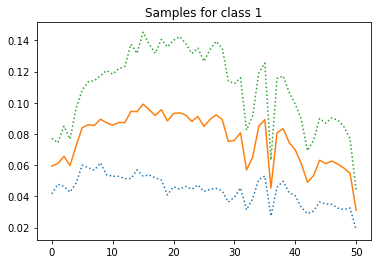

 20%|██        | 20000/100000 [57:49<3:47:04,  5.87it/s]

Iter-20000; D_loss: -0.008106815628707409; G_loss: -0.18265317380428314; C_loss: 0.025260744616389275


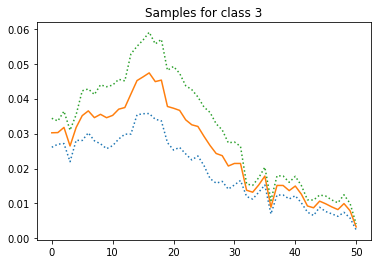

 21%|██        | 21000/100000 [1:00:46<3:53:46,  5.63it/s]

Iter-21000; D_loss: -0.004633019212633371; G_loss: -0.18046081066131592; C_loss: 0.024513080716133118


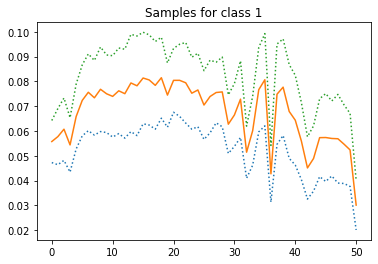

 22%|██▏       | 22000/100000 [1:03:44<3:57:41,  5.47it/s]

Iter-22000; D_loss: -0.017865503206849098; G_loss: -0.17874759435653687; C_loss: 0.03261963278055191


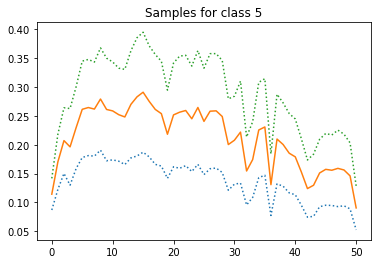

 23%|██▎       | 23000/100000 [1:06:18<3:27:58,  6.17it/s]

Iter-23000; D_loss: -0.004404280334711075; G_loss: -0.17033325135707855; C_loss: 0.019836463034152985


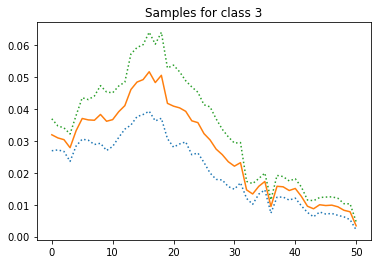

 24%|██▍       | 24000/100000 [1:08:51<3:11:11,  6.63it/s]

Iter-24000; D_loss: -0.0002967575564980507; G_loss: -0.16777996718883514; C_loss: 0.02713361568748951


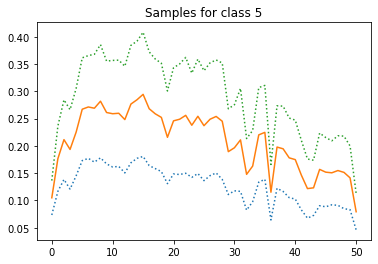

 25%|██▌       | 25000/100000 [1:11:23<3:09:33,  6.59it/s]

Iter-25000; D_loss: -0.003592329565435648; G_loss: -0.18094336986541748; C_loss: 0.023466074839234352


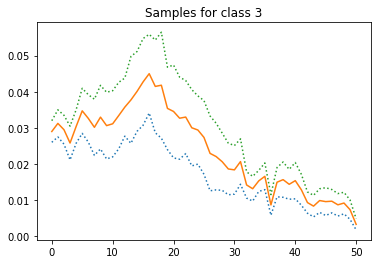

 26%|██▌       | 26000/100000 [1:13:55<3:07:54,  6.56it/s]

Iter-26000; D_loss: -0.0032119620591402054; G_loss: -0.175077885389328; C_loss: 0.0239262655377388


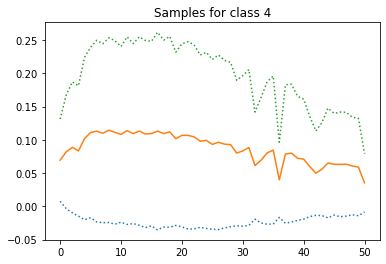

 27%|██▋       | 27000/100000 [1:16:27<3:00:07,  6.75it/s]

Iter-27000; D_loss: -0.006934799253940582; G_loss: -0.1792132705450058; C_loss: 0.02079593390226364


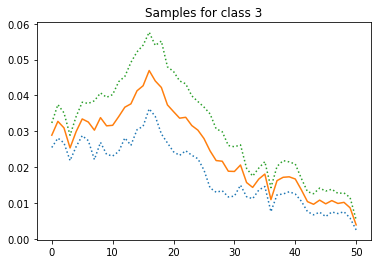

 28%|██▊       | 28000/100000 [1:19:00<2:56:44,  6.79it/s]

Iter-28000; D_loss: -0.010897583328187466; G_loss: -0.1745184063911438; C_loss: 0.023448225110769272


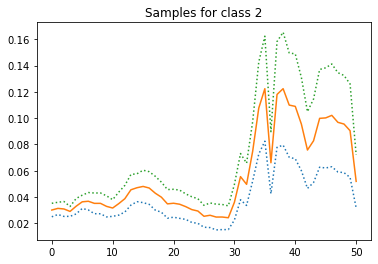

 29%|██▉       | 29000/100000 [1:21:33<2:58:15,  6.64it/s]

Iter-29000; D_loss: -0.01633712649345398; G_loss: -0.16447225213050842; C_loss: 0.026409106329083443


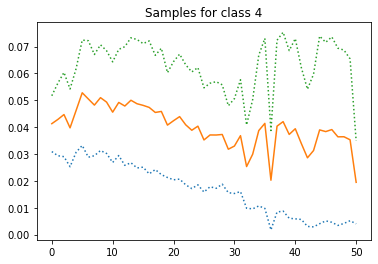

 30%|███       | 30000/100000 [1:24:06<3:17:29,  5.91it/s]

Iter-30000; D_loss: -0.0005975855747237802; G_loss: -0.15856751799583435; C_loss: 0.024858230724930763


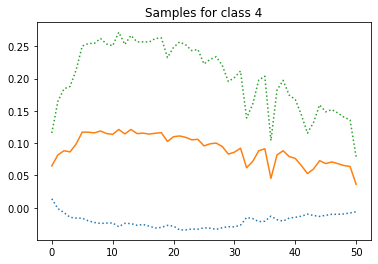

 31%|███       | 31000/100000 [1:26:37<2:44:28,  6.99it/s]

Iter-31000; D_loss: -0.003579063806682825; G_loss: -0.16138997673988342; C_loss: 0.023361453786492348


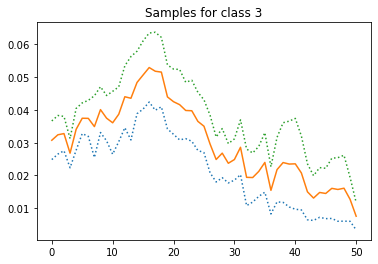

 32%|███▏      | 32000/100000 [1:29:10<3:05:11,  6.12it/s]

Iter-32000; D_loss: -0.016744300723075867; G_loss: -0.15319958329200745; C_loss: 0.026435010135173798


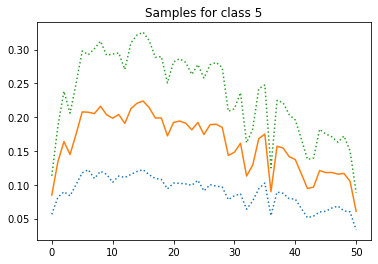

 33%|███▎      | 33000/100000 [1:31:42<2:39:52,  6.98it/s]

Iter-33000; D_loss: -0.0006756547372788191; G_loss: -0.1655789613723755; C_loss: 0.02776874415576458


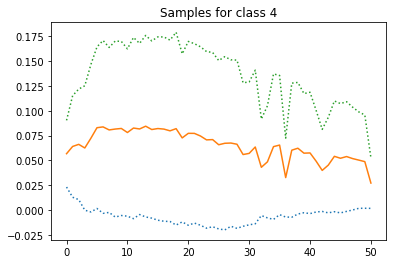

 34%|███▍      | 34000/100000 [1:34:15<2:38:19,  6.95it/s]

Iter-34000; D_loss: 0.0006787264719605446; G_loss: -0.1547023057937622; C_loss: 0.01679231785237789


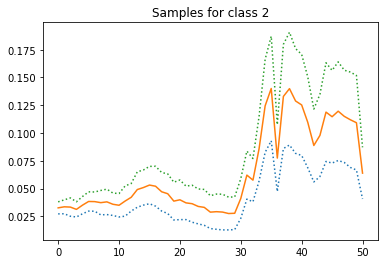

 35%|███▌      | 35000/100000 [1:36:48<2:55:19,  6.18it/s]

Iter-35000; D_loss: -0.004136892966926098; G_loss: -0.15126194059848785; C_loss: 0.020634368062019348


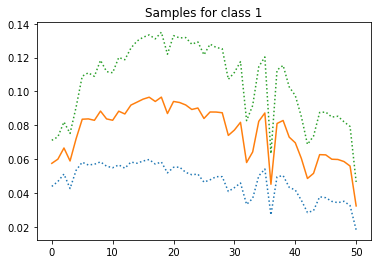

 36%|███▌      | 36000/100000 [1:39:22<2:32:48,  6.98it/s]

Iter-36000; D_loss: -0.0013861744664609432; G_loss: -0.15182402729988098; C_loss: 0.017163818702101707


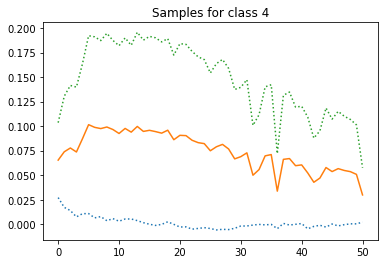

 37%|███▋      | 37000/100000 [1:41:54<2:41:17,  6.51it/s]

Iter-37000; D_loss: -0.014714274555444717; G_loss: -0.1363028883934021; C_loss: 0.021119534969329834


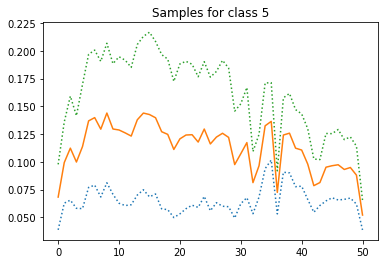

 38%|███▊      | 38000/100000 [1:44:27<2:46:21,  6.21it/s]

Iter-38000; D_loss: -0.01075046043843031; G_loss: -0.1374029517173767; C_loss: 0.024657515808939934


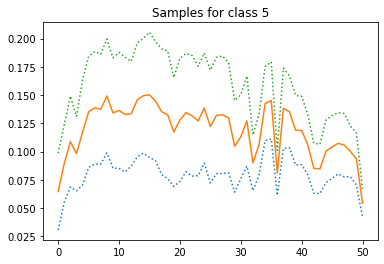

 39%|███▉      | 39000/100000 [1:47:01<2:40:03,  6.35it/s]

Iter-39000; D_loss: -0.0022375728003680706; G_loss: -0.13894470036029816; C_loss: 0.012883552350103855


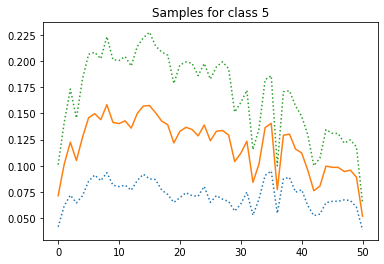

 40%|████      | 40000/100000 [1:49:35<2:32:04,  6.58it/s]

Iter-40000; D_loss: -0.004800394177436829; G_loss: -0.1365644633769989; C_loss: 0.022062446922063828


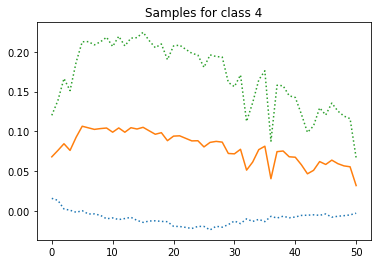

 41%|████      | 41000/100000 [1:52:09<2:29:10,  6.59it/s]

Iter-41000; D_loss: 0.003286475781351328; G_loss: -0.1225525438785553; C_loss: 0.01967155747115612


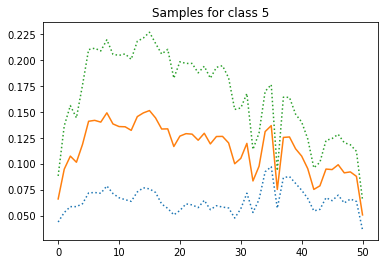

 42%|████▏     | 42000/100000 [1:54:43<2:25:41,  6.63it/s]

Iter-42000; D_loss: -0.0014569805935025215; G_loss: -0.12085496634244919; C_loss: 0.020521575585007668


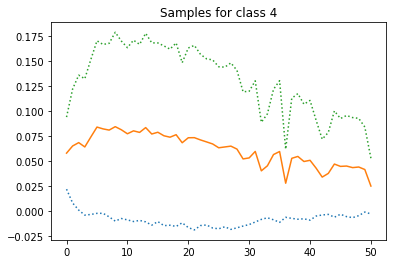

 43%|████▎     | 43000/100000 [1:57:16<2:32:51,  6.21it/s]

Iter-43000; D_loss: -0.004469491541385651; G_loss: -0.13631674647331238; C_loss: 0.018466906622052193


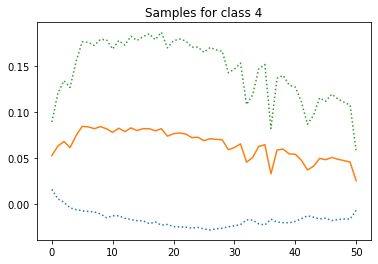

 44%|████▍     | 44000/100000 [1:59:50<2:27:26,  6.33it/s]

Iter-44000; D_loss: -0.004840890411287546; G_loss: -0.1312648057937622; C_loss: 0.01487991027534008


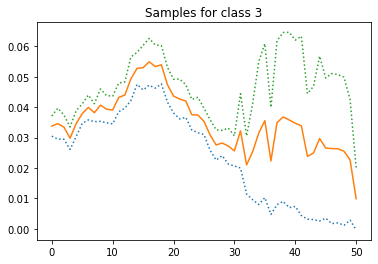

 45%|████▌     | 45000/100000 [2:02:25<2:22:58,  6.41it/s]

Iter-45000; D_loss: -0.002357854275032878; G_loss: -0.11759817600250244; C_loss: 0.01838682033121586


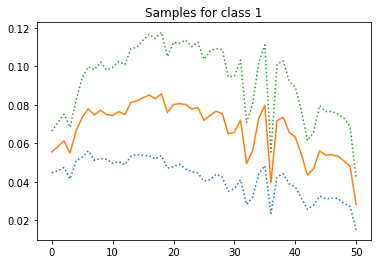

 46%|████▌     | 46000/100000 [2:05:01<2:17:36,  6.54it/s]

Iter-46000; D_loss: -0.00690575921908021; G_loss: -0.12128497660160065; C_loss: 0.02180112525820732


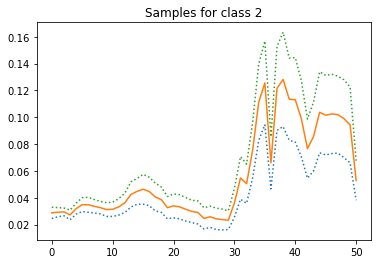

 47%|████▋     | 47000/100000 [2:07:51<2:18:17,  6.39it/s]

Iter-47000; D_loss: -0.0053379833698272705; G_loss: -0.11867446452379227; C_loss: 0.01989799551665783


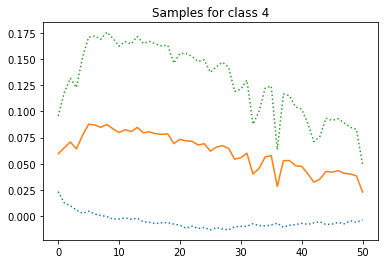

 48%|████▊     | 48000/100000 [2:10:23<2:10:03,  6.66it/s]

Iter-48000; D_loss: -0.0020871309097856283; G_loss: -0.12940138578414917; C_loss: 0.016460243612527847


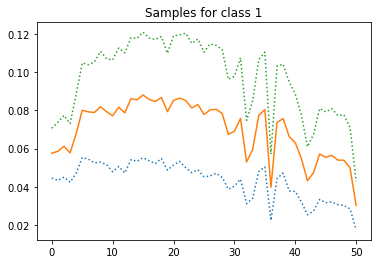

 49%|████▉     | 49000/100000 [2:12:55<2:04:44,  6.81it/s]

Iter-49000; D_loss: -0.002735667861998081; G_loss: -0.11602714657783508; C_loss: 0.022790925577282906


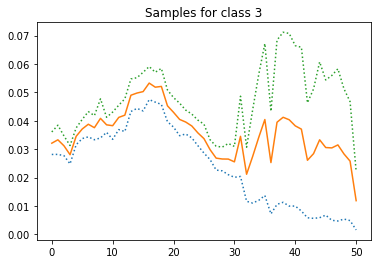

 50%|█████     | 50000/100000 [2:15:28<2:15:20,  6.16it/s]

Iter-50000; D_loss: -0.004715689457952976; G_loss: -0.11568686366081238; C_loss: 0.015090330503880978


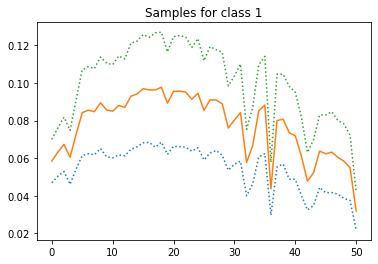

 51%|█████     | 51000/100000 [2:18:02<2:09:04,  6.33it/s]

Iter-51000; D_loss: -0.004927779082208872; G_loss: -0.11480088531970978; C_loss: 0.018978815525770187


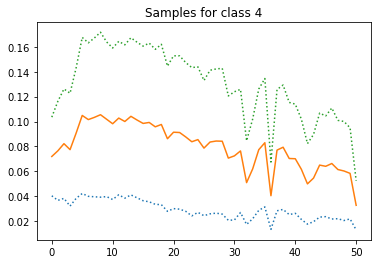

 52%|█████▏    | 52000/100000 [2:20:35<2:05:32,  6.37it/s]

Iter-52000; D_loss: 0.00034606538247317076; G_loss: -0.11543707549571991; C_loss: 0.016599375754594803


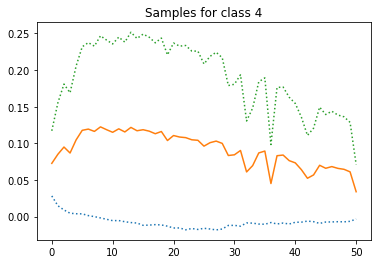

 53%|█████▎    | 53000/100000 [2:23:09<1:55:54,  6.76it/s]

Iter-53000; D_loss: -0.002780467737466097; G_loss: -0.11404048651456833; C_loss: 0.016321921721100807


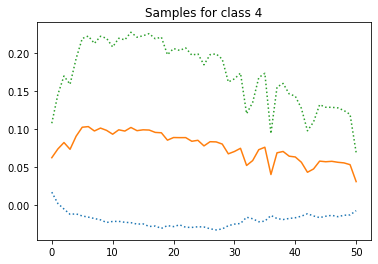

 54%|█████▍    | 54000/100000 [2:25:54<2:00:18,  6.37it/s]

Iter-54000; D_loss: -0.004316431935876608; G_loss: -0.11271992325782776; C_loss: 0.01916891150176525


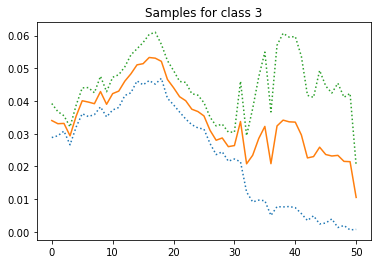

 55%|█████▌    | 55000/100000 [2:28:31<1:55:20,  6.50it/s]

Iter-55000; D_loss: -0.0014416682533919811; G_loss: -0.10857192426919937; C_loss: 0.015964942052960396


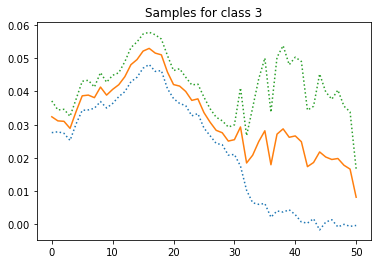

 56%|█████▌    | 56000/100000 [2:31:08<1:51:51,  6.56it/s]

Iter-56000; D_loss: -0.006165239494293928; G_loss: -0.10856836289167404; C_loss: 0.02117864228785038


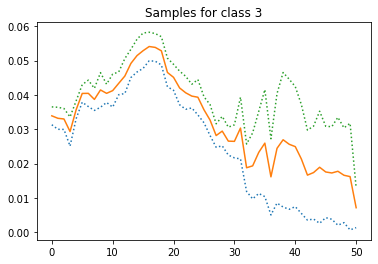

 57%|█████▋    | 57000/100000 [2:33:41<1:47:05,  6.69it/s]

Iter-57000; D_loss: -0.014576797373592854; G_loss: -0.09873894602060318; C_loss: 0.021369539201259613


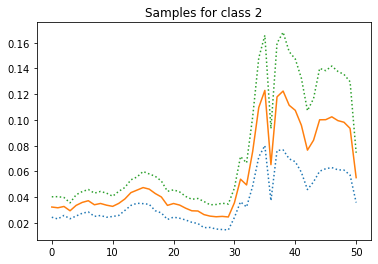

 58%|█████▊    | 58000/100000 [2:36:16<1:41:49,  6.87it/s]

Iter-58000; D_loss: -0.002613231772556901; G_loss: -0.11013969779014587; C_loss: 0.012007667683064938


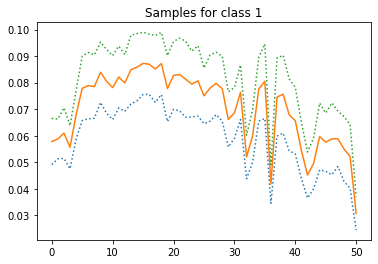

 59%|█████▉    | 59000/100000 [2:38:49<1:45:22,  6.48it/s]

Iter-59000; D_loss: -0.007060469593852758; G_loss: -0.11038969457149506; C_loss: 0.012818592600524426


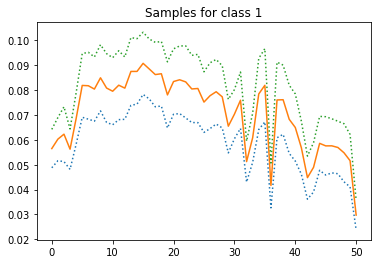

 60%|██████    | 60000/100000 [2:41:22<1:43:19,  6.45it/s]

Iter-60000; D_loss: -0.0007768520154058933; G_loss: -0.10164361447095871; C_loss: 0.01334009412676096


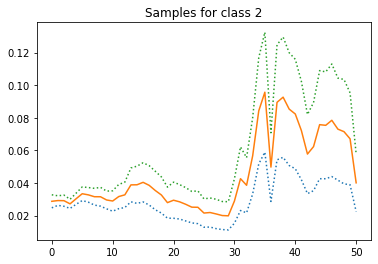

 61%|██████    | 61000/100000 [2:43:56<1:39:40,  6.52it/s]

Iter-61000; D_loss: -0.006228071171790361; G_loss: -0.09401978552341461; C_loss: 0.019896535202860832


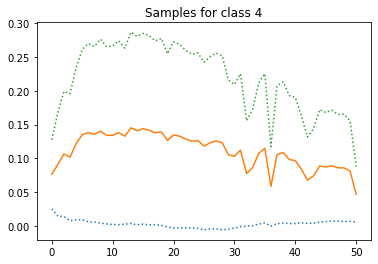

 62%|██████▏   | 62000/100000 [2:46:31<1:47:18,  5.90it/s]

Iter-62000; D_loss: -0.0024458388797938824; G_loss: -0.09550927579402924; C_loss: 0.012992030009627342


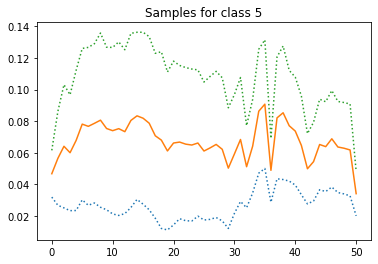

 63%|██████▎   | 63000/100000 [2:49:06<1:30:37,  6.81it/s]

Iter-63000; D_loss: -0.0004686268512159586; G_loss: -0.0889749750494957; C_loss: 0.01770653948187828


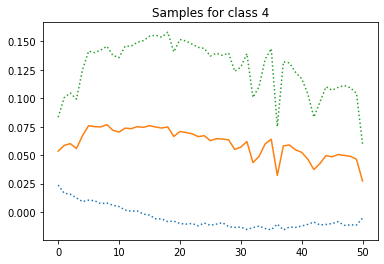

 64%|██████▍   | 64000/100000 [2:51:40<1:30:57,  6.60it/s]

Iter-64000; D_loss: -0.004631496500223875; G_loss: -0.08660867810249329; C_loss: 0.015326299704611301


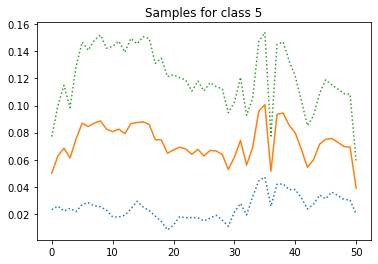

 65%|██████▌   | 65000/100000 [2:54:14<1:25:14,  6.84it/s]

Iter-65000; D_loss: -0.0012518049916252494; G_loss: -0.09006106108427048; C_loss: 0.014830662868916988


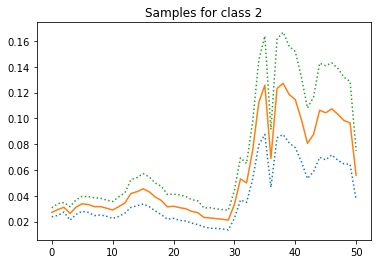

 66%|██████▌   | 66000/100000 [2:56:48<1:33:24,  6.07it/s]

Iter-66000; D_loss: -0.0002170094521716237; G_loss: -0.07994406670331955; C_loss: 0.016178488731384277


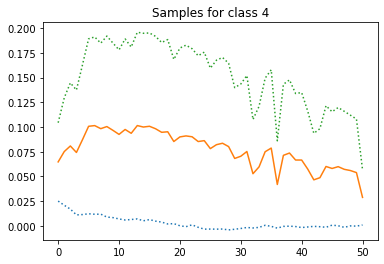

 67%|██████▋   | 67000/100000 [2:59:22<1:28:36,  6.21it/s]

Iter-67000; D_loss: -0.010540337301790714; G_loss: -0.07973816990852356; C_loss: 0.015910251066088676


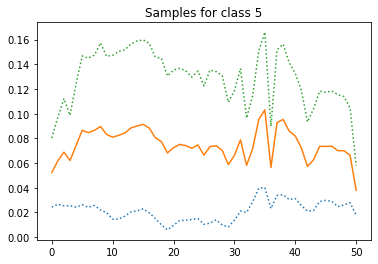

 68%|██████▊   | 68000/100000 [3:01:57<1:22:47,  6.44it/s]

Iter-68000; D_loss: -0.0021865672897547483; G_loss: -0.07797308266162872; C_loss: 0.019170239567756653


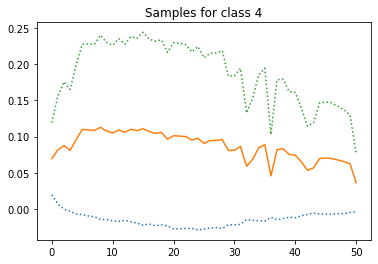

 69%|██████▉   | 69000/100000 [3:04:33<1:20:41,  6.40it/s]

Iter-69000; D_loss: -0.0004457891918718815; G_loss: -0.07066909968852997; C_loss: 0.0149838887155056


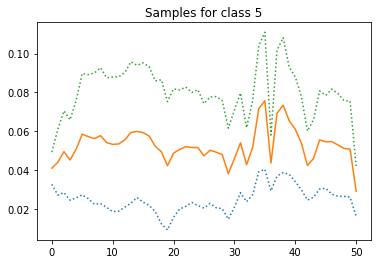

 70%|███████   | 70000/100000 [3:07:08<1:17:38,  6.44it/s]

Iter-70000; D_loss: -0.00437024375423789; G_loss: -0.07843075692653656; C_loss: 0.01897192932665348


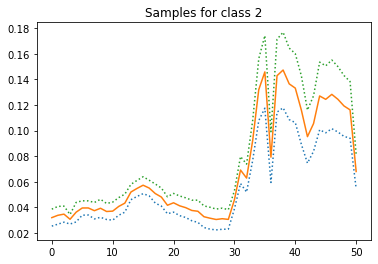

 71%|███████   | 71000/100000 [3:09:44<1:13:01,  6.62it/s]

Iter-71000; D_loss: -0.0061667319387197495; G_loss: -0.0765032172203064; C_loss: 0.018674395978450775


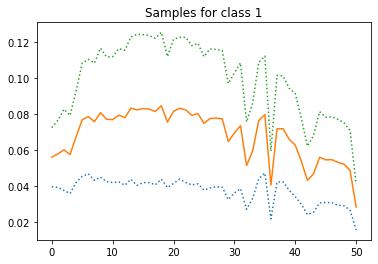

 72%|███████▏  | 72000/100000 [3:12:20<1:13:10,  6.38it/s]

Iter-72000; D_loss: -0.0006761629483662546; G_loss: -0.07513383775949478; C_loss: 0.014007549732923508


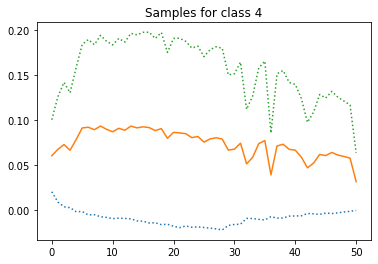

 73%|███████▎  | 73000/100000 [3:14:54<1:09:44,  6.45it/s]

Iter-73000; D_loss: -0.0024489760398864746; G_loss: -0.07646767795085907; C_loss: 0.011330926790833473


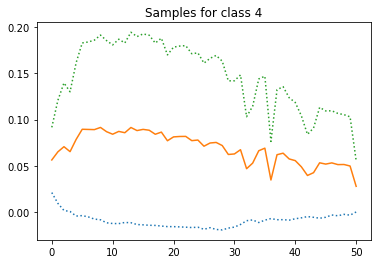

 74%|███████▍  | 74000/100000 [3:17:30<1:07:30,  6.42it/s]

Iter-74000; D_loss: -0.005587642081081867; G_loss: -0.06977642327547073; C_loss: 0.016147619113326073


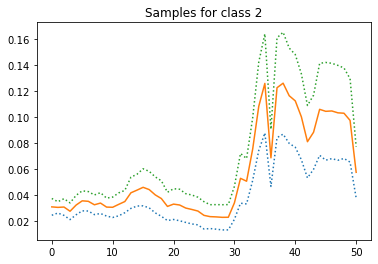

 75%|███████▌  | 75000/100000 [3:20:07<1:02:51,  6.63it/s]

Iter-75000; D_loss: -0.001523460727185011; G_loss: -0.06732100248336792; C_loss: 0.016396526247262955


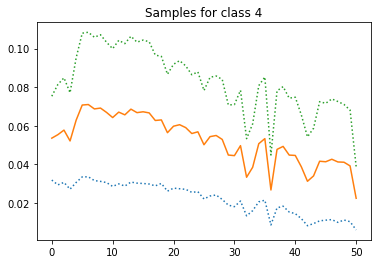

 76%|███████▌  | 76000/100000 [3:22:43<1:03:11,  6.33it/s]

Iter-76000; D_loss: -0.0005001998506486416; G_loss: -0.06976203620433807; C_loss: 0.013148852623999119


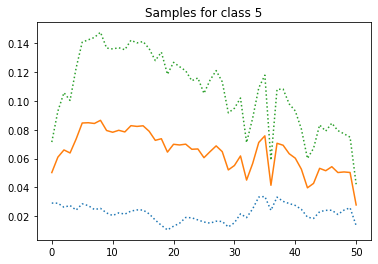

 77%|███████▋  | 77000/100000 [3:25:19<1:03:25,  6.04it/s]

Iter-77000; D_loss: -0.001145399990491569; G_loss: -0.06607159972190857; C_loss: 0.01301759947091341


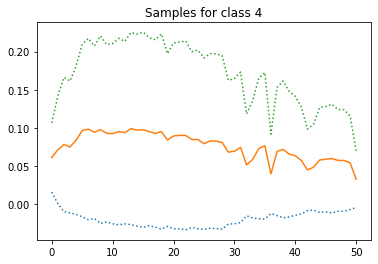

 78%|███████▊  | 78000/100000 [3:27:55<56:19,  6.51it/s]  

Iter-78000; D_loss: 0.000981486402451992; G_loss: -0.06729879975318909; C_loss: 0.01239139772951603


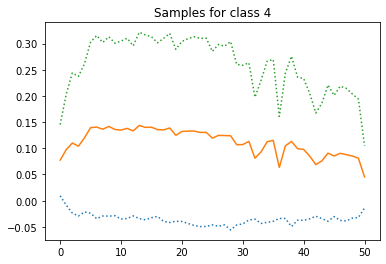

 79%|███████▉  | 79000/100000 [3:30:31<55:30,  6.30it/s]  

Iter-79000; D_loss: -0.000497697270475328; G_loss: -0.06220082938671112; C_loss: 0.013836606405675411


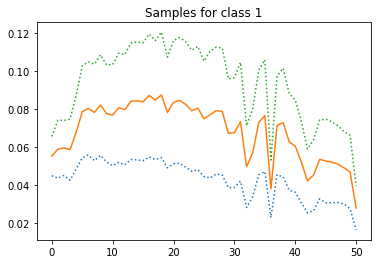

 80%|████████  | 80000/100000 [3:33:08<51:33,  6.47it/s]  

Iter-80000; D_loss: -0.0014197136042639613; G_loss: -0.06326544284820557; C_loss: 0.015302100218832493


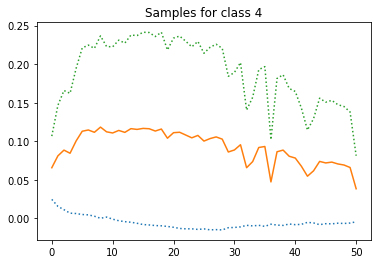

 81%|████████  | 81000/100000 [3:35:45<49:01,  6.46it/s]  

Iter-81000; D_loss: 0.000601023668423295; G_loss: -0.06711016595363617; C_loss: 0.015295685268938541


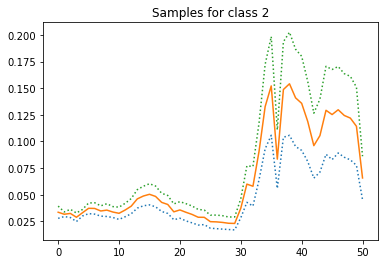

 82%|████████▏ | 82000/100000 [3:38:22<45:58,  6.53it/s]  

Iter-82000; D_loss: -0.0007776536513119936; G_loss: -0.0754246711730957; C_loss: 0.012574875727295876


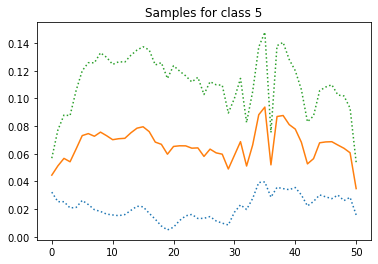

 83%|████████▎ | 83000/100000 [3:40:59<44:02,  6.43it/s]

Iter-83000; D_loss: -0.0017814168240875006; G_loss: -0.06691832095384598; C_loss: 0.012535578571259975


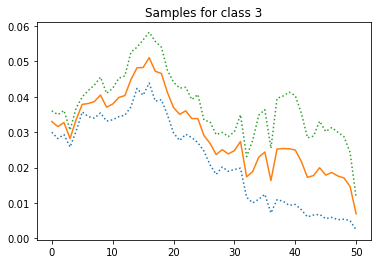

 84%|████████▍ | 84000/100000 [3:43:37<39:26,  6.76it/s]

Iter-84000; D_loss: -0.0034955539740622044; G_loss: -0.05927383899688721; C_loss: 0.011170521378517151


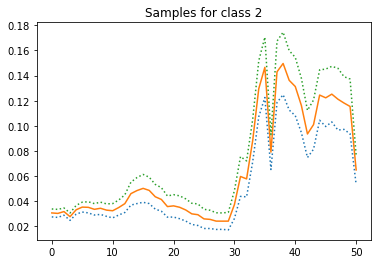

 85%|████████▌ | 85000/100000 [3:46:15<38:10,  6.55it/s]

Iter-85000; D_loss: -0.0006369046168401837; G_loss: -0.06531224399805069; C_loss: 0.013577363453805447


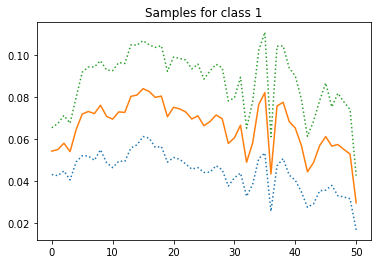

 86%|████████▌ | 86000/100000 [3:48:52<38:35,  6.05it/s]

Iter-86000; D_loss: -0.0034182961098849773; G_loss: -0.062205929309129715; C_loss: 0.011720760725438595


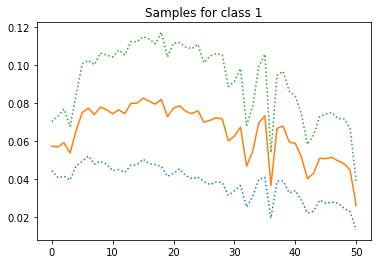

 87%|████████▋ | 87000/100000 [3:51:30<33:11,  6.53it/s]

Iter-87000; D_loss: 0.00042029726319015026; G_loss: -0.06595869362354279; C_loss: 0.016053268685936928


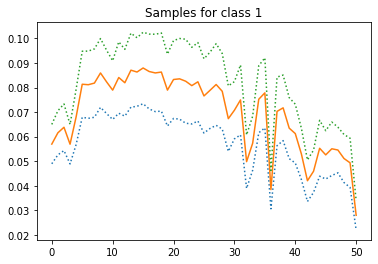

 88%|████████▊ | 88000/100000 [3:54:07<30:50,  6.49it/s]

Iter-88000; D_loss: -0.0011914202477782965; G_loss: -0.062284037470817566; C_loss: 0.011681215837597847


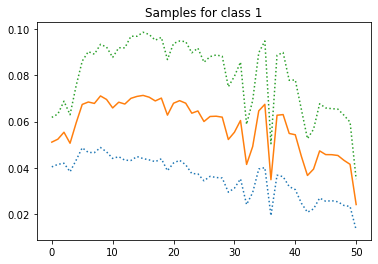

 89%|████████▉ | 89000/100000 [3:56:45<29:00,  6.32it/s]

Iter-89000; D_loss: 0.0002141058794222772; G_loss: -0.06497986614704132; C_loss: 0.013043423183262348


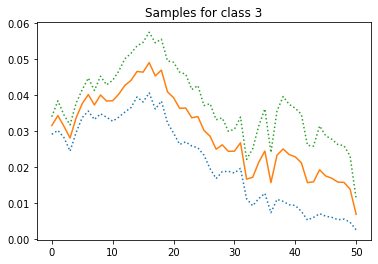

 90%|█████████ | 90000/100000 [3:59:23<25:46,  6.47it/s]

Iter-90000; D_loss: -0.0025808459613472223; G_loss: -0.07399997860193253; C_loss: 0.009701613336801529


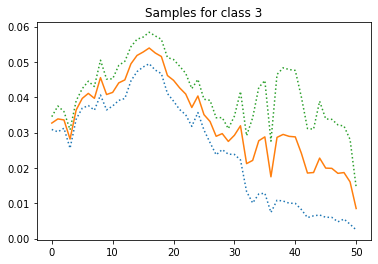

 91%|█████████ | 91000/100000 [4:02:01<22:33,  6.65it/s]

Iter-91000; D_loss: -0.005661148112267256; G_loss: -0.060289010405540466; C_loss: 0.014274412766098976


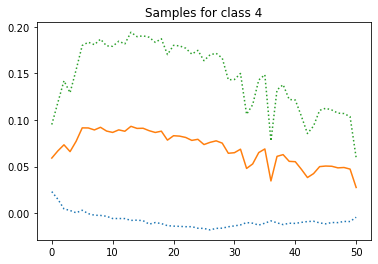

 92%|█████████▏| 92000/100000 [4:04:41<20:43,  6.43it/s]

Iter-92000; D_loss: 1.551816239953041e-07; G_loss: -0.07005038857460022; C_loss: 0.013288483023643494


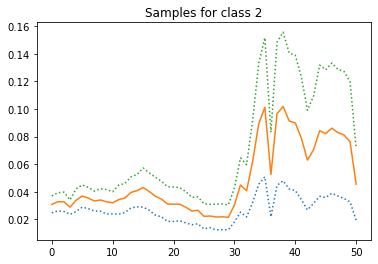

 93%|█████████▎| 93000/100000 [4:07:20<18:19,  6.37it/s]

Iter-93000; D_loss: -0.0021039359271526337; G_loss: -0.06287319958209991; C_loss: 0.011835002340376377


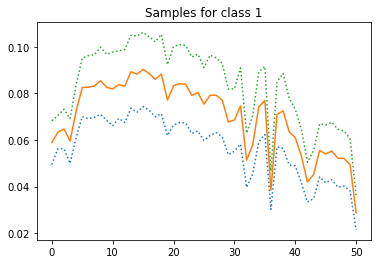

 94%|█████████▍| 94000/100000 [4:09:58<16:13,  6.16it/s]

Iter-94000; D_loss: -0.0027338056825101376; G_loss: -0.061841368675231934; C_loss: 0.010617666877806187


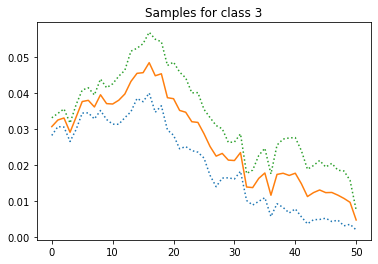

 95%|█████████▌| 95000/100000 [4:12:38<13:20,  6.25it/s]

Iter-95000; D_loss: -0.0010614695493131876; G_loss: -0.05924975126981735; C_loss: 0.011630717664957047


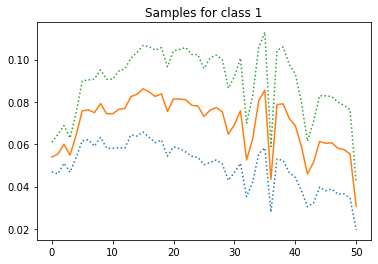

 96%|█████████▌| 96000/100000 [4:15:18<10:22,  6.43it/s]

Iter-96000; D_loss: -0.0005513811483979225; G_loss: -0.06763715296983719; C_loss: 0.01283488143235445


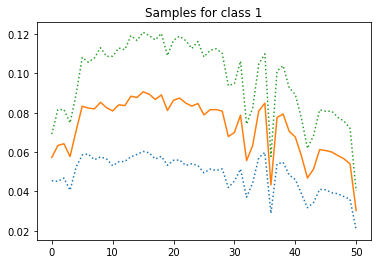

 97%|█████████▋| 97000/100000 [4:17:56<07:49,  6.39it/s]

Iter-97000; D_loss: 0.00042430427856743336; G_loss: -0.06308498978614807; C_loss: 0.014828922227025032


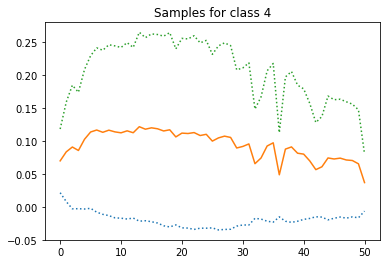

 98%|█████████▊| 98000/100000 [4:20:36<05:01,  6.64it/s]

Iter-98000; D_loss: 0.0004921522922813892; G_loss: -0.06069391220808029; C_loss: 0.01652226224541664


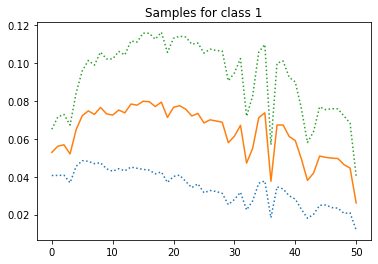

 99%|█████████▉| 99000/100000 [4:23:16<02:41,  6.20it/s]

Iter-99000; D_loss: -0.001295671216212213; G_loss: -0.0624348446726799; C_loss: 0.011636235751211643


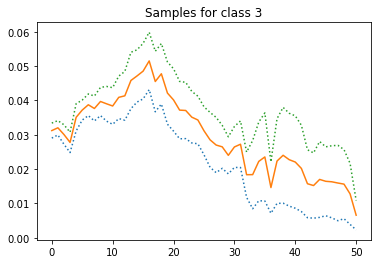

100%|██████████| 100000/100000 [4:25:57<00:00,  6.27it/s]


In [11]:
# Get networks
G = Generator().cuda()
D = Discriminator().cuda()
C = Classifier().cuda()
# Use RMSProp optimizer
G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)
C_solver = optim.RMSprop(C.parameters(), lr=lr)

for it in tqdm(range(100000)):
    ###########################
    # (1) Update C and D      #
    ###########################
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update
    for p in C.parameters():
        p.requires_grad = True
    
    # D is trained d_step times for each iteration
    
    for _, (X, y), (X_, y_) in zip(range(d_step), data_loader, data_loader):
        D.zero_grad()

        # Sample random noise
        z = torch.randn(y.size(0), z_dim).squeeze()
        X, y = X.float(), y.float()
        X_, y_ = X_.float(), y_.float()
        # Mixup
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        X = lam*X + (1. - lam)*X_
        X, y, z = X.cuda(), y.cuda(), z.cuda()
        y_ = y_.cuda()
        
        # Get discriminator prediction on real samples
        D_real = D(X).mean()
        # Get discriminator prediction on fake samples
        fake_samples = G(z, y)
        D_fake = D(fake_samples).mean()
        # Compute gradient penalty
        gradient_penalty = calc_gradient_penalty(D, X.data, fake_samples.data)
        # Compute loss and backpropagate
        D_loss = D_fake - D_real + gradient_penalty
        flip = np.random.random() < flip_percentage
        if flip: 
            # Flip real and fake
            gradient_penalty = calc_gradient_penalty(D, fake_samples.data, X.data)
            D_loss = D_real - D_fake + gradient_penalty
        D_loss.backward()
        D_solver.step()
    
        ######################
        #  Update C network  #
        ######################
        C.zero_grad()
        # Get class values
        _, classes = torch.max(y, dim=1)
        _, classes_ = torch.max(y_, dim=1)
        # Get predictions from C
        if flip:
            fake_samples = G(z, y)
            pred = C(fake_samples)
            # Compute loss and backpropagate
            C_loss = F.cross_entropy(pred, classes, weight=class_weights)
        else:
            pred = F.log_softmax(C(X))
            C_loss = lam * F.nll_loss(pred, classes) + (1. - lam) * F.nll_loss(pred, classes_)
        C_loss.backward()
        C_solver.step()


    ############################
    # (2) Update G network
    ###########################
    for p in D.parameters():
        p.requires_grad = False  # to avoid computation
    for p in C.parameters():
        p.requires_grad = False
    reset_grad(C, G, D)

    # Sample random noise
    z = torch.randn(y.size(0), z_dim).squeeze()
    z = z.cuda()
    # Generate fake samples
    G_sample = G(z, y)
    D_fake = D(G_sample)
    pred = C(G_sample)
    C_loss = F.cross_entropy(pred, classes, weight=class_weights)
    # Fool the discriminator (WGAN)
    G_loss = -torch.mean(D_fake)
    # Include the auxialiary classifier loss (AC-GAN)
    loss = G_loss + c_weight * C_loss
    # Backpropagate
    loss.backward()
    G_solver.step()

    # Print and plot every now and then
    if it % 1000 == 0:
        with torch.no_grad():
            print('Iter-{}; D_loss: {}; G_loss: {}; C_loss: {}'.format(it,
                                                           D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy(),
                                                           C_loss.data.cpu().numpy()))
            z = torch.randn(mb_size, z_dim).squeeze().cuda()
            c = np.zeros(shape=[mb_size, c_dim], dtype='float32')
            idx = np.random.randint(1, data_loader.dataset.n_classes)
            c[:, idx] = 1.
            c = torch.from_numpy(c).squeeze().cuda()
            samples = G(z, c).data.cpu().numpy()[:16]
            pred = G(z, c)
            plot_mean_std(samples)
            plt.title("Samples for class {}".format(idx))
            plt.show()

## Data generation

Now that the generator has been trained, we can generate some fake spectra and see how they fare visually against the real ones.

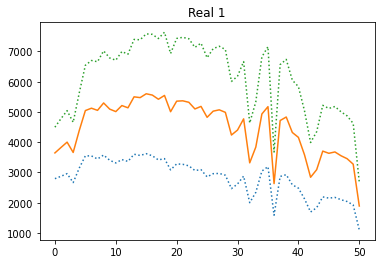

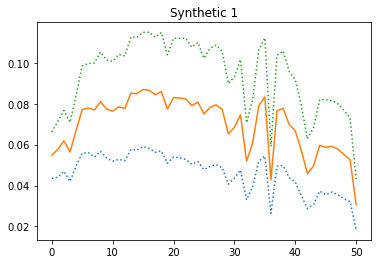

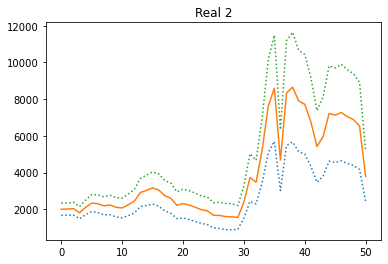

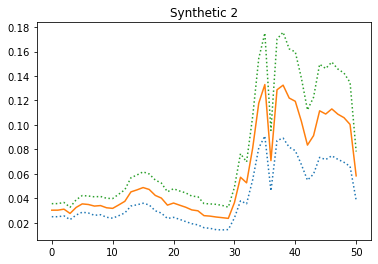

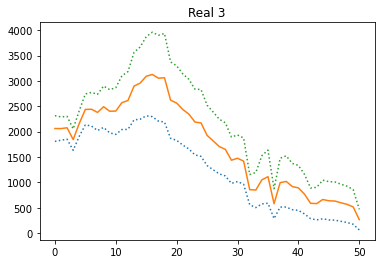

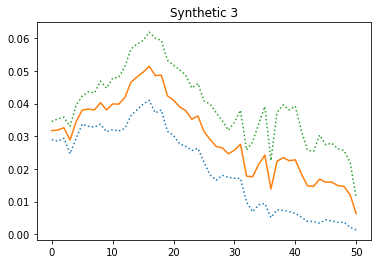

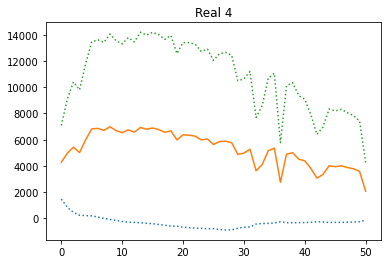

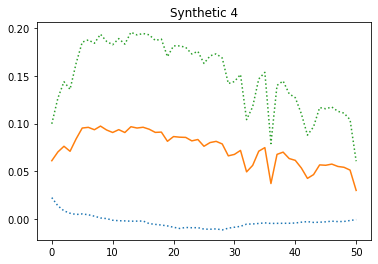

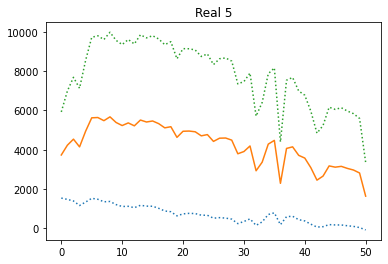

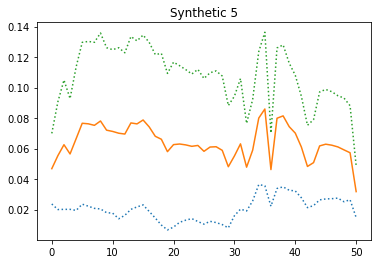

In [12]:
for c in np.unique(gt):
    # 0 is the "undefined" class
    if c == 0:
        continue
    
    # Get the mean spectrum +- std for this class
    spectras = img[gt == c, :]
    plot_mean_std(spectras)
    plt.title("Real {}".format(c))
    plt.show()
    
    # Get as many fake spectras as real ones
    synthetic_spectras = []
    with torch.no_grad():
        while len(synthetic_spectras) < len(spectras):
            z = torch.randn(mb_size, z_dim).cuda()
            y = torch.from_numpy(np.eye(data_loader.dataset.n_classes)[c]).float()
            y = y.unsqueeze(0).repeat(mb_size, 1).cuda()
            G_sample = G(z, y)
            _, classes = torch.max(y, 1)
            _, pred = torch.max(C(G_sample), 1)
            synthetic_spectras += list(G_sample.cpu().data.numpy())
    plt.show()
    plot_mean_std(synthetic_spectras)
    plt.title("Synthetic {}".format(c))
    plt.show()

## Evaluation

Finally, we want to compare the two distributions: is the fake distribution truely similar to the real distribution? To this end, we first can train a linear SVM on the real data and then apply it on the fake data. The frontiers of the real data should be respected by the fake data if the learning was successful.

In [13]:
import sklearn.svm
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.mixture

In [14]:
img = (img - img.min()) / (img.max() - img.min())
X_train = np.array([img[x,y] for x,y in zip(*np.nonzero(train_gt))])
y_train = np.array([gt[x,y] for x,y in zip(*np.nonzero(train_gt))])
X_test = np.array([img[x,y] for x,y in zip(*np.nonzero(test_gt))])
y_test = np.array([test_gt[x,y] for x,y in zip(*np.nonzero(test_gt))])

In [15]:
gmms = [sklearn.mixture.GaussianMixture(n_components=20) for _ in range(c_dim)]
for y in np.unique(y_train):
    gmms[y].fit(X_train[y_train == y])

We can uncomment this code to use Gaussian Mixture Models instead of GANs.

In [16]:
def gmm_create_fake_dataset(gmms, y):
    fake_X = []
    y_fake = []
    for y in np.unique(y):
        n_samples = np.count_nonzero(y_test == y)
        samples = gmms[y].sample(n_samples)[0]
        fake_X.append(samples)
        y_fake += [y] * n_samples
    fake_X = np.concatenate(fake_X)
    y_fake = np.array(y_fake)
    return fake_X, y_fake

#fake_X_train, fake_y_train = gmm_create_fake_dataset(gmms, y_train)
#fake_X_test, fake_y_test = gmm_create_fake_dataset(gmms, y_test)

### SVM on real data

Let's train a linear SVM on real data and see how it performs.

In [17]:
scaler = sklearn.preprocessing.StandardScaler()
svm = sklearn.svm.SVC()
#estimator = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm)])
estimator = sklearn.pipeline.Pipeline(steps=[('svm', svm)])
#tuned_parameters = {'svm__C': [0.1, 1, 10, 100, 1000], 'svm__kernel': ['linear']}
tuned_parameters = {'svm__C': [1000], 'svm__kernel': ['linear']}
clf = sklearn.model_selection.GridSearchCV(estimator, tuned_parameters, cv=5, n_jobs=4)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
best_params = clf.best_params_
print("The best SVM was obtained using {} and performed at {:.2f} accuracy.".format(best_params, 100 * score))

The best SVM was obtained using {'svm__C': 1000, 'svm__kernel': 'linear'} and performed at 89.47 accuracy.


In [18]:
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.85      0.85      0.85   1849505
           2       0.97      0.98      0.98   3031804
           3       0.99      0.95      0.97    112734
           4       0.72      0.81      0.76    871447
           5       0.99      0.02      0.05    125408

    accuracy                           0.89   5990898
   macro avg       0.90      0.72      0.72   5990898
weighted avg       0.90      0.89      0.89   5990898



### SVM on fake data

We now generate some fake data (in the same quantities as the real data) and apply the trained SVM on it.

In [19]:
def gan_create_fake_dataset(labels):
    with torch.no_grad():
        spectras = []
        for l in np.array_split(labels, len(labels) // mb_size):
            z = torch.randn(len(l), z_dim).cuda()
            y = np.zeros((len(l), data_loader.dataset.n_classes))
            for i, label in enumerate(l):
                y[i] = np.eye(data_loader.dataset.n_classes)[label]
            y = torch.from_numpy(y).float()
            eps = torch.randn(y.size())/10
            #y += eps
            y = y.cuda()
            G_sample = G(z, y)
            spectras += list(G_sample.cpu().data.numpy())
        return np.array(spectras), np.array(labels)

In [20]:
fake_X_train, fake_y_train = gan_create_fake_dataset(y_train)
fake_X_test, fake_y_test = gan_create_fake_dataset(y_test)

The true SVM performs better on fake data. Fake data is easier to separate, which means that it does not capture well boundaries between classes.

In [21]:
clf.score(fake_X_test, fake_y_test)

0.9485344267253424

In [22]:
y_fake_pred = clf.predict(fake_X_test)
from sklearn.metrics import classification_report
print(classification_report(fake_y_test, y_fake_pred))

              precision    recall  f1-score   support

           1       0.90      0.97      0.93   1849505
           2       0.98      1.00      0.99   3031804
           3       1.00      1.00      1.00    112734
           4       0.93      0.86      0.89    871447
           5       0.98      0.00      0.01    125408

    accuracy                           0.95   5990898
   macro avg       0.96      0.77      0.76   5990898
weighted avg       0.95      0.95      0.94   5990898



We can also train a "fake" SVM on fake data. It separates the fake data nearly perfectly. However, it also neatly separates the true data. It is not as good as the true SVM, but still relatively good for synthetic data.

In [23]:
svm_fake = sklearn.svm.SVC()
clf_fake = sklearn.pipeline.Pipeline(steps=[('svm', svm_fake)])
clf_fake.set_params(**clf.best_params_)
clf_fake.fit(np.concatenate([fake_X_train]), np.concatenate([fake_y_train]))

Pipeline(steps=[('svm', SVC(C=1000, kernel='linear'))])

In [24]:
clf_fake.score(fake_X_test, fake_y_test)

0.9977679473094017

In [25]:
clf_fake.score(X_test, y_test)

0.8655480363711751

## Data augmentation

We can train on both real and fake data to use the latter as augmented data. However, as we saw the fake data does not capture class boundaries very well. Therefore, it only skews the SVM and worsen the accuracy.

In [26]:
svm_augmented = sklearn.svm.SVC()
#clf_augmented = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm_augmented)])
clf_augmented = sklearn.pipeline.Pipeline(steps=[('svm', svm_augmented)])
clf_augmented.set_params(**clf.best_params_)
clf_augmented.fit(np.concatenate([X_train, fake_X_train]), np.concatenate([y_train, fake_y_train]))

Pipeline(steps=[('svm', SVC(C=1000, kernel='linear'))])

In [27]:
clf_augmented.score(X_test, y_test)

0.8914823787685919

## Statistical analysis

We can apply a PCA to both the real and fake datasets to visually compare them. The distributions in the 2D main components are fairly similar, which is good!

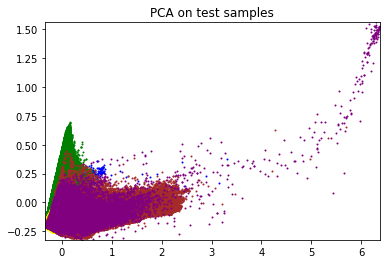

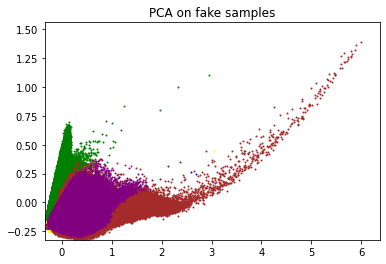

In [28]:
%matplotlib inline
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)
x_min, x_max = np.min(X_pca[:,0]), np.max(X_pca[:,0])
y_min, y_max = np.min(X_pca[:,1]), np.max(X_pca[:,1])

colors = ['red', 'blue', 'green', 'yellow', 'brown', 'purple', 'cyan', 'olive', 'pink', 'gray']
for i, color in enumerate(colors):
    idx = y_test == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, s=1)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on test samples')
plt.show()

X_fake_pca = pca.transform(fake_X_test)
for i, color in enumerate(colors):
    idx = fake_y_test == i
    plt.scatter(X_fake_pca[idx, 0], X_fake_pca[idx, 1], s=1, c=color)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on fake samples')
plt.show()

We can train a neural network classifier on the real dataset and the augmented dataset (real + fake).

In [29]:
def train(net, X_train, y_train, epochs=100):
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(),
                                             torch.from_numpy(y_train).long())
    loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)
    solver = optim.Adam(net.parameters(), amsgrad=True)
    net.train()
    it = 0
    losses = []
    for _ in tqdm(range(epochs)):
        for X, y in loader:
            it += 1
            net.zero_grad()
            X, y = X.cuda(), y.cuda()
            out = net(X)
            loss = F.cross_entropy(out, y)
            loss.backward()
            solver.step()
            losses.append(loss.item())
            if it % 10000 == 0:
                print("Loss at {} = {}".format(it, loss.item()))
                plt.plot(losses) and plt.show()
    return net

  0%|          | 32/10000 [02:44<14:16:00,  5.15s/it]

Loss at 10000 = 0.1773766279220581


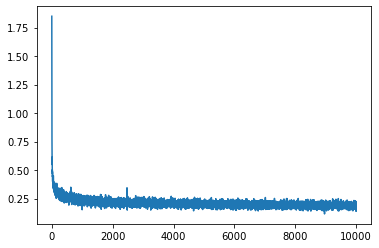

  1%|          | 64/10000 [05:29<14:09:10,  5.13s/it]

Loss at 20000 = 0.17621485888957977


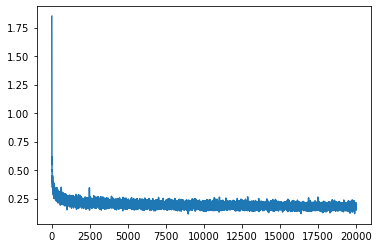

  1%|          | 97/10000 [08:18<14:02:58,  5.11s/it]

Loss at 30000 = 0.1626732349395752


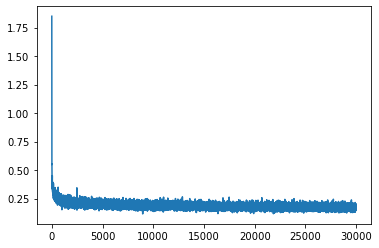

  1%|▏         | 129/10000 [11:02<14:04:29,  5.13s/it]

Loss at 40000 = 0.17644274234771729


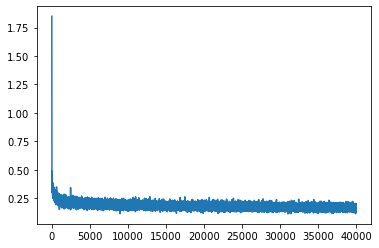

  2%|▏         | 161/10000 [13:46<13:58:36,  5.11s/it]

Loss at 50000 = 0.13772855699062347


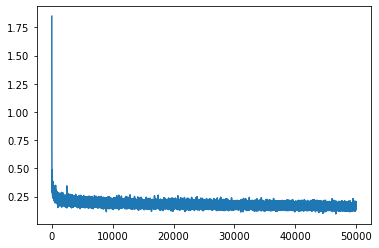

  2%|▏         | 194/10000 [16:36<13:59:21,  5.14s/it]

Loss at 60000 = 0.15077877044677734


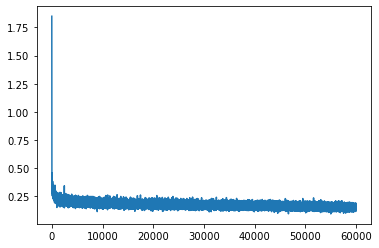

  2%|▏         | 226/10000 [19:20<13:58:27,  5.15s/it]

Loss at 70000 = 0.152117058634758


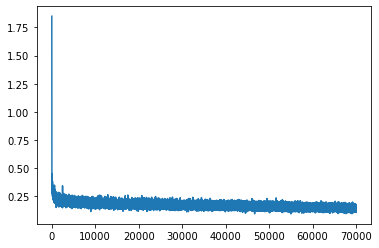

  3%|▎         | 258/10000 [22:04<13:49:36,  5.11s/it]

Loss at 80000 = 0.14121003448963165


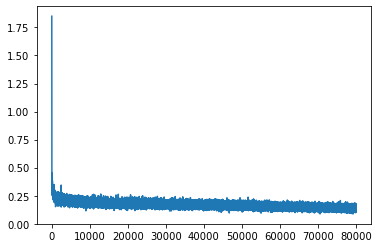

  3%|▎         | 291/10000 [24:53<13:49:14,  5.12s/it]

Loss at 90000 = 0.12496288865804672


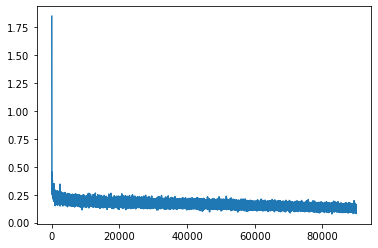

  3%|▎         | 323/10000 [27:38<13:52:13,  5.16s/it]

Loss at 100000 = 0.12146924436092377


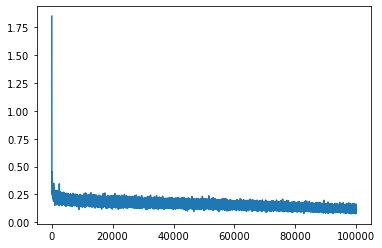

  4%|▎         | 355/10000 [30:22<13:43:19,  5.12s/it]

Loss at 110000 = 0.11334862560033798


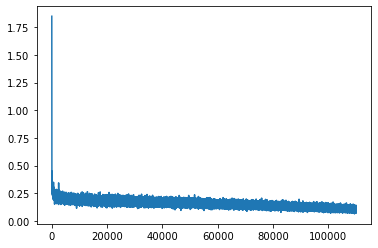

  4%|▍         | 388/10000 [33:11<13:39:47,  5.12s/it]

Loss at 120000 = 0.0833331048488617


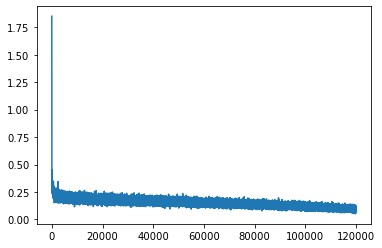

  4%|▍         | 420/10000 [35:56<13:40:16,  5.14s/it]

Loss at 130000 = 0.07750584185123444


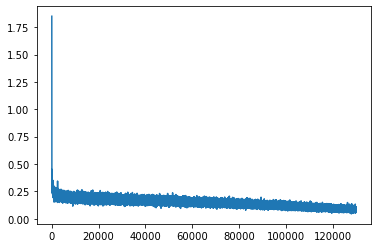

  5%|▍         | 453/10000 [38:45<13:35:40,  5.13s/it]

Loss at 140000 = 0.057474952191114426


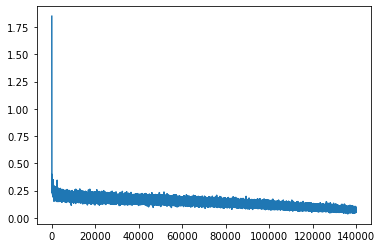

  5%|▍         | 485/10000 [41:30<13:33:21,  5.13s/it]

Loss at 150000 = 0.04794042557477951


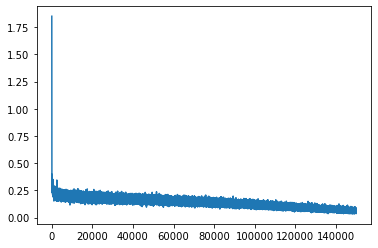

  5%|▌         | 517/10000 [44:14<13:29:19,  5.12s/it]

Loss at 160000 = 0.061841368675231934


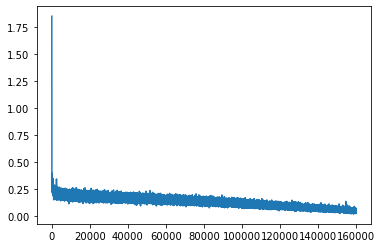

  6%|▌         | 550/10000 [47:04<13:28:21,  5.13s/it]

Loss at 170000 = 0.03534923866391182


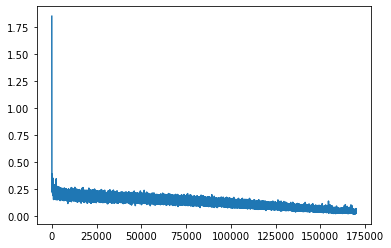

  6%|▌         | 582/10000 [49:48<13:27:00,  5.14s/it]

Loss at 180000 = 0.0240420363843441


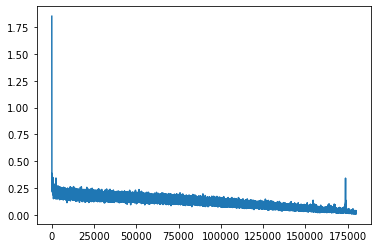

  6%|▌         | 614/10000 [52:32<13:21:45,  5.13s/it]

Loss at 190000 = 0.020197123289108276


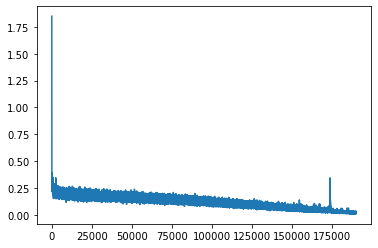

  6%|▋         | 647/10000 [55:22<13:21:53,  5.14s/it]

Loss at 200000 = 0.006650890223681927


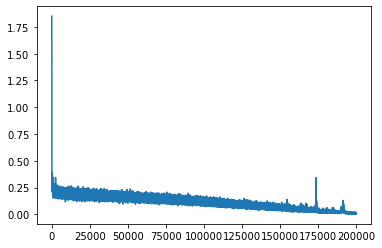

  7%|▋         | 679/10000 [58:06<13:16:51,  5.13s/it]

Loss at 210000 = 0.007191789336502552


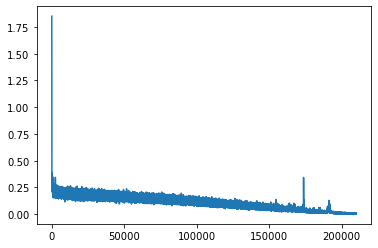

  7%|▋         | 711/10000 [1:00:51<13:16:16,  5.14s/it]

Loss at 220000 = 0.004202795680612326


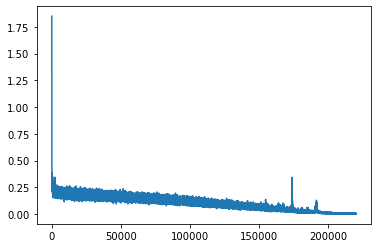

  7%|▋         | 744/10000 [1:03:40<13:11:04,  5.13s/it]

Loss at 230000 = 0.0022807216737419367


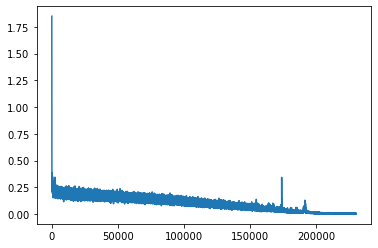

  8%|▊         | 776/10000 [1:06:24<13:13:36,  5.16s/it]

Loss at 240000 = 0.0023331022821366787


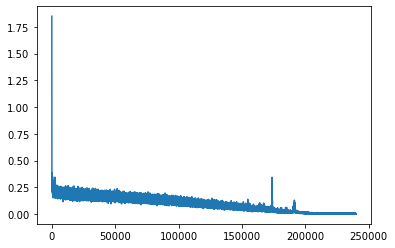

  8%|▊         | 809/10000 [1:09:14<13:07:09,  5.14s/it]

Loss at 250000 = 0.0012149754911661148


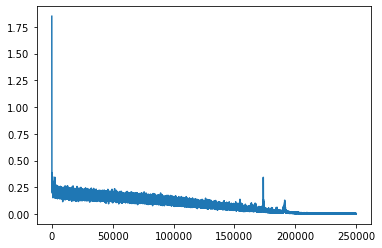

  8%|▊         | 841/10000 [1:11:58<13:06:07,  5.15s/it]

Loss at 260000 = 0.0031782977748662233


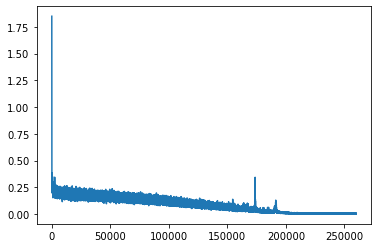

  9%|▊         | 873/10000 [1:14:43<12:59:23,  5.12s/it]

Loss at 270000 = 0.0009173056459985673


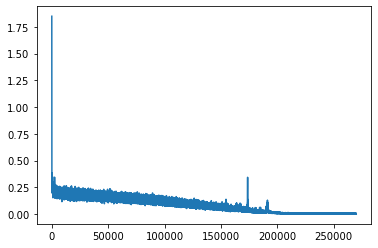

  9%|▉         | 906/10000 [1:17:32<12:58:16,  5.13s/it]

Loss at 280000 = 0.0009616833413019776


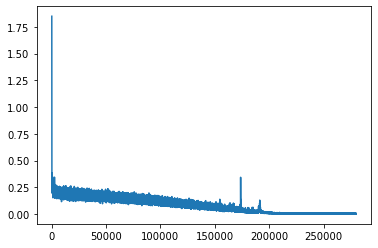

  9%|▉         | 938/10000 [1:20:17<12:54:09,  5.13s/it]

Loss at 290000 = 0.021612439304590225


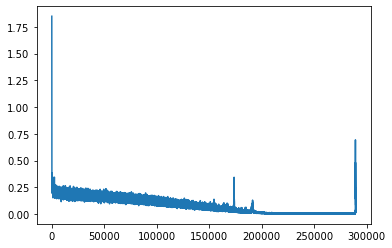

 10%|▉         | 970/10000 [1:23:01<12:55:26,  5.15s/it]

Loss at 300000 = 0.0008118873811326921


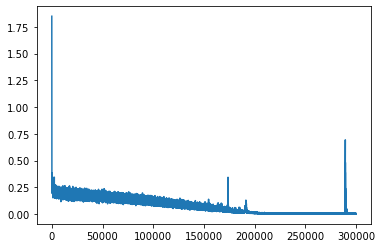

 10%|█         | 1003/10000 [1:25:51<12:48:43,  5.13s/it]

Loss at 310000 = 0.0009767552837729454


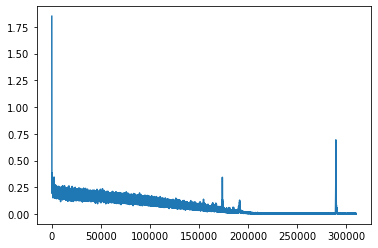

 10%|█         | 1035/10000 [1:28:36<12:47:30,  5.14s/it]

Loss at 320000 = 0.0006920970045030117


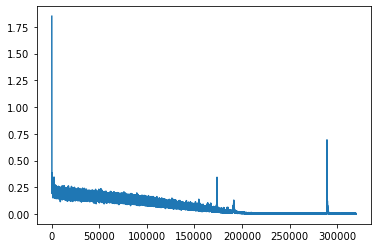

 11%|█         | 1067/10000 [1:31:21<12:45:07,  5.14s/it]

Loss at 330000 = 0.0007696539396420121


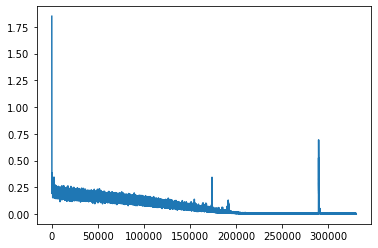

 11%|█         | 1100/10000 [1:34:11<12:41:52,  5.14s/it]

Loss at 340000 = 0.000615766504779458


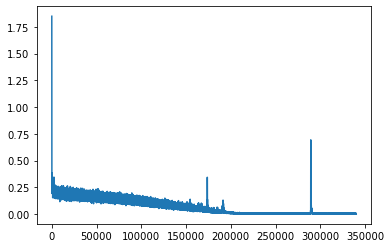

 11%|█▏        | 1132/10000 [1:36:56<12:37:35,  5.13s/it]

Loss at 350000 = 0.0005542270955629647


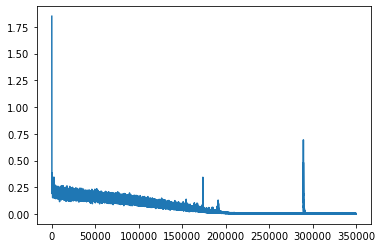

 12%|█▏        | 1165/10000 [1:39:46<12:34:58,  5.13s/it]

Loss at 360000 = 0.0004907043185085058


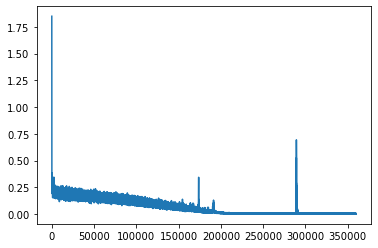

 12%|█▏        | 1197/10000 [1:42:30<12:33:03,  5.13s/it]

Loss at 370000 = 0.0003268258005846292


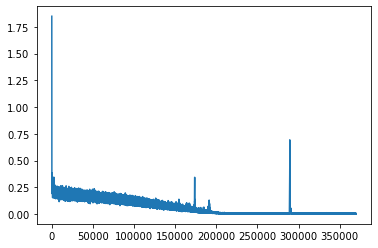

 12%|█▏        | 1229/10000 [1:45:15<12:31:41,  5.14s/it]

Loss at 380000 = 0.0003926135250367224


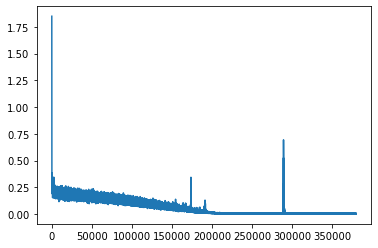

 13%|█▎        | 1262/10000 [1:48:05<12:25:47,  5.12s/it]

Loss at 390000 = 0.0004717152041848749


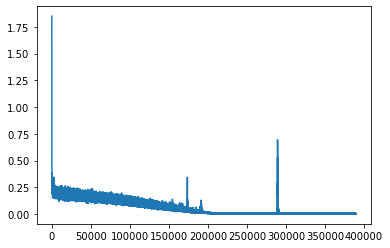

 13%|█▎        | 1294/10000 [1:50:49<12:24:50,  5.13s/it]

Loss at 400000 = 0.00043160762288607657


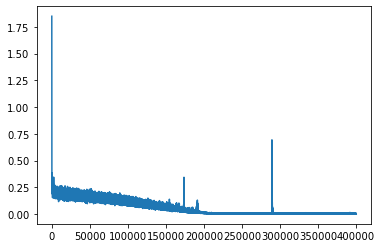

 13%|█▎        | 1326/10000 [1:53:34<12:23:47,  5.14s/it]

Loss at 410000 = 0.0005107031902298331


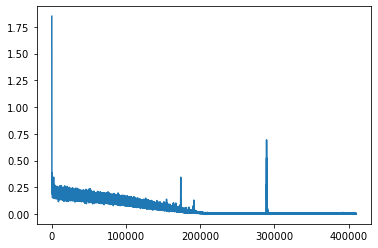

 14%|█▎        | 1359/10000 [1:56:24<12:18:56,  5.13s/it]

Loss at 420000 = 0.0004025822563562542


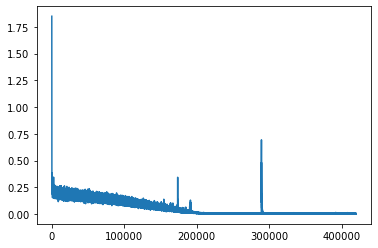

 14%|█▍        | 1391/10000 [1:59:09<12:18:10,  5.14s/it]

Loss at 430000 = 0.0003323855344206095


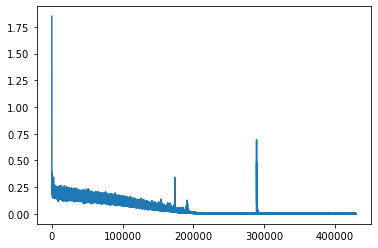

 14%|█▍        | 1423/10000 [2:01:54<12:13:15,  5.13s/it]

Loss at 440000 = 0.0003873738751281053


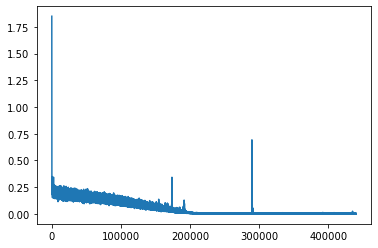

 15%|█▍        | 1456/10000 [2:04:44<12:10:05,  5.13s/it]

Loss at 450000 = 0.0002924387517850846


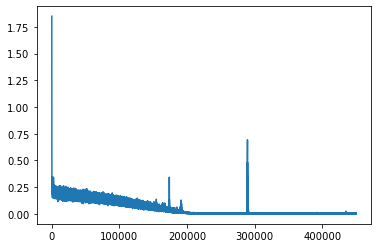

 15%|█▍        | 1488/10000 [2:07:29<12:11:44,  5.16s/it]

Loss at 460000 = 0.00034242423134855926


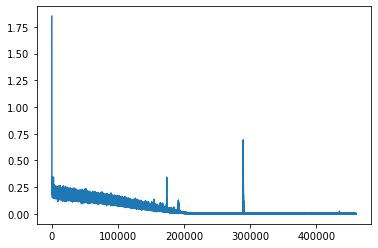

 15%|█▌        | 1521/10000 [2:10:19<12:06:03,  5.14s/it]

Loss at 470000 = 0.0002808480057865381


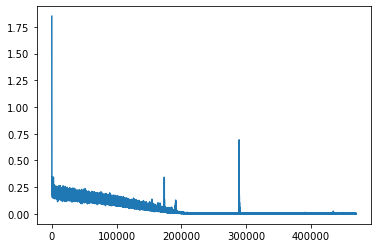

 16%|█▌        | 1553/10000 [2:13:04<12:04:35,  5.15s/it]

Loss at 480000 = 0.00030126154888421297


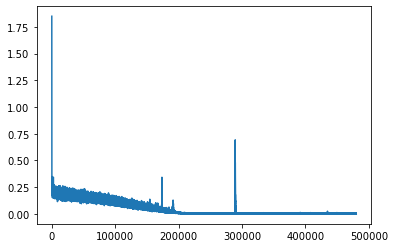

 16%|█▌        | 1585/10000 [2:15:49<12:01:27,  5.14s/it]

Loss at 490000 = 0.0002721871715039015


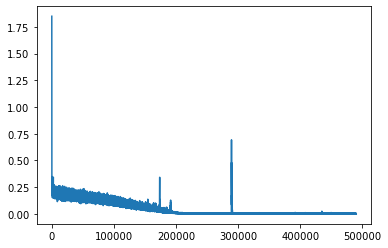

 16%|█▌        | 1618/10000 [2:18:38<11:57:06,  5.13s/it]

Loss at 500000 = 0.00027375653735361993


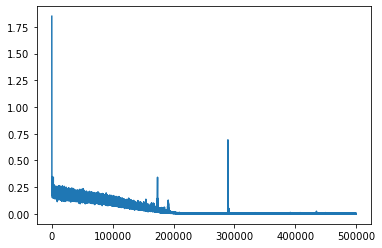

 16%|█▋        | 1650/10000 [2:21:23<11:55:09,  5.14s/it]

Loss at 510000 = 0.00017839157953858376


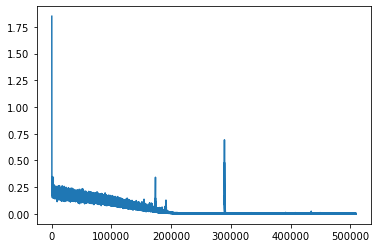

 17%|█▋        | 1682/10000 [2:24:08<11:50:53,  5.13s/it]

Loss at 520000 = 0.002685410901904106


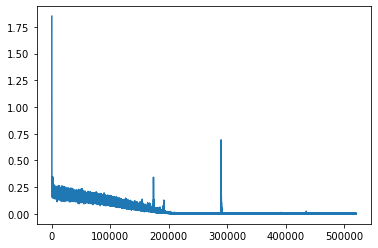

 17%|█▋        | 1715/10000 [2:26:58<11:51:51,  5.16s/it]

Loss at 530000 = 0.00019426076323725283


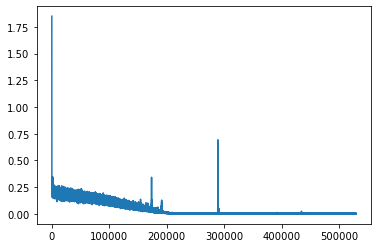

 17%|█▋        | 1747/10000 [2:29:43<11:49:31,  5.16s/it]

Loss at 540000 = 0.00018657308828551322


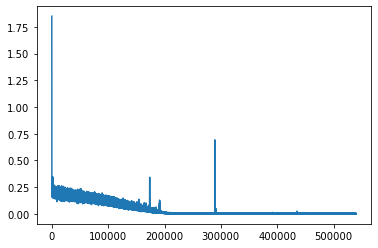

 18%|█▊        | 1779/10000 [2:32:27<11:43:06,  5.13s/it]

Loss at 550000 = 0.00029627460753545165


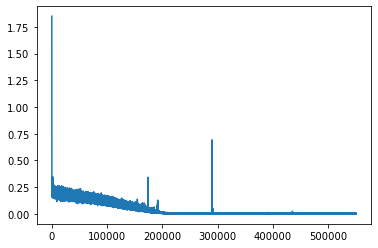

 18%|█▊        | 1812/10000 [2:35:17<11:40:32,  5.13s/it]

Loss at 560000 = 0.00022195203928276896


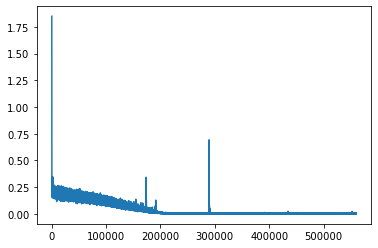

 18%|█▊        | 1844/10000 [2:38:02<11:41:32,  5.16s/it]

Loss at 570000 = 0.0002727290557231754


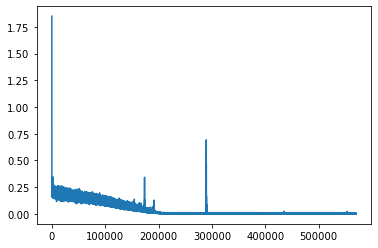

 19%|█▉        | 1877/10000 [2:40:52<11:36:42,  5.15s/it]

Loss at 580000 = 0.00017895796918310225


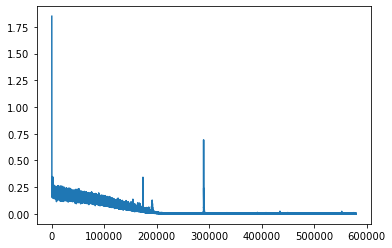

 19%|█▉        | 1909/10000 [2:43:37<11:37:26,  5.17s/it]

Loss at 590000 = 0.0001771183597156778


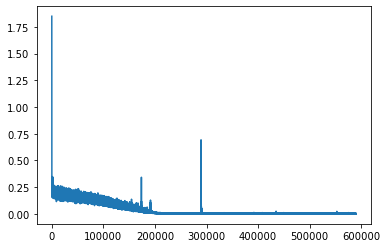

 19%|█▉        | 1941/10000 [2:46:22<11:27:56,  5.12s/it]

Loss at 600000 = 0.0001995164784602821


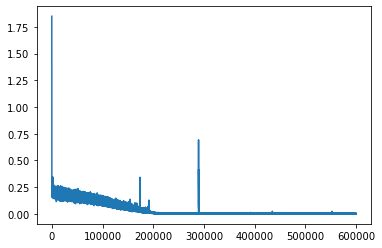

 20%|█▉        | 1974/10000 [2:49:12<11:27:16,  5.14s/it]

Loss at 610000 = 0.00014754867879673839


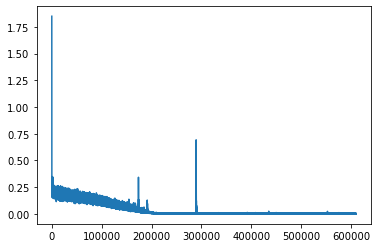

 20%|██        | 2006/10000 [2:51:56<11:24:06,  5.13s/it]

Loss at 620000 = 0.00016428773233201355


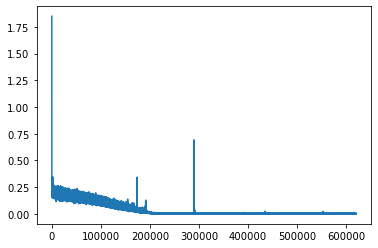

 20%|██        | 2038/10000 [2:54:41<11:20:20,  5.13s/it]

Loss at 630000 = 0.0002653960546012968


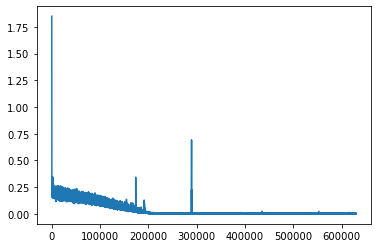

 21%|██        | 2071/10000 [2:57:31<11:17:49,  5.13s/it]

Loss at 640000 = 0.0001666601892793551


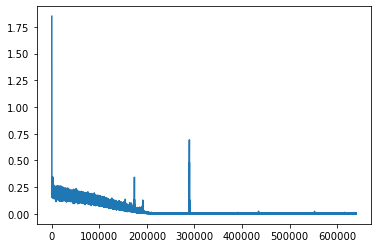

 21%|██        | 2103/10000 [3:00:15<11:15:34,  5.13s/it]

Loss at 650000 = 0.00016798073193058372


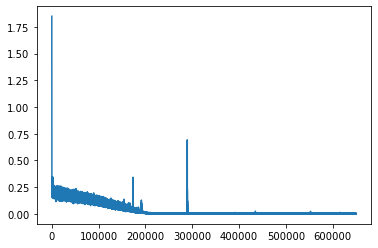

 21%|██▏       | 2135/10000 [3:03:00<11:13:35,  5.14s/it]

Loss at 660000 = 0.00014738959725946188


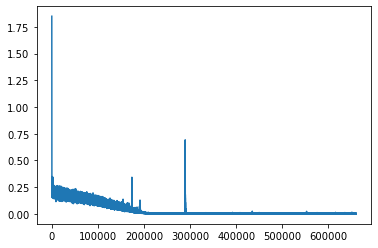

 22%|██▏       | 2168/10000 [3:05:50<11:09:45,  5.13s/it]

Loss at 670000 = 0.0001366637006867677


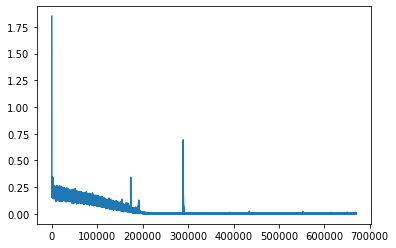

 22%|██▏       | 2200/10000 [3:08:35<11:07:39,  5.14s/it]

Loss at 680000 = 0.000270768825430423


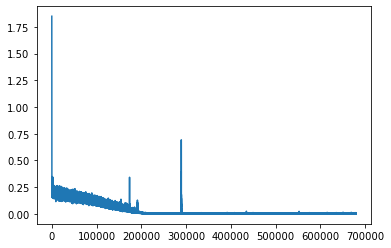

 22%|██▏       | 2233/10000 [3:11:24<11:04:40,  5.13s/it]

Loss at 690000 = 0.00013493177539203316


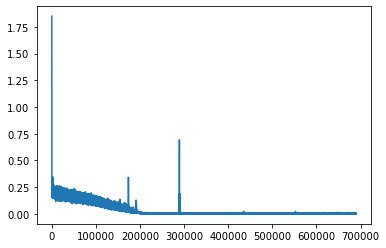

 23%|██▎       | 2265/10000 [3:14:09<11:04:59,  5.16s/it]

Loss at 700000 = 0.00017267533985432237


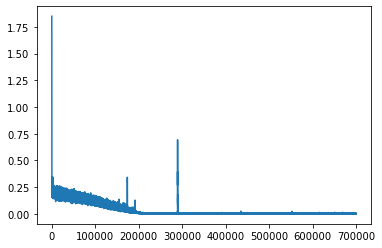

 23%|██▎       | 2297/10000 [3:16:55<11:10:31,  5.22s/it]

Loss at 710000 = 0.0001157696169684641


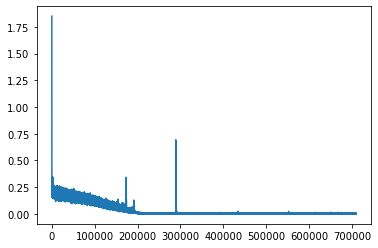

 23%|██▎       | 2330/10000 [3:19:49<11:03:41,  5.19s/it]

Loss at 720000 = 0.00019096270261798054


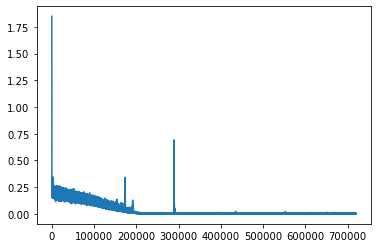

 24%|██▎       | 2362/10000 [3:22:34<10:59:43,  5.18s/it]

Loss at 730000 = 0.00011830189760075882


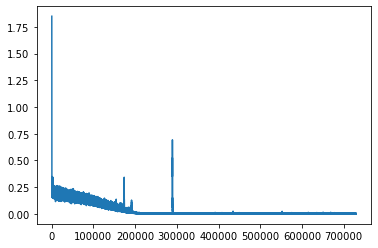

 24%|██▍       | 2394/10000 [3:25:20<10:53:04,  5.15s/it]

Loss at 740000 = 0.00015253877791110426


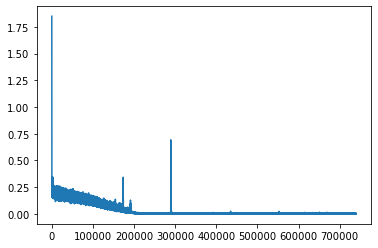

 24%|██▍       | 2427/10000 [3:28:10<10:49:07,  5.14s/it]

Loss at 750000 = 0.000603577122092247


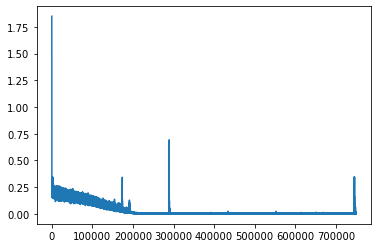

 25%|██▍       | 2459/10000 [3:30:55<10:49:14,  5.17s/it]

Loss at 760000 = 0.00020872236927971244


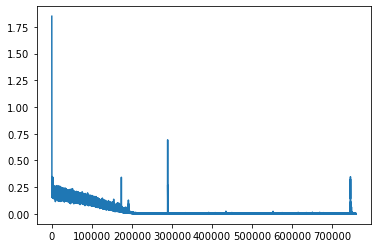

 25%|██▍       | 2491/10000 [3:33:41<10:43:52,  5.14s/it]

Loss at 770000 = 0.00018509461369831115


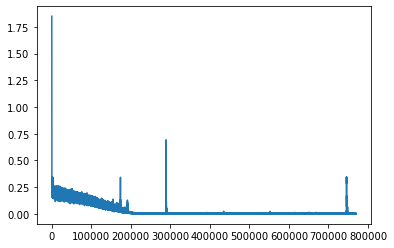

 25%|██▌       | 2524/10000 [3:36:31<10:38:36,  5.13s/it]

Loss at 780000 = 8.576515392633155e-05


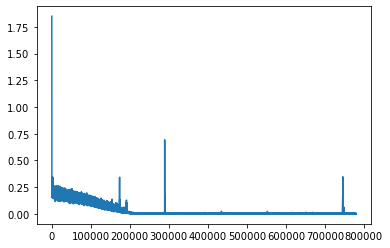

 26%|██▌       | 2556/10000 [3:39:16<10:36:55,  5.13s/it]

Loss at 790000 = 0.0002066195011138916


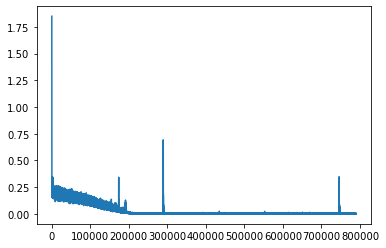

 26%|██▌       | 2588/10000 [3:42:01<10:33:34,  5.13s/it]

Loss at 800000 = 0.00016927911201491952


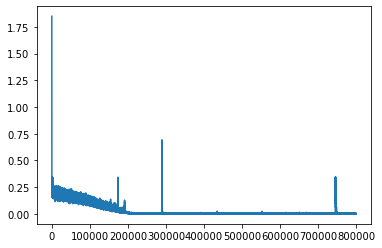

 26%|██▌       | 2621/10000 [3:44:51<10:32:28,  5.14s/it]

Loss at 810000 = 0.00014090296463109553


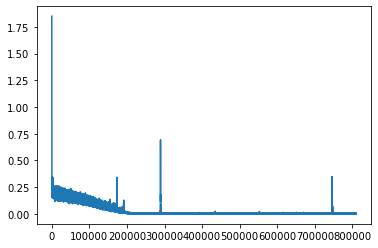

 27%|██▋       | 2653/10000 [3:47:35<10:26:34,  5.12s/it]

Loss at 820000 = 0.00022231662296690047


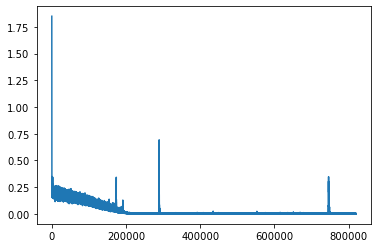

 27%|██▋       | 2686/10000 [3:50:25<10:27:01,  5.14s/it]

Loss at 830000 = 0.00014833516615908593


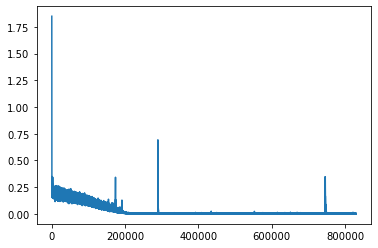

 27%|██▋       | 2718/10000 [3:53:10<10:23:16,  5.14s/it]

Loss at 840000 = 0.00011336921306792647


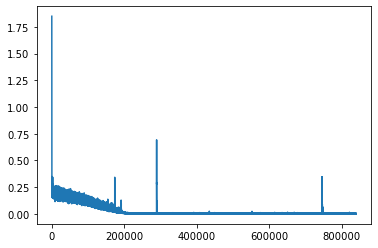

 28%|██▊       | 2750/10000 [3:55:55<10:23:26,  5.16s/it]

Loss at 850000 = 0.00012271487503312528


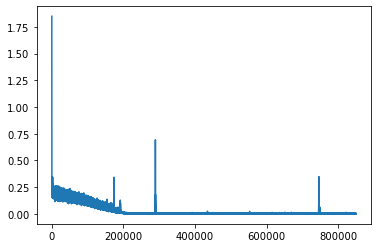

 28%|██▊       | 2783/10000 [3:58:45<10:17:38,  5.13s/it]

Loss at 860000 = 0.0034865797497332096


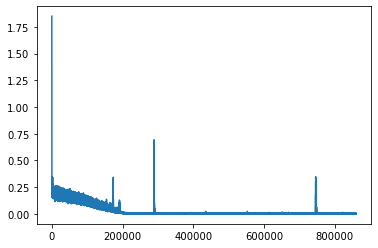

 28%|██▊       | 2815/10000 [4:01:30<10:15:42,  5.14s/it]

Loss at 870000 = 0.00013285322347655892


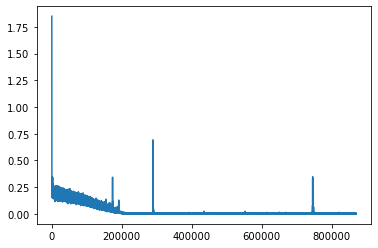

 28%|██▊       | 2847/10000 [4:04:15<10:12:38,  5.14s/it]

Loss at 880000 = 0.00014466965512838215


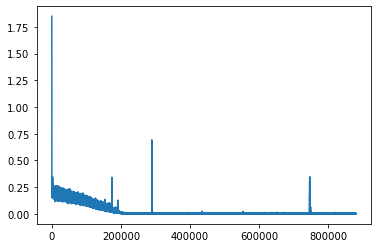

 29%|██▉       | 2880/10000 [4:07:05<10:09:13,  5.13s/it]

Loss at 890000 = 0.00010239547555102035


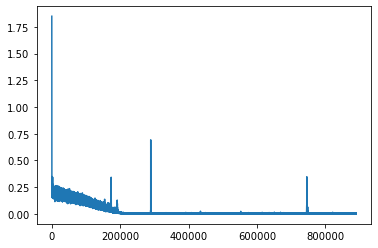

 29%|██▉       | 2912/10000 [4:09:57<11:27:45,  5.82s/it]

Loss at 900000 = 9.325917199021205e-05


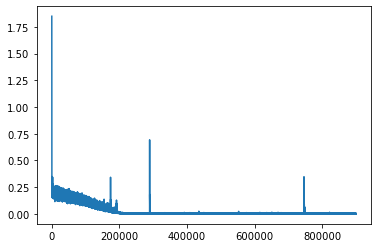

 29%|██▉       | 2944/10000 [4:13:05<11:28:07,  5.85s/it]

Loss at 910000 = 0.00013503384252544492


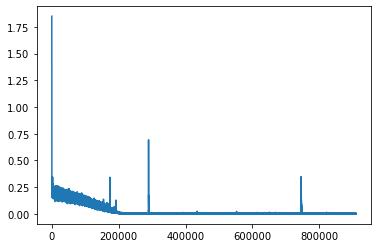

 30%|██▉       | 2977/10000 [4:16:20<11:23:44,  5.84s/it]

Loss at 920000 = 9.419117122888565e-05


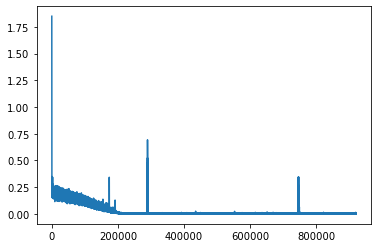

 30%|███       | 3009/10000 [4:19:28<11:18:20,  5.82s/it]

Loss at 930000 = 9.186576789943501e-05


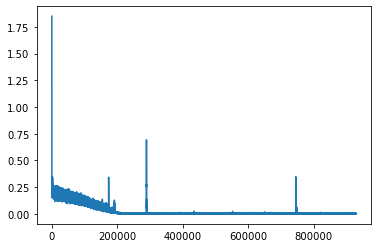

 30%|███       | 3042/10000 [4:22:41<11:16:28,  5.83s/it]

Loss at 940000 = 0.00015010213246569037


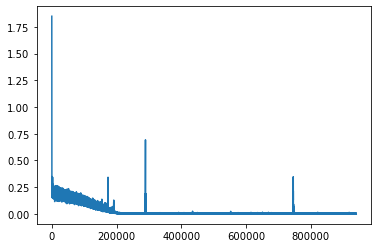

 31%|███       | 3074/10000 [4:25:48<11:12:48,  5.83s/it]

Loss at 950000 = 0.00010545051918597892


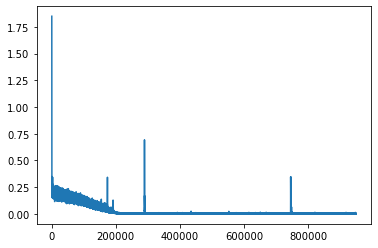

 31%|███       | 3106/10000 [4:28:55<11:10:43,  5.84s/it]

Loss at 960000 = 0.0001101762754842639


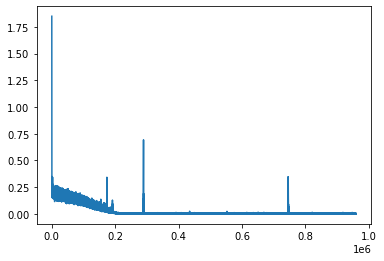

 31%|███▏      | 3139/10000 [4:32:08<11:07:21,  5.84s/it]

Loss at 970000 = 0.000187075391295366


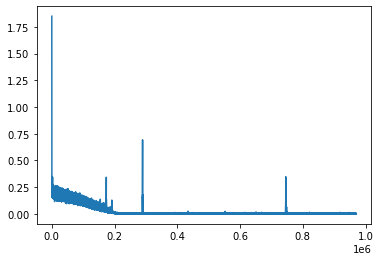

 32%|███▏      | 3171/10000 [4:35:06<9:44:34,  5.14s/it] 

Loss at 980000 = 0.000139226031024009


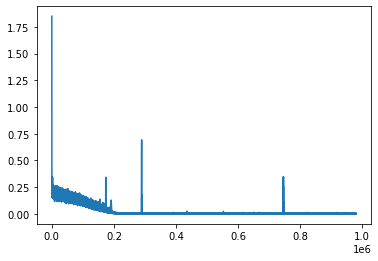

 32%|███▏      | 3203/10000 [4:37:51<9:42:23,  5.14s/it] 

Loss at 990000 = 0.00010287007899023592


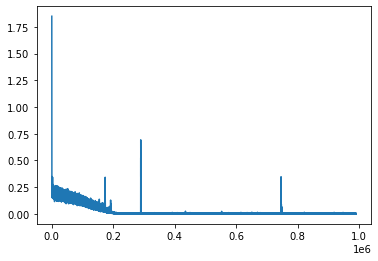

 32%|███▏      | 3236/10000 [4:40:42<9:45:34,  5.19s/it]

Loss at 1000000 = 8.138186240103096e-05


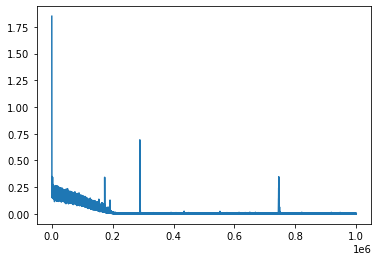

 33%|███▎      | 3268/10000 [4:43:27<9:35:27,  5.13s/it]

Loss at 1010000 = 6.893191311974078e-05


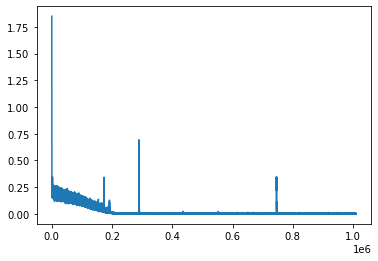

 33%|███▎      | 3300/10000 [4:46:13<9:41:46,  5.21s/it]

Loss at 1020000 = 8.293728024000302e-05


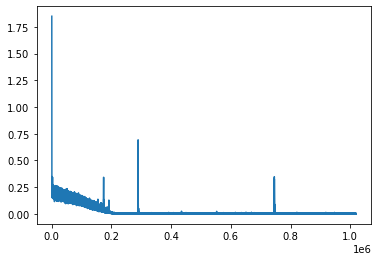

 33%|███▎      | 3333/10000 [4:49:03<9:33:04,  5.16s/it]

Loss at 1030000 = 8.960565901361406e-05


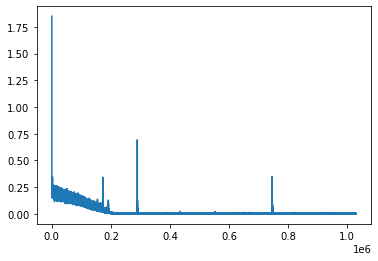

 34%|███▎      | 3365/10000 [4:51:48<9:30:03,  5.15s/it]

Loss at 1040000 = 7.246069435495883e-05


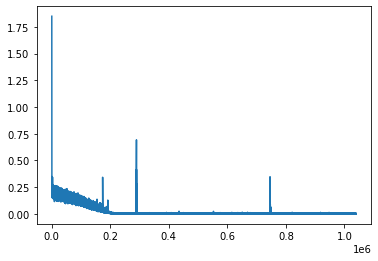

 34%|███▍      | 3398/10000 [4:54:39<9:28:12,  5.16s/it]

Loss at 1050000 = 0.00011845477274619043


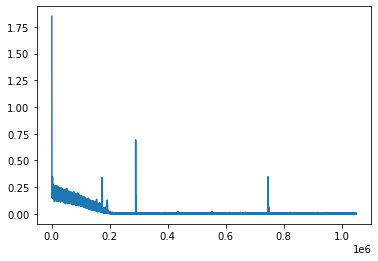

 34%|███▍      | 3430/10000 [4:57:24<9:22:28,  5.14s/it]

Loss at 1060000 = 6.695656338706613e-05


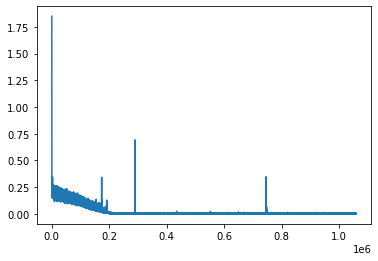

 35%|███▍      | 3462/10000 [5:00:09<9:22:06,  5.16s/it]

Loss at 1070000 = 0.00010054359881905839


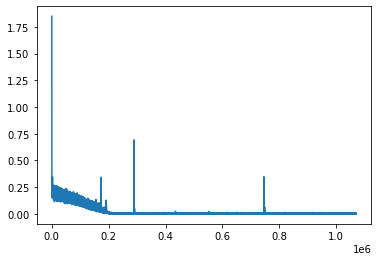

 35%|███▍      | 3495/10000 [5:03:00<9:18:41,  5.15s/it]

Loss at 1080000 = 7.723871385678649e-05


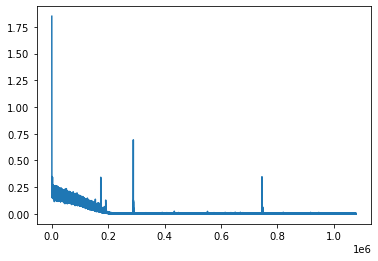

 35%|███▌      | 3527/10000 [5:05:45<9:15:09,  5.15s/it]

Loss at 1090000 = 0.00010602616384858266


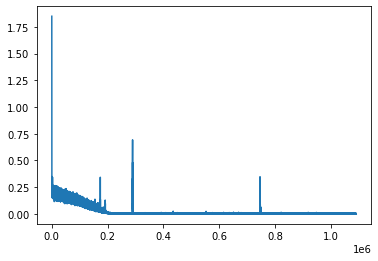

 36%|███▌      | 3559/10000 [5:08:31<9:16:55,  5.19s/it]

Loss at 1100000 = 0.00011356346658430994


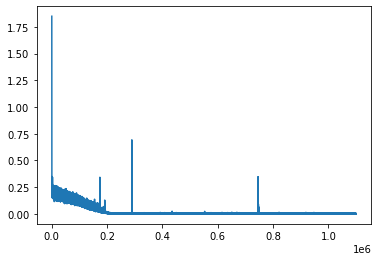

 36%|███▌      | 3592/10000 [5:11:21<9:10:05,  5.15s/it]

Loss at 1110000 = 0.0028057240415364504


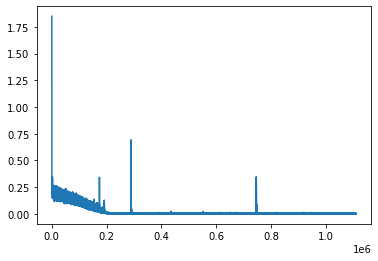

 36%|███▌      | 3624/10000 [5:14:07<9:08:27,  5.16s/it]

Loss at 1120000 = 8.815681940177456e-05


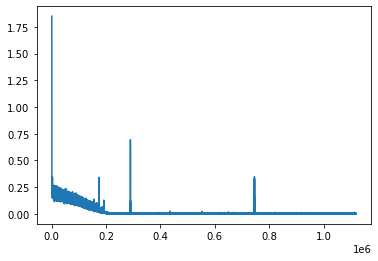

 37%|███▋      | 3656/10000 [5:16:53<9:06:56,  5.17s/it]

Loss at 1130000 = 8.576664549764246e-05


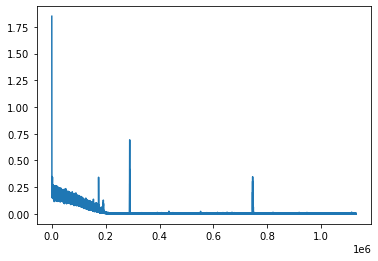

 37%|███▋      | 3689/10000 [5:19:43<9:00:44,  5.14s/it]

Loss at 1140000 = 6.468305218731984e-05


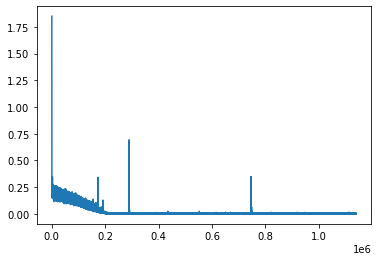

 37%|███▋      | 3721/10000 [5:22:29<8:56:05,  5.12s/it]

Loss at 1150000 = 9.771146869752556e-05


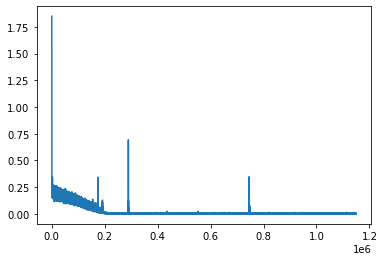

 38%|███▊      | 3754/10000 [5:25:20<9:01:38,  5.20s/it]

Loss at 1160000 = 0.00011762599751818925


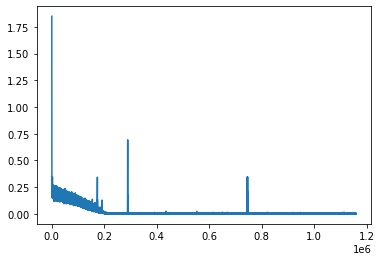

 38%|███▊      | 3786/10000 [5:28:06<8:57:46,  5.19s/it]

Loss at 1170000 = 7.420236215693876e-05


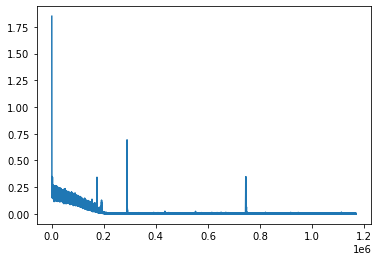

 38%|███▊      | 3818/10000 [5:30:52<8:54:12,  5.18s/it]

Loss at 1180000 = 6.41135047771968e-05


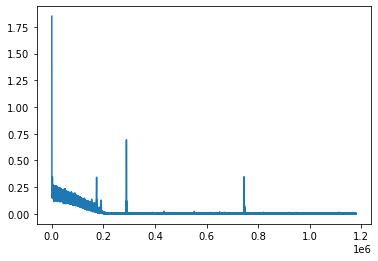

 39%|███▊      | 3851/10000 [5:33:44<8:52:25,  5.20s/it]

Loss at 1190000 = 0.004075102973729372


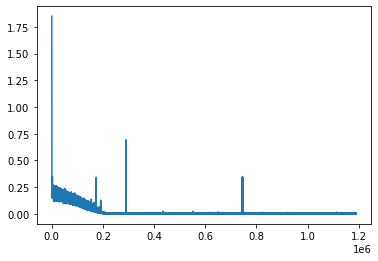

 39%|███▉      | 3883/10000 [5:36:46<10:01:25,  5.90s/it]

Loss at 1200000 = 7.522339001297951e-05


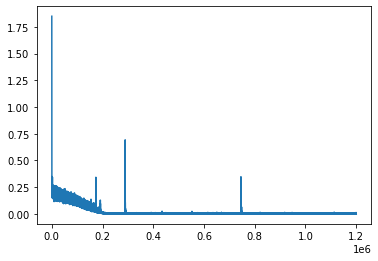

 39%|███▉      | 3915/10000 [5:39:55<9:58:42,  5.90s/it] 

Loss at 1210000 = 7.92172213550657e-05


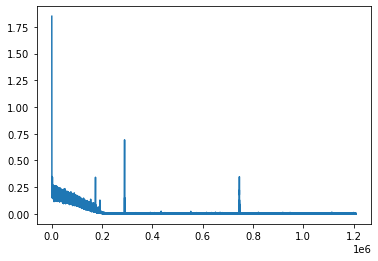

 39%|███▉      | 3948/10000 [5:43:10<9:53:08,  5.88s/it] 

Loss at 1220000 = 6.422441947506741e-05


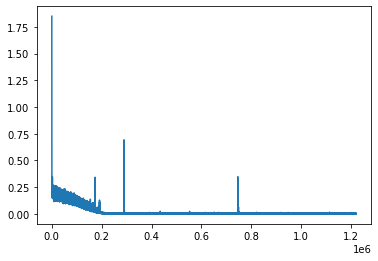

 40%|███▉      | 3980/10000 [5:46:20<9:55:50,  5.94s/it] 

Loss at 1230000 = 7.624832505825907e-05


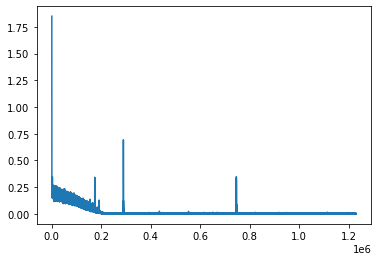

 40%|████      | 4012/10000 [5:49:29<9:48:46,  5.90s/it] 

Loss at 1240000 = 7.151283352868631e-05


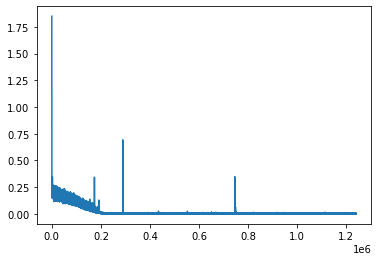

 40%|████      | 4045/10000 [5:52:44<9:45:47,  5.90s/it]

Loss at 1250000 = 6.852419028291479e-05


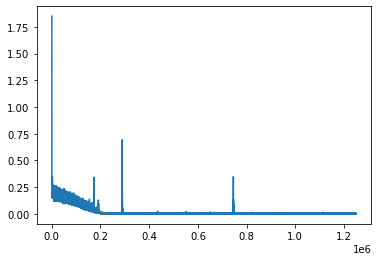

 41%|████      | 4077/10000 [5:55:54<9:43:52,  5.91s/it]

Loss at 1260000 = 5.424341361504048e-05


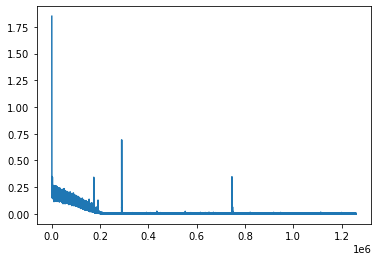

 41%|████      | 4110/10000 [5:59:09<9:40:55,  5.92s/it]

Loss at 1270000 = 0.0001412825658917427


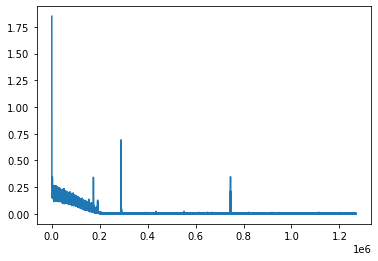

 41%|████▏     | 4142/10000 [6:02:06<8:35:21,  5.28s/it]

Loss at 1280000 = 6.953885167604312e-05


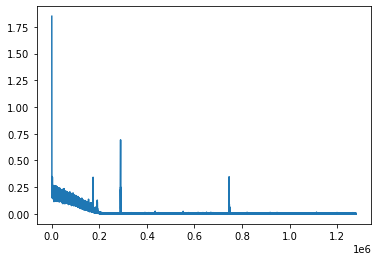

 42%|████▏     | 4174/10000 [6:04:54<8:24:43,  5.20s/it]

Loss at 1290000 = 5.773511293227784e-05


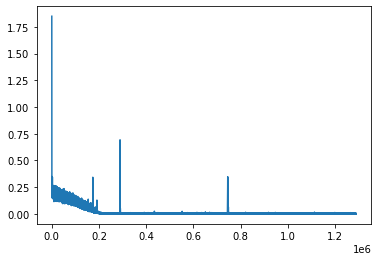

 42%|████▏     | 4207/10000 [6:08:03<9:31:33,  5.92s/it]

Loss at 1300000 = 6.240887159947306e-05


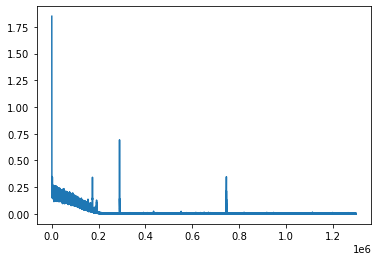

 42%|████▏     | 4239/10000 [6:11:13<9:28:07,  5.92s/it]

Loss at 1310000 = 0.00010011178528657183


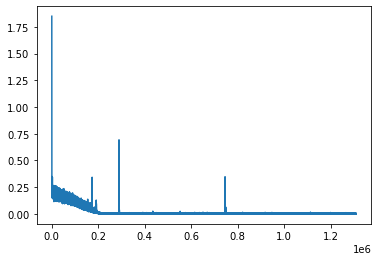

 43%|████▎     | 4271/10000 [6:14:23<9:25:06,  5.92s/it]

Loss at 1320000 = 0.00011980890849372372


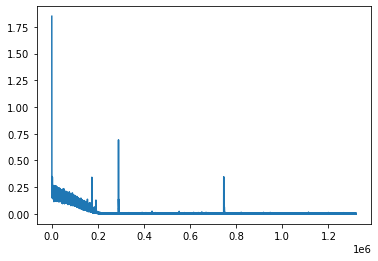

 43%|████▎     | 4304/10000 [6:17:40<9:22:13,  5.92s/it]

Loss at 1330000 = 5.8320456446381286e-05


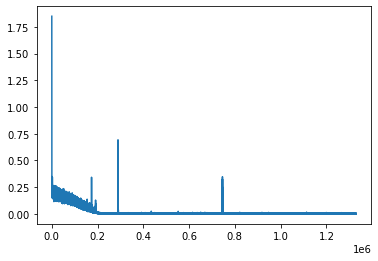

 43%|████▎     | 4336/10000 [6:20:50<9:17:14,  5.90s/it]

Loss at 1340000 = 5.83473956794478e-05


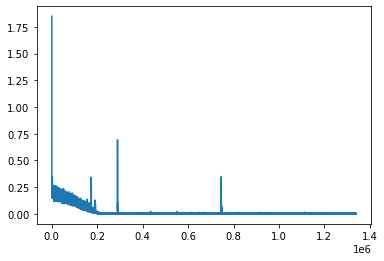

 44%|████▎     | 4368/10000 [6:23:59<9:15:14,  5.92s/it]

Loss at 1350000 = 5.110172423883341e-05


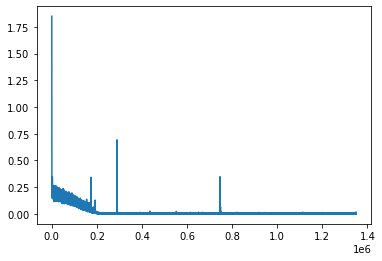

 44%|████▍     | 4401/10000 [6:27:15<9:10:31,  5.90s/it]

Loss at 1360000 = 5.017308649257757e-05


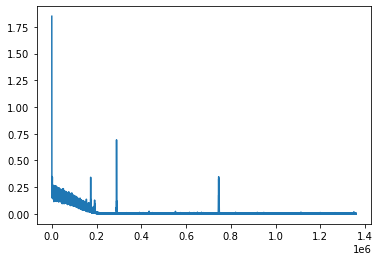

 44%|████▍     | 4433/10000 [6:30:25<9:08:58,  5.92s/it]

Loss at 1370000 = 7.448461838066578e-05


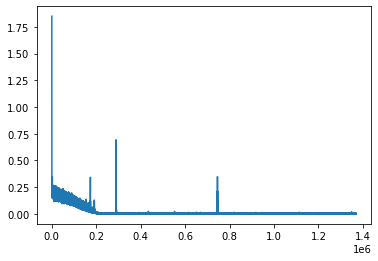

 45%|████▍     | 4466/10000 [6:33:41<9:05:14,  5.91s/it]

Loss at 1380000 = 6.411846698028967e-05


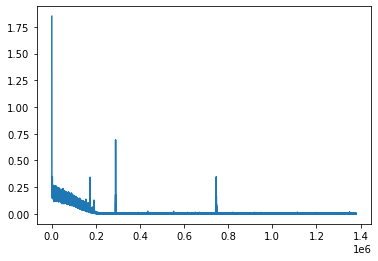

 45%|████▍     | 4498/10000 [6:36:41<7:57:44,  5.21s/it]

Loss at 1390000 = 9.829430928220972e-05


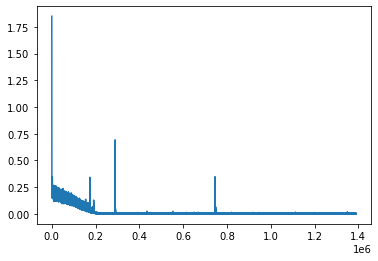

 45%|████▌     | 4530/10000 [6:39:29<7:58:35,  5.25s/it]

Loss at 1400000 = 9.459146531298757e-05


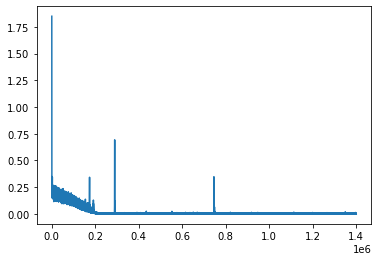

 46%|████▌     | 4563/10000 [6:42:23<7:56:00,  5.25s/it]

Loss at 1410000 = 7.624832505825907e-05


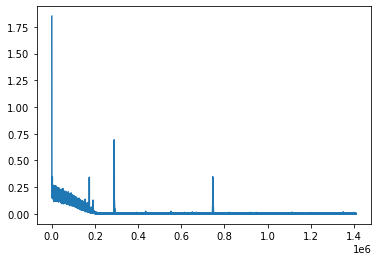

 46%|████▌     | 4595/10000 [6:45:12<7:55:33,  5.28s/it]

Loss at 1420000 = 5.7506957091391087e-05


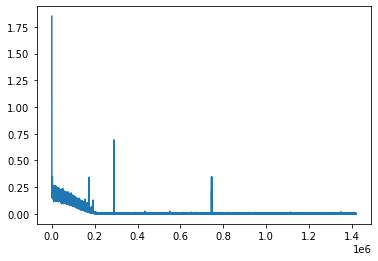

 46%|████▋     | 4627/10000 [6:48:01<7:59:30,  5.35s/it]

Loss at 1430000 = 5.7864592236001045e-05


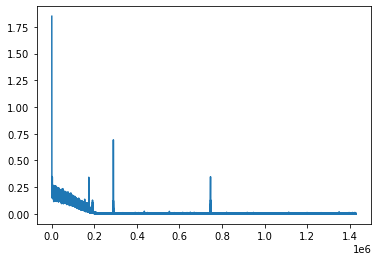

 47%|████▋     | 4660/10000 [6:50:55<7:51:23,  5.30s/it]

Loss at 1440000 = 7.573918992420658e-05


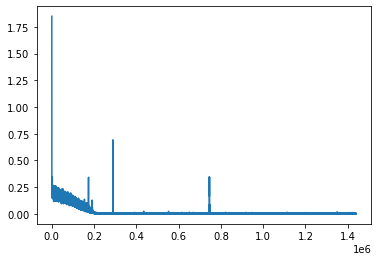

 47%|████▋     | 4692/10000 [6:53:44<7:52:05,  5.34s/it]

Loss at 1450000 = 6.753717025276273e-05


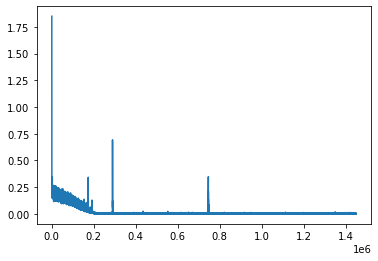

 47%|████▋     | 4724/10000 [6:56:36<7:44:18,  5.28s/it]

Loss at 1460000 = 9.144984505837783e-05


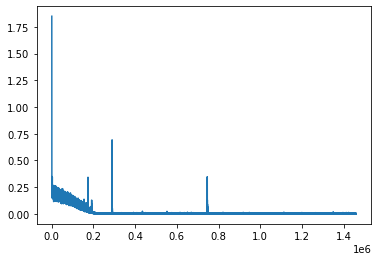

 48%|████▊     | 4757/10000 [6:59:29<7:37:36,  5.24s/it]

Loss at 1470000 = 6.03603184572421e-05


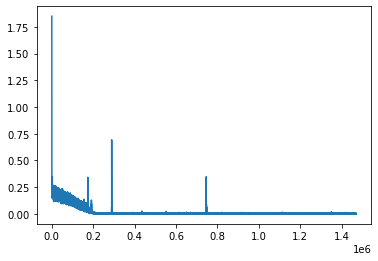

 48%|████▊     | 4789/10000 [7:02:18<7:38:11,  5.28s/it]

Loss at 1480000 = 5.0708302296698093e-05


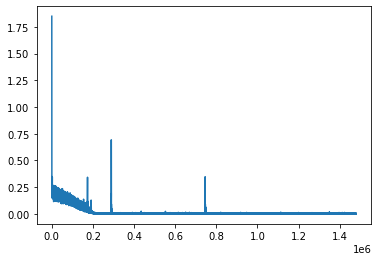

 48%|████▊     | 4822/10000 [7:05:12<7:30:57,  5.23s/it]

Loss at 1490000 = 7.48542370274663e-05


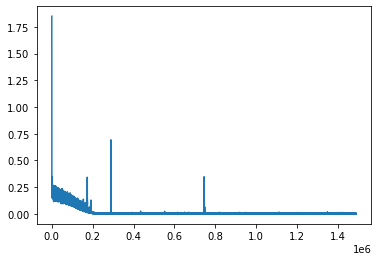

 49%|████▊     | 4854/10000 [7:08:01<7:35:33,  5.31s/it]

Loss at 1500000 = 5.180154767003842e-05


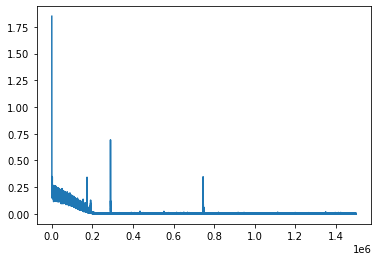

 49%|████▉     | 4886/10000 [7:10:50<7:28:43,  5.26s/it]

Loss at 1510000 = 5.211541065364145e-05


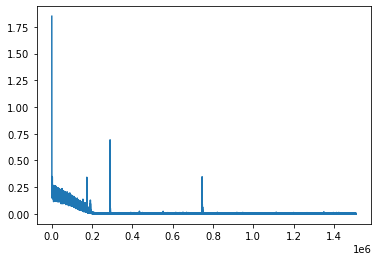

 49%|████▉     | 4919/10000 [7:13:43<7:26:44,  5.28s/it]

Loss at 1520000 = 6.912830576766282e-05


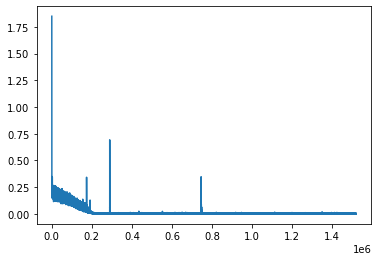

 50%|████▉     | 4951/10000 [7:16:33<7:32:27,  5.38s/it]

Loss at 1530000 = 5.1818336942233145e-05


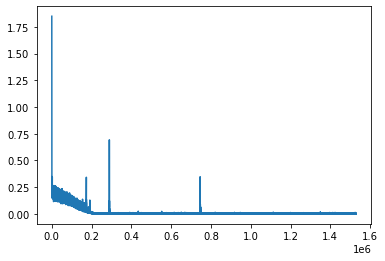

 50%|████▉     | 4983/10000 [7:19:22<7:15:50,  5.21s/it]

Loss at 1540000 = 8.445366256637499e-05


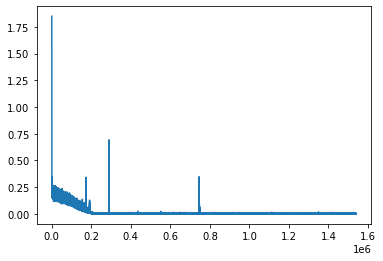

 50%|█████     | 5016/10000 [7:22:16<7:15:19,  5.24s/it]

Loss at 1550000 = 0.003945301752537489


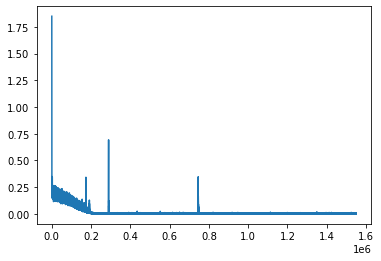

 50%|█████     | 5048/10000 [7:25:06<7:19:47,  5.33s/it]

Loss at 1560000 = 7.493528391933069e-05


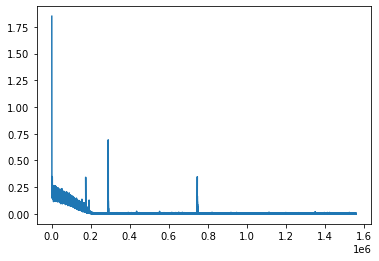

 51%|█████     | 5080/10000 [7:27:55<7:09:52,  5.24s/it]

Loss at 1570000 = 6.614953599637374e-05


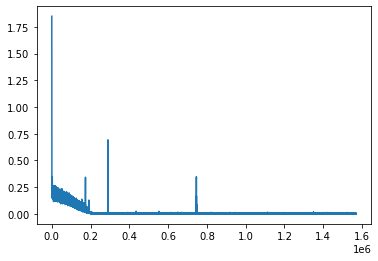

 51%|█████     | 5113/10000 [7:30:50<7:18:55,  5.39s/it]

Loss at 1580000 = 4.0881572203943506e-05


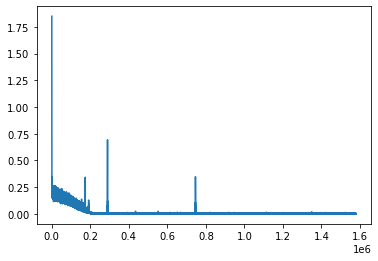

 51%|█████▏    | 5145/10000 [7:33:40<7:07:01,  5.28s/it]

Loss at 1590000 = 6.644466338912025e-05


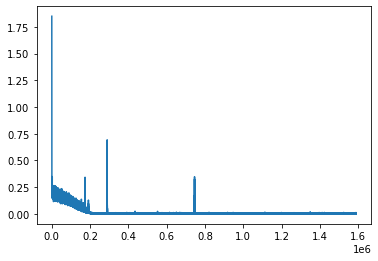

 52%|█████▏    | 5177/10000 [7:36:30<7:05:05,  5.29s/it]

Loss at 1600000 = 5.4749183618696406e-05


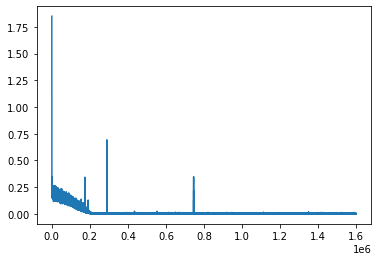

 52%|█████▏    | 5210/10000 [7:39:24<6:59:35,  5.26s/it]

Loss at 1610000 = 5.5441421864088625e-05


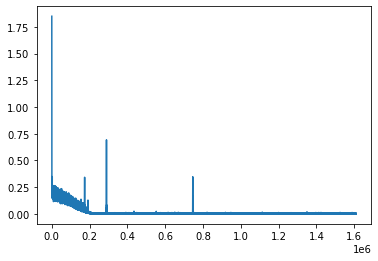

 52%|█████▏    | 5242/10000 [7:42:14<7:00:33,  5.30s/it]

Loss at 1620000 = 4.7532452299492434e-05


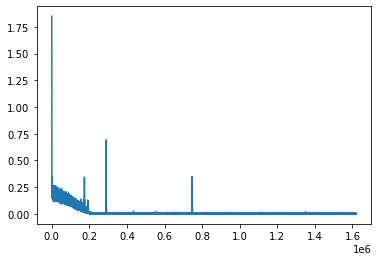

 53%|█████▎    | 5275/10000 [7:45:09<6:52:07,  5.23s/it]

Loss at 1630000 = 6.770767504349351e-05


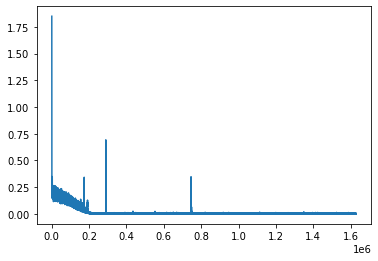

 53%|█████▎    | 5307/10000 [7:47:58<6:54:41,  5.30s/it]

Loss at 1640000 = 7.418923632940277e-05


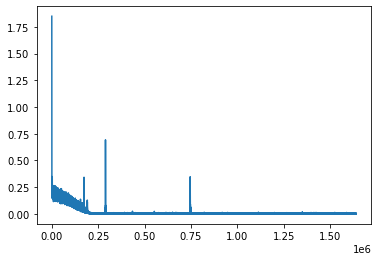

 53%|█████▎    | 5339/10000 [7:50:48<6:50:16,  5.28s/it]

Loss at 1650000 = 5.0614344218047336e-05


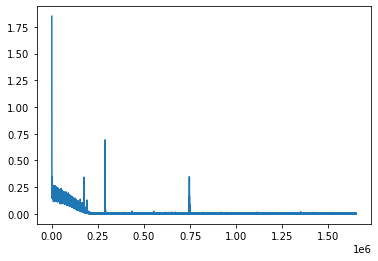

 54%|█████▎    | 5372/10000 [7:53:44<6:50:54,  5.33s/it]

Loss at 1660000 = 5.4820324294269085e-05


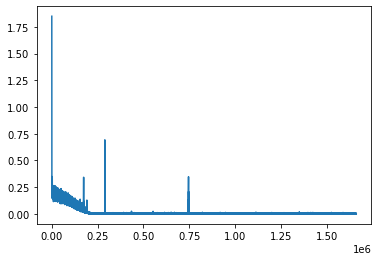

 54%|█████▍    | 5404/10000 [7:56:35<6:45:19,  5.29s/it]

Loss at 1670000 = 3.7897549191256985e-05


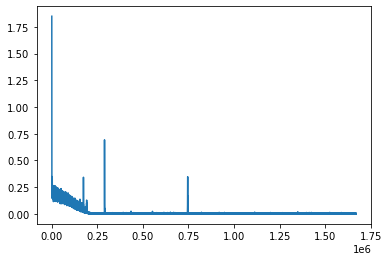

 54%|█████▍    | 5436/10000 [7:59:25<6:45:49,  5.34s/it]

Loss at 1680000 = 9.234243771061301e-05


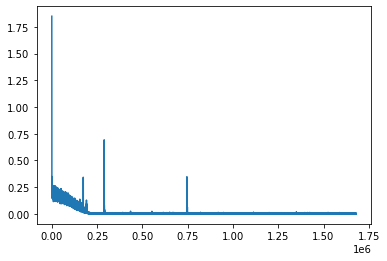

 55%|█████▍    | 5469/10000 [8:02:21<6:40:18,  5.30s/it]

Loss at 1690000 = 4.5973516535013914e-05


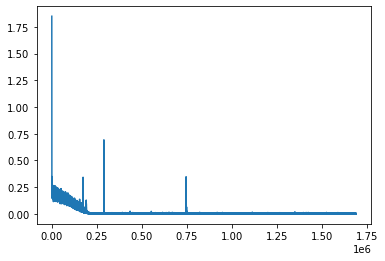

 55%|█████▌    | 5501/10000 [8:05:12<6:34:46,  5.26s/it]

Loss at 1700000 = 5.5362637795042247e-05


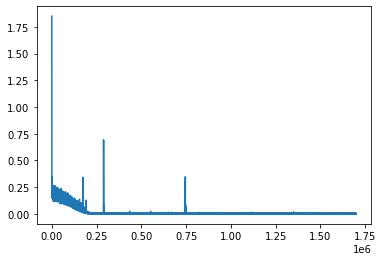

 55%|█████▌    | 5533/10000 [8:08:03<6:37:06,  5.33s/it]

Loss at 1710000 = 4.2933512304443866e-05


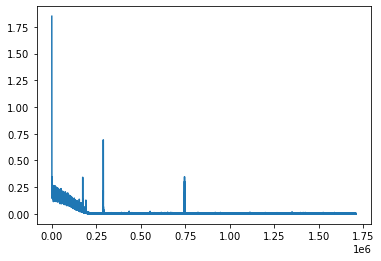

 56%|█████▌    | 5566/10000 [8:10:59<6:34:30,  5.34s/it]

Loss at 1720000 = 4.833738421439193e-05


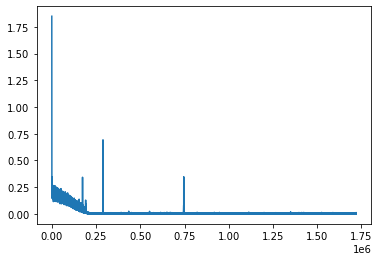

 56%|█████▌    | 5598/10000 [8:13:49<6:29:48,  5.31s/it]

Loss at 1730000 = 8.619122672826052e-05


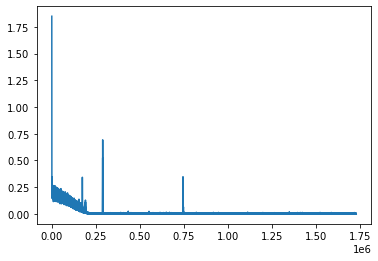

 56%|█████▋    | 5631/10000 [8:16:45<6:23:06,  5.26s/it]

Loss at 1740000 = 5.0883125368272886e-05


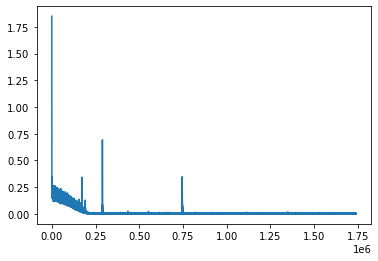

 57%|█████▋    | 5663/10000 [8:19:36<6:24:23,  5.32s/it]

Loss at 1750000 = 4.191626430838369e-05


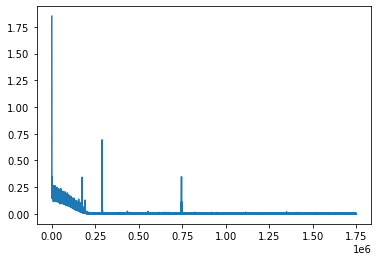

 57%|█████▋    | 5695/10000 [8:22:27<6:25:41,  5.38s/it]

Loss at 1760000 = 5.619166404358111e-05


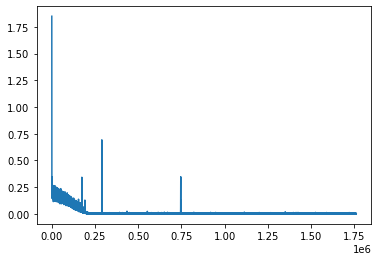

 57%|█████▋    | 5728/10000 [8:25:23<6:15:07,  5.27s/it]

Loss at 1770000 = 5.497891106642783e-05


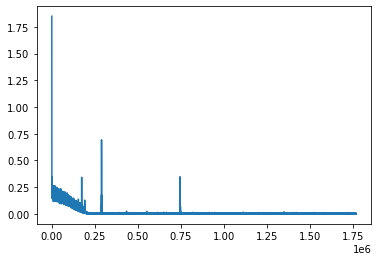

 58%|█████▊    | 5760/10000 [8:28:14<6:14:00,  5.29s/it]

Loss at 1780000 = 4.7931847802829e-05


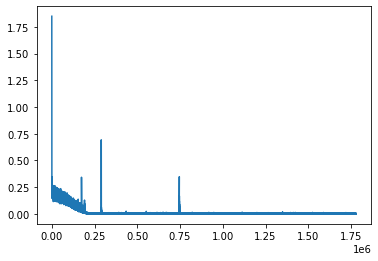

 58%|█████▊    | 5792/10000 [8:31:05<6:16:17,  5.37s/it]

Loss at 1790000 = 3.43303254339844e-05


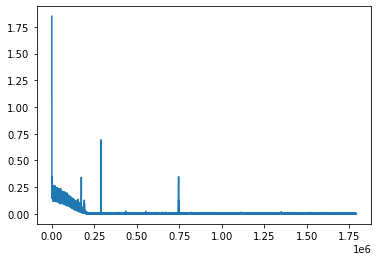

 58%|█████▊    | 5825/10000 [8:34:00<6:12:04,  5.35s/it]

Loss at 1800000 = 6.276464409893379e-05


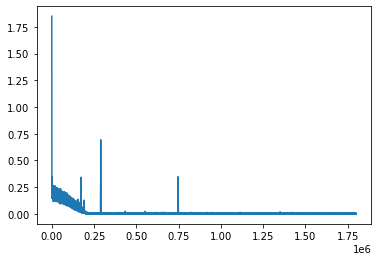

 59%|█████▊    | 5857/10000 [8:36:52<6:06:35,  5.31s/it]

Loss at 1810000 = 6.129375105956569e-05


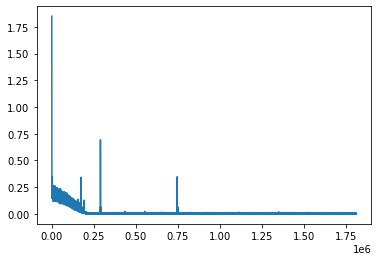

 59%|█████▉    | 5889/10000 [8:39:43<6:06:25,  5.35s/it]

Loss at 1820000 = 4.2905005102511495e-05


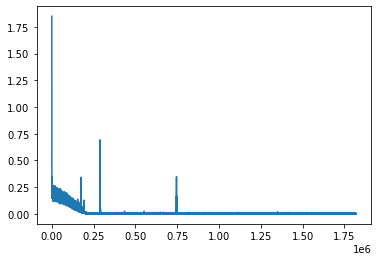

 59%|█████▉    | 5922/10000 [8:42:40<5:57:33,  5.26s/it]

Loss at 1830000 = 3.9354450564133e-05


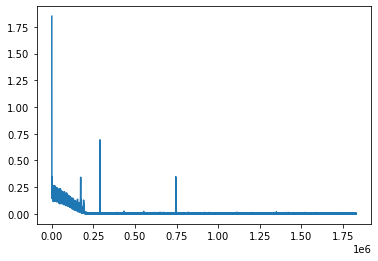

 60%|█████▉    | 5954/10000 [8:45:30<5:56:47,  5.29s/it]

Loss at 1840000 = 4.302601519157179e-05


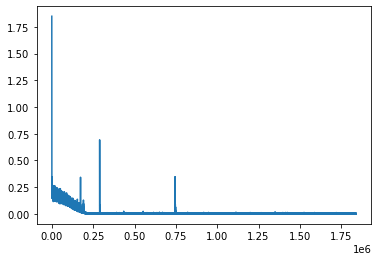

 60%|█████▉    | 5987/10000 [8:48:27<6:03:00,  5.43s/it]

Loss at 1850000 = 5.105407035443932e-05


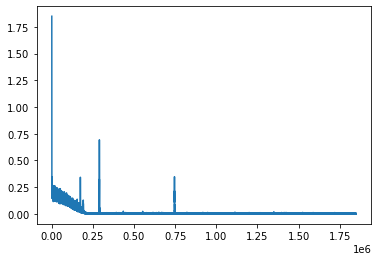

 60%|██████    | 6019/10000 [8:51:18<5:53:22,  5.33s/it]

Loss at 1860000 = 6.387796020135283e-05


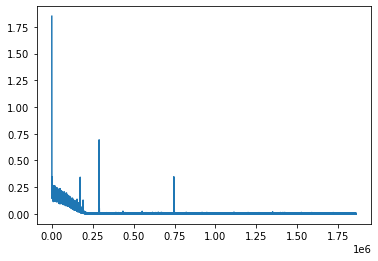

 61%|██████    | 6051/10000 [8:54:10<5:53:39,  5.37s/it]

Loss at 1870000 = 5.2476811106316745e-05


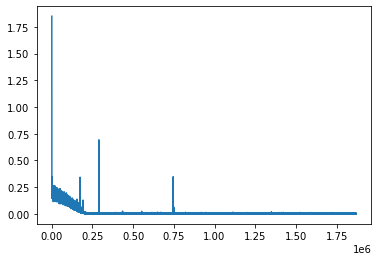

 61%|██████    | 6084/10000 [8:57:06<5:48:52,  5.35s/it]

Loss at 1880000 = 4.044785600854084e-05


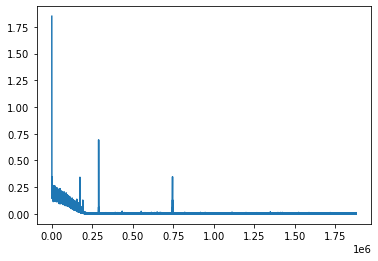

 61%|██████    | 6116/10000 [8:59:57<5:45:29,  5.34s/it]

Loss at 1890000 = 6.51682130410336e-05


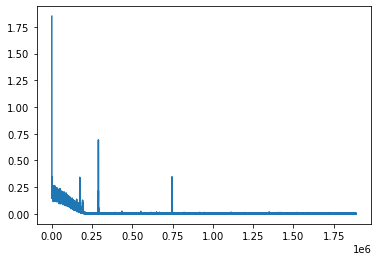

 61%|██████▏   | 6148/10000 [9:02:48<5:42:37,  5.34s/it]

Loss at 1900000 = 4.853576319874264e-05


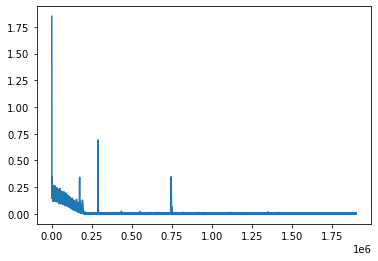

 62%|██████▏   | 6181/10000 [9:05:44<5:35:26,  5.27s/it]

Loss at 1910000 = 3.7649006117135286e-05


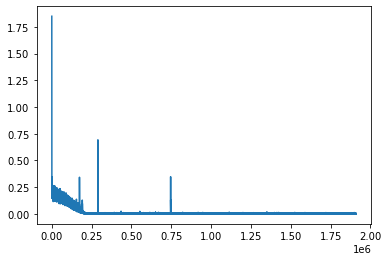

 62%|██████▏   | 6213/10000 [9:08:35<5:38:49,  5.37s/it]

Loss at 1920000 = 6.036414561094716e-05


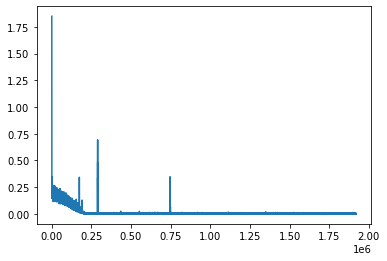

 62%|██████▏   | 6245/10000 [9:11:26<5:32:44,  5.32s/it]

Loss at 1930000 = 4.614482168108225e-05


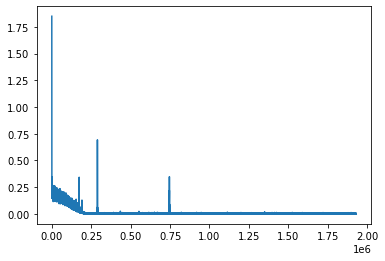

 63%|██████▎   | 6278/10000 [9:14:23<5:30:01,  5.32s/it]

Loss at 1940000 = 5.460561442305334e-05


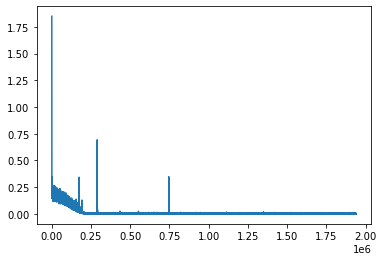

 63%|██████▎   | 6310/10000 [9:17:15<5:27:33,  5.33s/it]

Loss at 1950000 = 6.621303327847272e-05


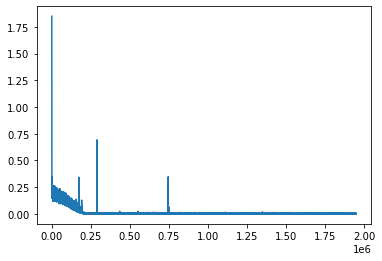

 63%|██████▎   | 6343/10000 [9:20:11<5:26:40,  5.36s/it]

Loss at 1960000 = 5.5716456699883565e-05


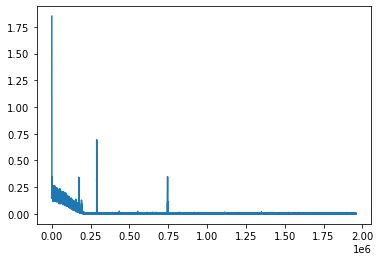

 64%|██████▍   | 6375/10000 [9:23:03<5:23:44,  5.36s/it]

Loss at 1970000 = 4.679487756220624e-05


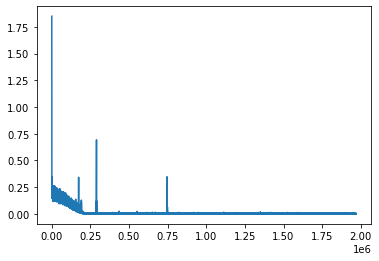

 64%|██████▍   | 6407/10000 [9:25:56<5:23:05,  5.40s/it]

Loss at 1980000 = 3.3218006137758493e-05


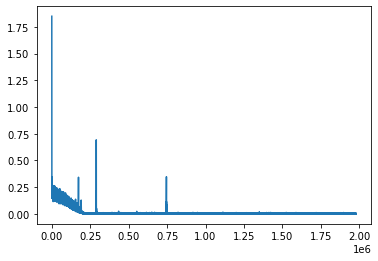

 64%|██████▍   | 6440/10000 [9:28:52<5:14:12,  5.30s/it]

Loss at 1990000 = 3.754989302251488e-05


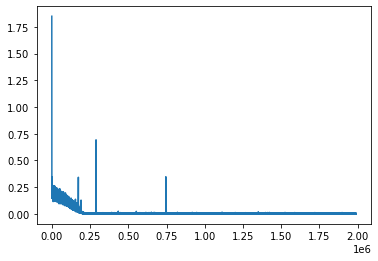

 65%|██████▍   | 6472/10000 [9:32:01<5:51:36,  5.98s/it]

Loss at 2000000 = 3.5327997466083616e-05


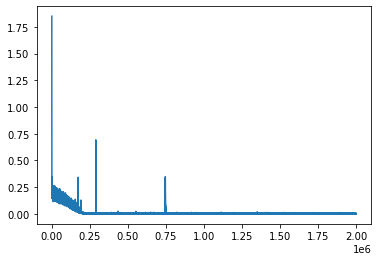

 65%|██████▌   | 6504/10000 [9:35:12<5:45:37,  5.93s/it]

Loss at 2010000 = 3.876213668263517e-05


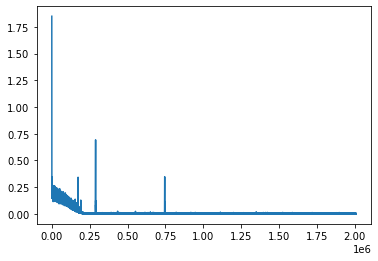

 65%|██████▌   | 6537/10000 [9:38:30<5:43:04,  5.94s/it]

Loss at 2020000 = 4.565925701172091e-05


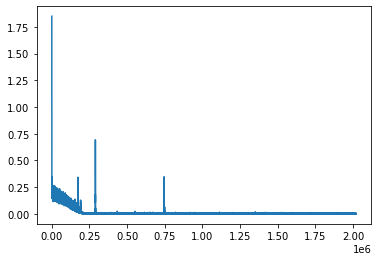

 66%|██████▌   | 6569/10000 [9:41:41<5:40:03,  5.95s/it]

Loss at 2030000 = 3.5011034924536943e-05


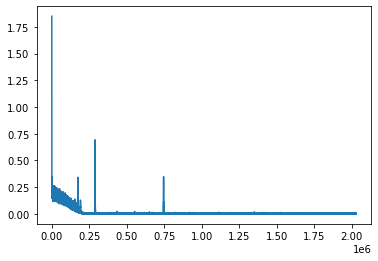

 66%|██████▌   | 6601/10000 [9:44:52<5:36:10,  5.93s/it]

Loss at 2040000 = 3.9429301978088915e-05


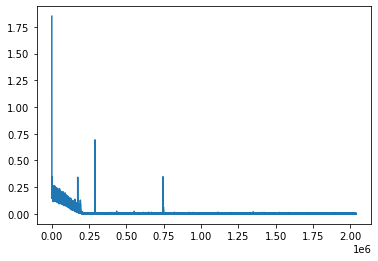

 66%|██████▋   | 6634/10000 [9:48:00<4:51:18,  5.19s/it]

Loss at 2050000 = 4.997904761694372e-05


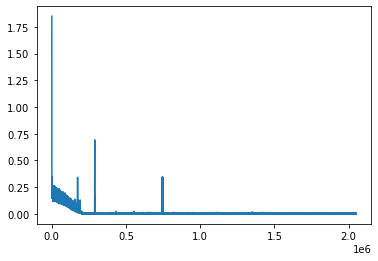

 67%|██████▋   | 6666/10000 [9:51:09<5:28:50,  5.92s/it]

Loss at 2060000 = 3.494675547699444e-05


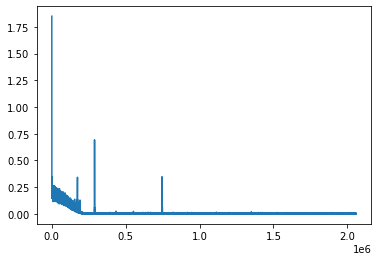

 67%|██████▋   | 6699/10000 [9:54:18<5:03:58,  5.53s/it]

Loss at 2070000 = 6.25525281066075e-05


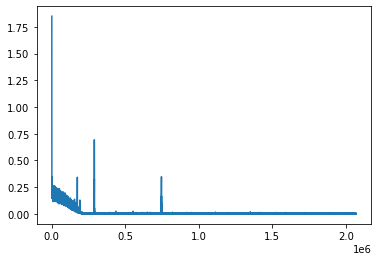

 67%|██████▋   | 6731/10000 [9:57:17<5:17:34,  5.83s/it]

Loss at 2080000 = 3.9464877772843465e-05


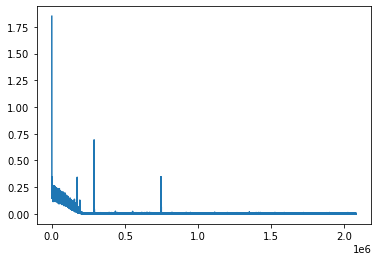

 68%|██████▊   | 6763/10000 [10:00:28<5:30:24,  6.12s/it]

Loss at 2090000 = 3.3252930734306574e-05


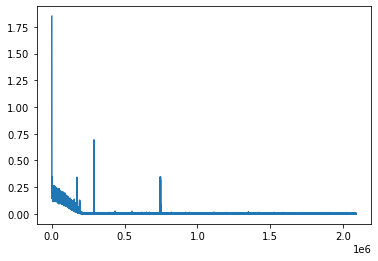

 68%|██████▊   | 6796/10000 [10:03:52<5:27:49,  6.14s/it]

Loss at 2100000 = 3.8794994907220826e-05


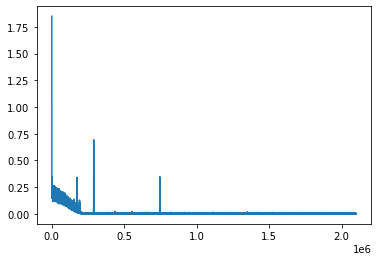

 68%|██████▊   | 6828/10000 [10:07:07<5:18:08,  6.02s/it]

Loss at 2110000 = 4.088946297997609e-05


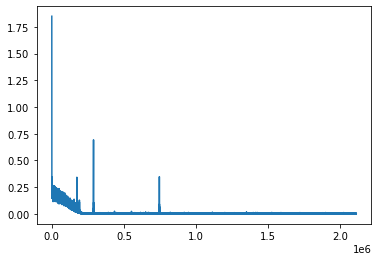

 69%|██████▊   | 6860/10000 [10:10:23<5:20:39,  6.13s/it]

Loss at 2120000 = 4.9776041123550385e-05


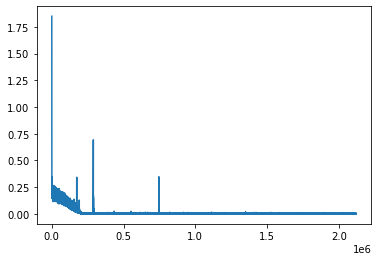

 69%|██████▉   | 6893/10000 [10:13:45<5:14:34,  6.07s/it]

Loss at 2130000 = 3.979968460043892e-05


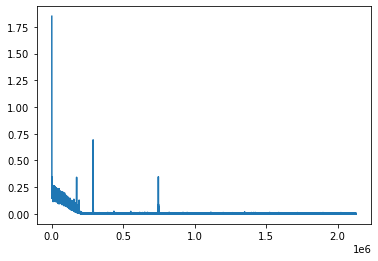

 69%|██████▉   | 6925/10000 [10:16:48<4:35:29,  5.38s/it]

Loss at 2140000 = 4.505749529926106e-05


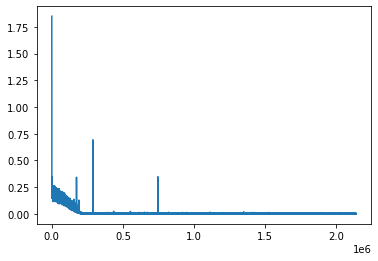

 70%|██████▉   | 6957/10000 [10:19:40<4:27:42,  5.28s/it]

Loss at 2150000 = 3.482034298940562e-05


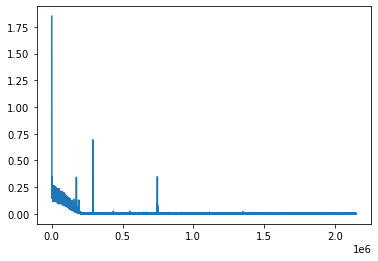

 70%|██████▉   | 6990/10000 [10:22:38<4:26:43,  5.32s/it]

Loss at 2160000 = 0.0023004868999123573


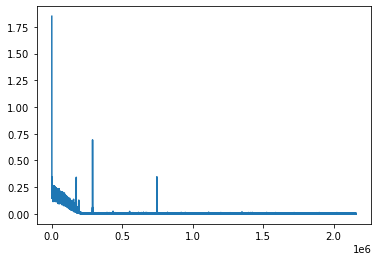

 70%|███████   | 7022/10000 [10:25:30<4:24:22,  5.33s/it]

Loss at 2170000 = 3.464445035206154e-05


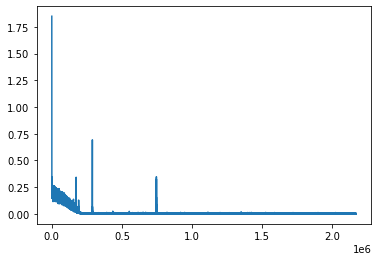

 71%|███████   | 7055/10000 [10:28:28<4:23:01,  5.36s/it]

Loss at 2180000 = 6.766839214833453e-05


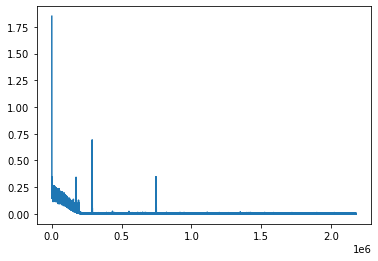

 71%|███████   | 7087/10000 [10:31:21<4:21:16,  5.38s/it]

Loss at 2190000 = 0.00012161479389760643


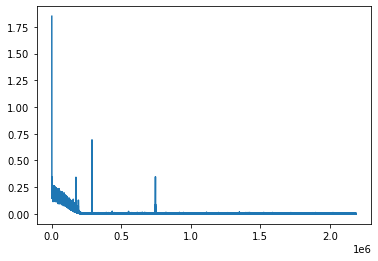

 71%|███████   | 7119/10000 [10:34:14<4:16:53,  5.35s/it]

Loss at 2200000 = 3.924642442143522e-05


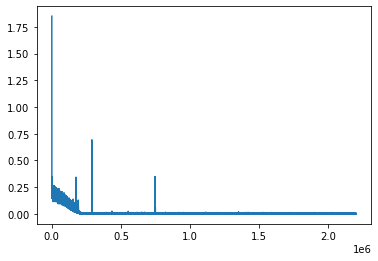

 72%|███████▏  | 7152/10000 [10:37:11<4:15:41,  5.39s/it]

Loss at 2210000 = 3.955907595809549e-05


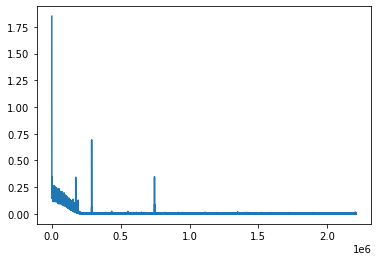

 72%|███████▏  | 7184/10000 [10:40:02<4:09:04,  5.31s/it]

Loss at 2220000 = 3.970134275732562e-05


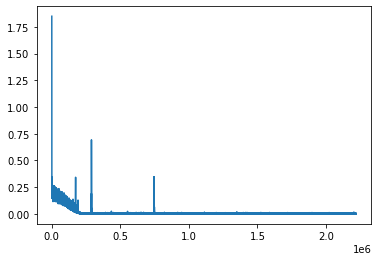

 72%|███████▏  | 7216/10000 [10:42:55<4:06:35,  5.31s/it]

Loss at 2230000 = 2.8155665859230794e-05


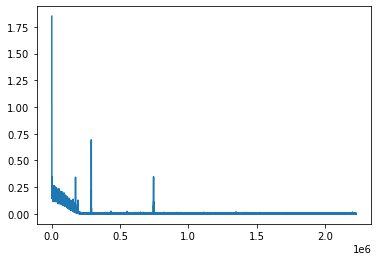

 72%|███████▏  | 7249/10000 [10:45:53<4:09:56,  5.45s/it]

Loss at 2240000 = 2.8759512133547105e-05


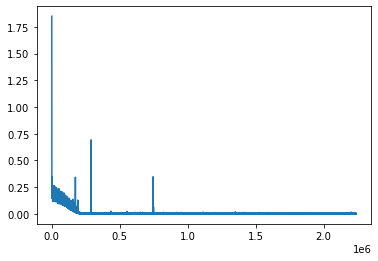

 73%|███████▎  | 7281/10000 [10:48:46<4:04:22,  5.39s/it]

Loss at 2250000 = 3.792544885072857e-05


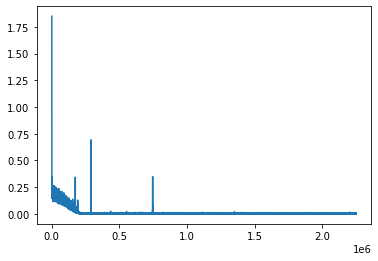

 73%|███████▎  | 7313/10000 [10:51:39<4:00:52,  5.38s/it]

Loss at 2260000 = 3.3521133445901796e-05


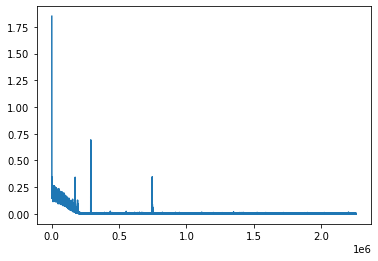

 73%|███████▎  | 7346/10000 [10:54:37<3:59:15,  5.41s/it]

Loss at 2270000 = 2.2601498130825348e-05


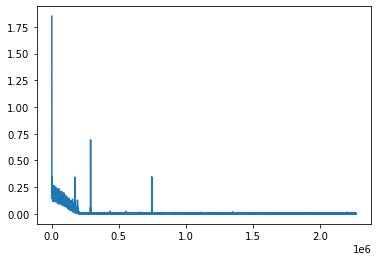

 74%|███████▍  | 7378/10000 [10:57:30<3:56:11,  5.40s/it]

Loss at 2280000 = 4.00785866077058e-05


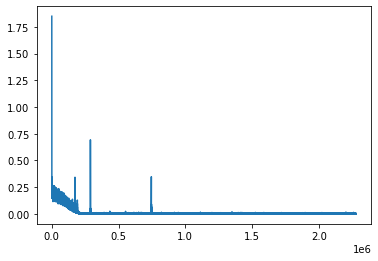

 74%|███████▍  | 7411/10000 [11:00:28<3:52:11,  5.38s/it]

Loss at 2290000 = 5.1118648116244e-05


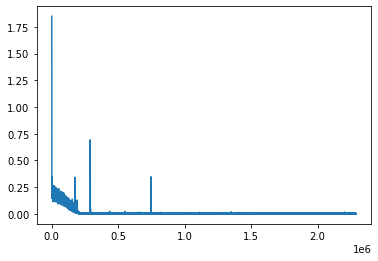

 74%|███████▍  | 7443/10000 [11:03:21<3:48:24,  5.36s/it]

Loss at 2300000 = 4.52767671959009e-05


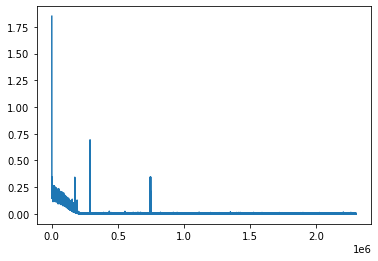

 75%|███████▍  | 7475/10000 [11:06:14<3:49:16,  5.45s/it]

Loss at 2310000 = 3.7481248000403866e-05


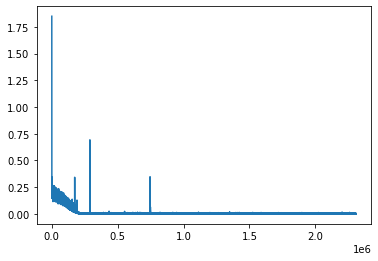

 75%|███████▌  | 7508/10000 [11:09:12<3:42:47,  5.36s/it]

Loss at 2320000 = 2.5555595129844733e-05


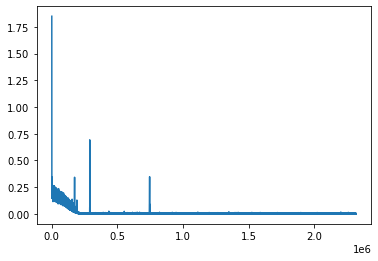

 75%|███████▌  | 7540/10000 [11:12:05<3:42:10,  5.42s/it]

Loss at 2330000 = 3.200669016223401e-05


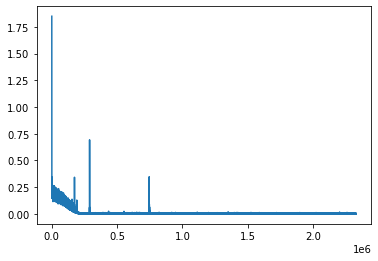

 76%|███████▌  | 7572/10000 [11:14:58<3:37:28,  5.37s/it]

Loss at 2340000 = 3.278713484178297e-05


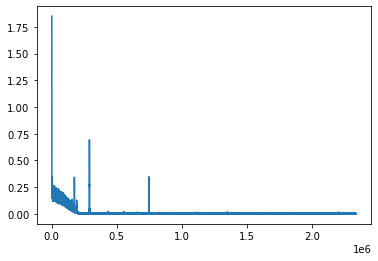

 76%|███████▌  | 7605/10000 [11:17:56<3:33:02,  5.34s/it]

Loss at 2350000 = 4.9290167225990444e-05


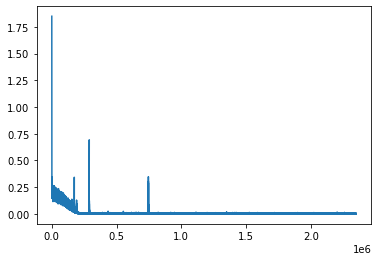

 76%|███████▋  | 7637/10000 [11:20:50<3:33:26,  5.42s/it]

Loss at 2360000 = 4.707237167167477e-05


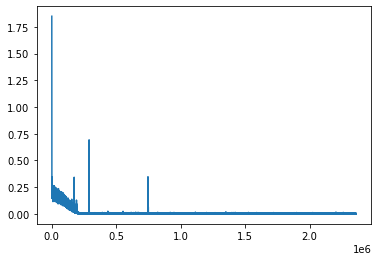

 77%|███████▋  | 7669/10000 [11:23:43<3:27:58,  5.35s/it]

Loss at 2370000 = 2.5615256163291633e-05


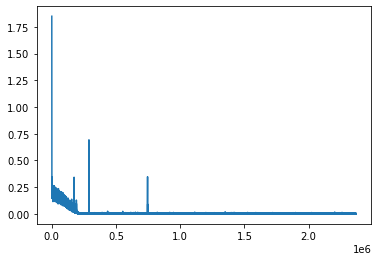

 77%|███████▋  | 7702/10000 [11:26:42<3:27:36,  5.42s/it]

Loss at 2380000 = 2.5251787519664504e-05


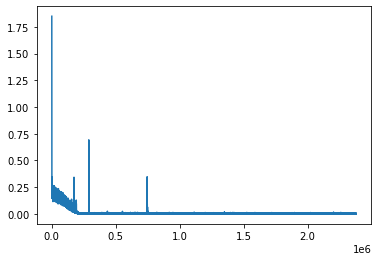

 77%|███████▋  | 7734/10000 [11:29:35<3:21:30,  5.34s/it]

Loss at 2390000 = 3.649728387244977e-05


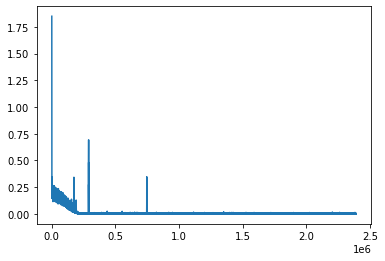

 78%|███████▊  | 7766/10000 [11:32:27<3:18:37,  5.33s/it]

Loss at 2400000 = 3.95186580135487e-05


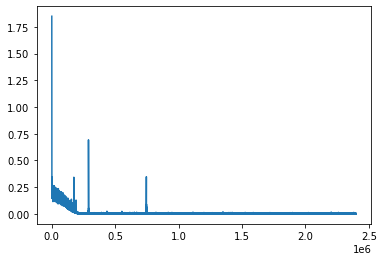

 78%|███████▊  | 7799/10000 [11:35:25<3:16:49,  5.37s/it]

Loss at 2410000 = 3.4893149859271944e-05


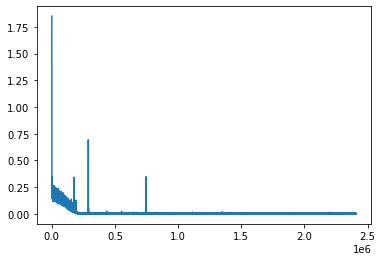

 78%|███████▊  | 7831/10000 [11:38:18<3:13:05,  5.34s/it]

Loss at 2420000 = 2.943672916444484e-05


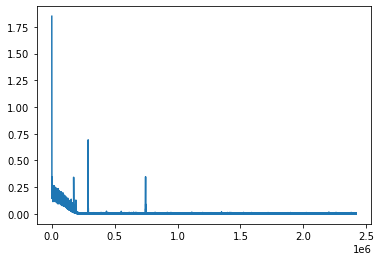

 79%|███████▊  | 7864/10000 [11:41:17<3:10:39,  5.36s/it]

Loss at 2430000 = 3.234721225453541e-05


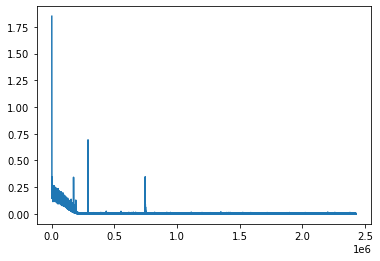

 79%|███████▉  | 7896/10000 [11:44:11<3:10:02,  5.42s/it]

Loss at 2440000 = 2.756083631538786e-05


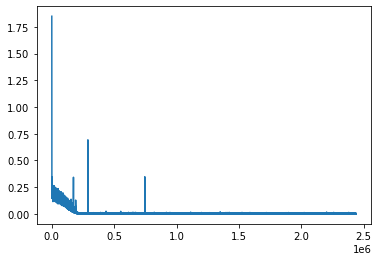

 79%|███████▉  | 7928/10000 [11:47:03<3:05:45,  5.38s/it]

Loss at 2450000 = 3.677779022837058e-05


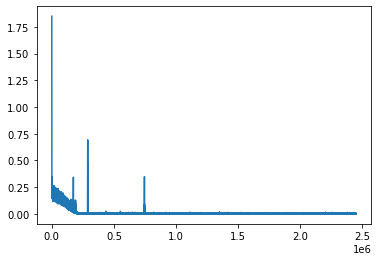

 80%|███████▉  | 7961/10000 [11:50:01<3:01:56,  5.35s/it]

Loss at 2460000 = 3.427295450819656e-05


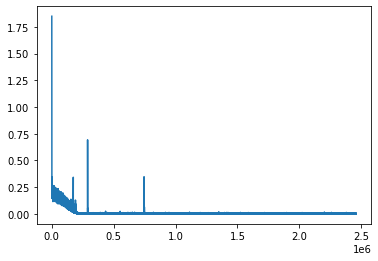

 80%|███████▉  | 7993/10000 [11:52:55<3:01:18,  5.42s/it]

Loss at 2470000 = 2.676093026821036e-05


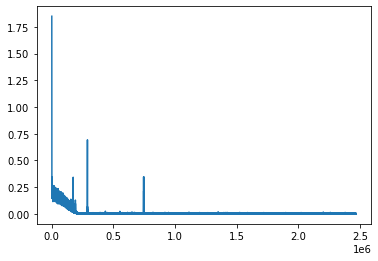

 80%|████████  | 8025/10000 [11:55:49<2:58:50,  5.43s/it]

Loss at 2480000 = 2.9540227842517197e-05


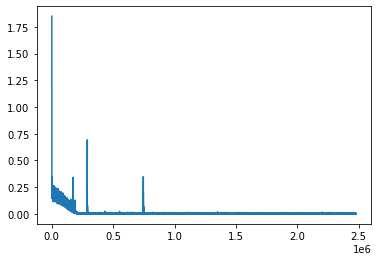

 81%|████████  | 8058/10000 [11:58:47<2:54:27,  5.39s/it]

Loss at 2490000 = 2.9402975997072645e-05


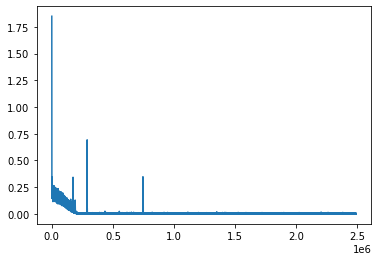

 81%|████████  | 8090/10000 [12:01:39<2:50:30,  5.36s/it]

Loss at 2500000 = 3.9107308111852035e-05


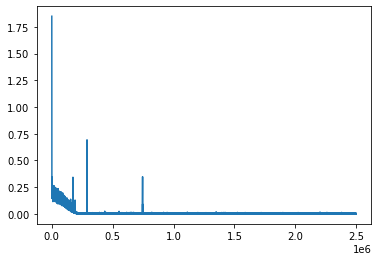

 81%|████████  | 8122/10000 [12:04:33<2:49:36,  5.42s/it]

Loss at 2510000 = 7.30008032405749e-05


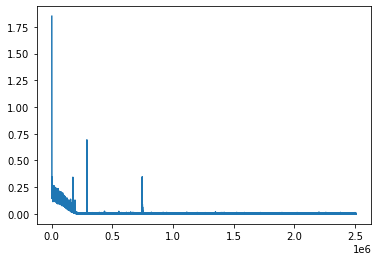

 82%|████████▏ | 8155/10000 [12:07:32<2:45:37,  5.39s/it]

Loss at 2520000 = 2.9596923923236318e-05


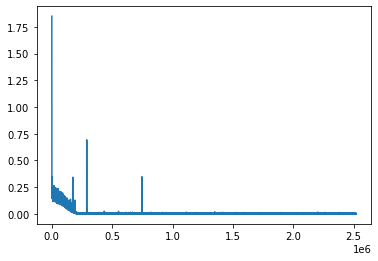

 82%|████████▏ | 8187/10000 [12:10:26<2:41:20,  5.34s/it]

Loss at 2530000 = 2.40276367549086e-05


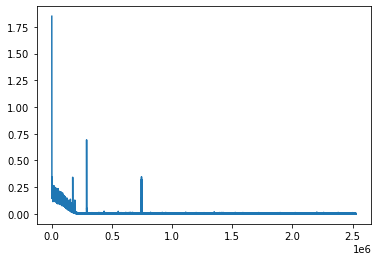

 82%|████████▏ | 8220/10000 [12:13:25<2:39:27,  5.37s/it]

Loss at 2540000 = 2.537717045925092e-05


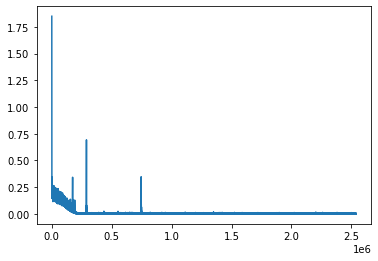

 83%|████████▎ | 8252/10000 [12:16:18<2:37:47,  5.42s/it]

Loss at 2550000 = 2.9679087674594484e-05


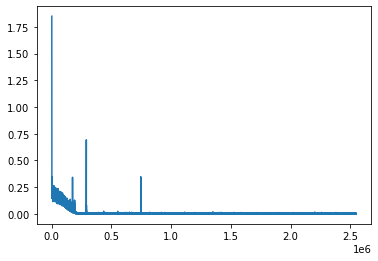

 83%|████████▎ | 8284/10000 [12:19:12<2:34:11,  5.39s/it]

Loss at 2560000 = 5.153750680619851e-05


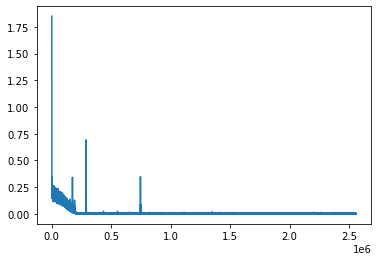

 83%|████████▎ | 8317/10000 [12:22:12<2:31:44,  5.41s/it]

Loss at 2570000 = 2.7225651137996465e-05


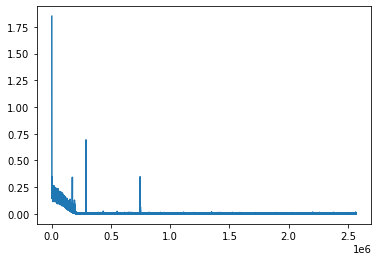

 83%|████████▎ | 8349/10000 [12:25:05<2:28:58,  5.41s/it]

Loss at 2580000 = 3.250824011047371e-05


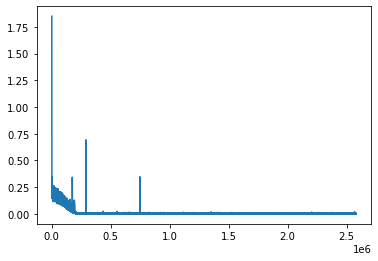

 84%|████████▍ | 8381/10000 [12:27:57<2:22:56,  5.30s/it]

Loss at 2590000 = 2.2699476176057942e-05


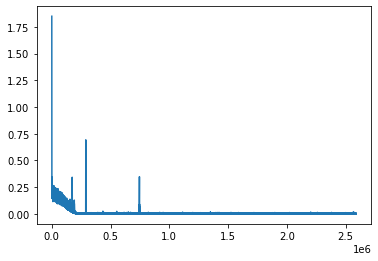

 84%|████████▍ | 8414/10000 [12:30:56<2:23:21,  5.42s/it]

Loss at 2600000 = 2.880310421460308e-05


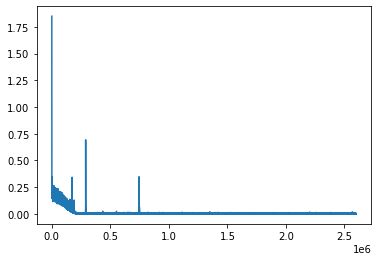

 84%|████████▍ | 8446/10000 [12:33:49<2:19:51,  5.40s/it]

Loss at 2610000 = 1.7590691641089506e-05


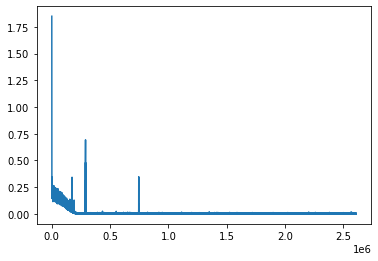

 85%|████████▍ | 8478/10000 [12:36:45<2:18:57,  5.48s/it]

Loss at 2620000 = 5.069484541309066e-05


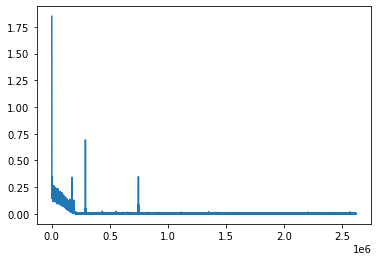

 85%|████████▌ | 8511/10000 [12:39:45<2:14:36,  5.42s/it]

Loss at 2630000 = 2.965418934763875e-05


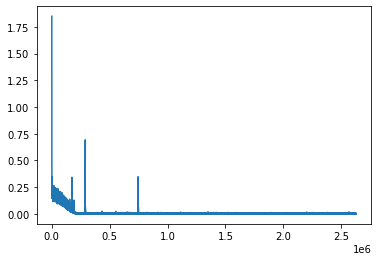

 85%|████████▌ | 8543/10000 [12:42:38<2:10:57,  5.39s/it]

Loss at 2640000 = 0.003057855647057295


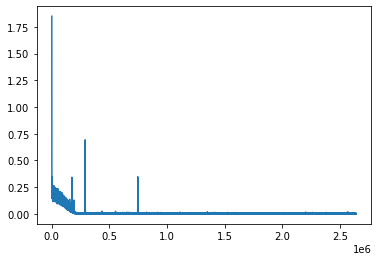

 86%|████████▌ | 8576/10000 [12:45:38<2:09:09,  5.44s/it]

Loss at 2650000 = 3.5639346606330946e-05


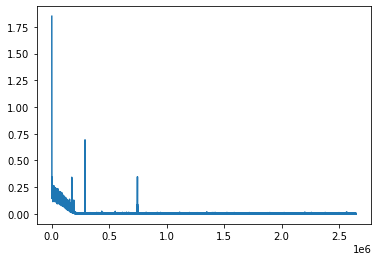

 86%|████████▌ | 8608/10000 [12:48:32<2:04:55,  5.38s/it]

Loss at 2660000 = 3.3236243325518444e-05


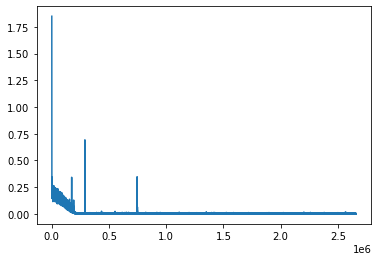

 86%|████████▋ | 8640/10000 [12:51:26<2:04:37,  5.50s/it]

Loss at 2670000 = 2.5535988243063912e-05


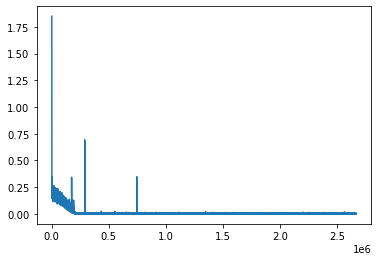

 87%|████████▋ | 8673/10000 [12:54:24<1:59:18,  5.39s/it]

Loss at 2680000 = 3.0277054975158535e-05


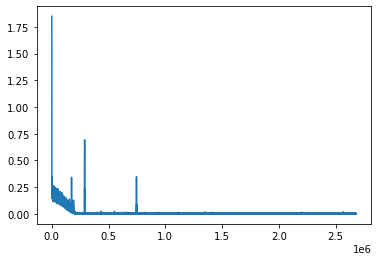

 87%|████████▋ | 8705/10000 [12:57:18<1:57:47,  5.46s/it]

Loss at 2690000 = 4.1186569433193654e-05


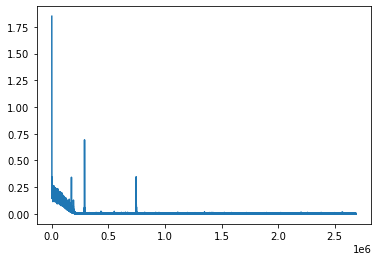

 87%|████████▋ | 8737/10000 [13:00:12<1:53:13,  5.38s/it]

Loss at 2700000 = 3.3655032893875614e-05


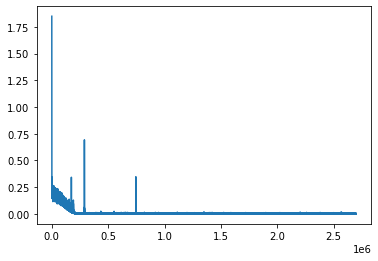

 88%|████████▊ | 8770/10000 [13:03:11<1:51:10,  5.42s/it]

Loss at 2710000 = 2.6285371859557927e-05


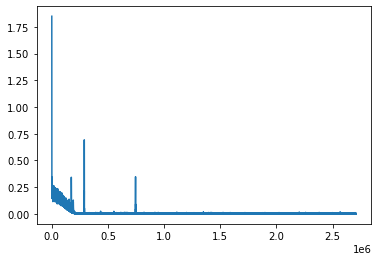

 88%|████████▊ | 8802/10000 [13:06:06<1:48:16,  5.42s/it]

Loss at 2720000 = 3.0838527891319245e-05


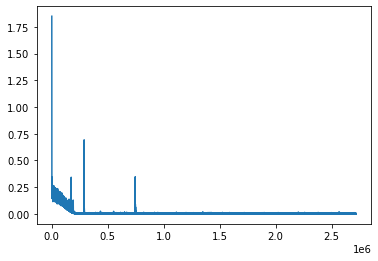

 88%|████████▊ | 8834/10000 [13:09:00<1:44:08,  5.36s/it]

Loss at 2730000 = 3.6715158785227686e-05


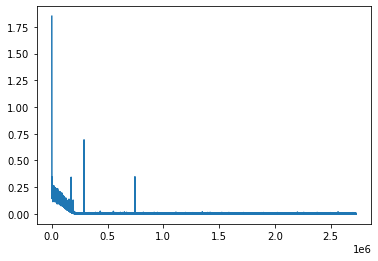

 89%|████████▊ | 8867/10000 [13:11:58<1:41:49,  5.39s/it]

Loss at 2740000 = 3.8687168853357434e-05


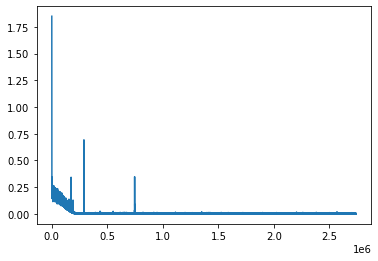

 89%|████████▉ | 8899/10000 [13:14:51<1:38:50,  5.39s/it]

Loss at 2750000 = 3.5406141250859946e-05


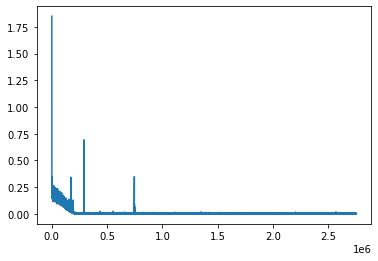

 89%|████████▉ | 8932/10000 [13:17:50<1:35:40,  5.38s/it]

Loss at 2760000 = 4.192962296656333e-05


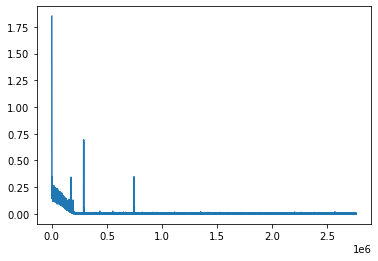

 90%|████████▉ | 8964/10000 [13:20:43<1:33:53,  5.44s/it]

Loss at 2770000 = 1.9664108549477533e-05


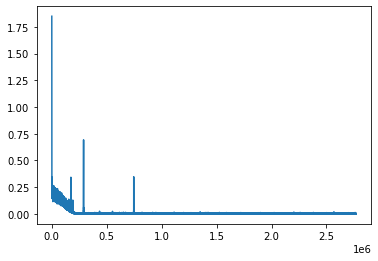

 90%|████████▉ | 8996/10000 [13:23:37<1:29:46,  5.37s/it]

Loss at 2780000 = 4.1007024265127257e-05


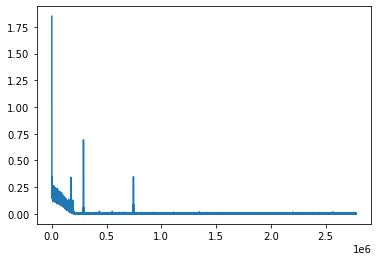

 90%|█████████ | 9029/10000 [13:26:35<1:26:28,  5.34s/it]

Loss at 2790000 = 2.1992314941599034e-05


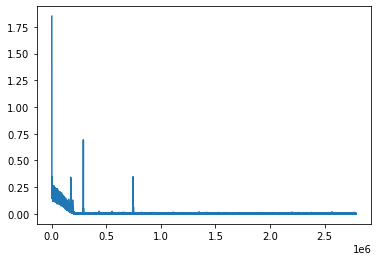

 91%|█████████ | 9061/10000 [13:29:29<1:24:31,  5.40s/it]

Loss at 2800000 = 3.5223973100073636e-05


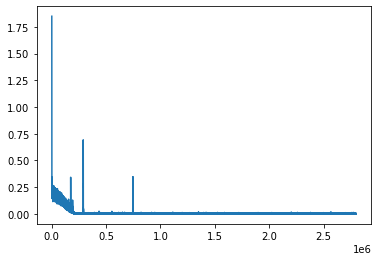

 91%|█████████ | 9093/10000 [13:32:21<1:21:15,  5.38s/it]

Loss at 2810000 = 2.5881299734464847e-05


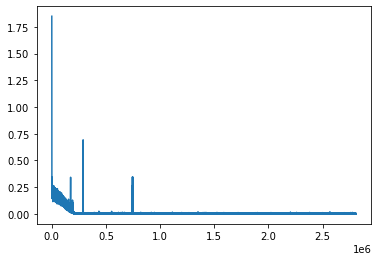

 91%|█████████▏| 9126/10000 [13:35:20<1:19:01,  5.42s/it]

Loss at 2820000 = 3.212194496882148e-05


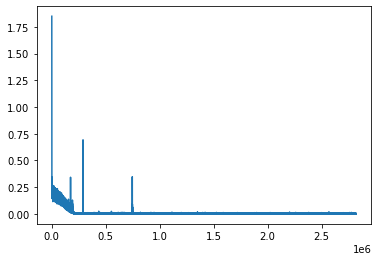

 92%|█████████▏| 9158/10000 [13:38:14<1:15:36,  5.39s/it]

Loss at 2830000 = 2.823123759299051e-05


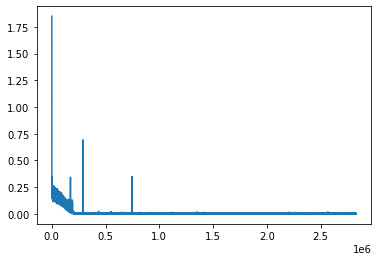

 92%|█████████▏| 9190/10000 [13:41:08<1:12:56,  5.40s/it]

Loss at 2840000 = 2.0661449525505304e-05


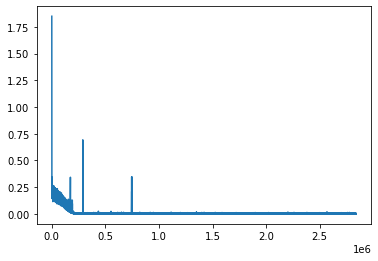

 92%|█████████▏| 9223/10000 [13:44:07<1:09:31,  5.37s/it]

Loss at 2850000 = 4.5297441829461604e-05


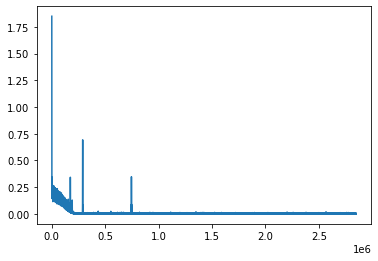

 93%|█████████▎| 9255/10000 [13:47:02<1:11:01,  5.72s/it]

Loss at 2860000 = 2.9367201932473108e-05


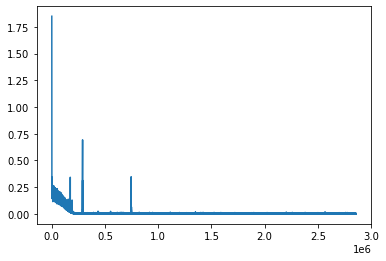

 93%|█████████▎| 9288/10000 [13:50:04<1:03:54,  5.39s/it]

Loss at 2870000 = 2.543900154705625e-05


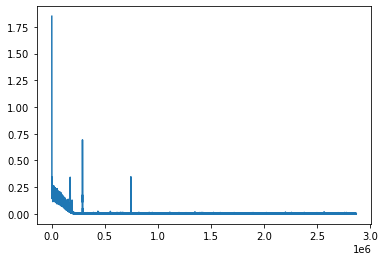

 93%|█████████▎| 9320/10000 [13:53:02<1:04:58,  5.73s/it]

Loss at 2880000 = 1.864851947175339e-05


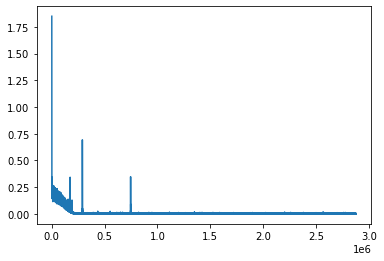

 94%|█████████▎| 9352/10000 [13:56:00<58:09,  5.38s/it]  

Loss at 2890000 = 3.5300166928209364e-05


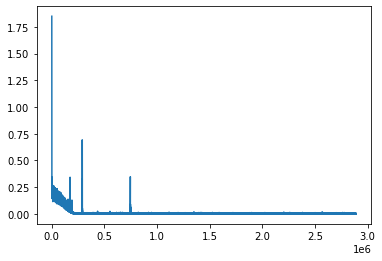

 94%|█████████▍| 9385/10000 [13:58:57<54:52,  5.35s/it]

Loss at 2900000 = 2.613092328829225e-05


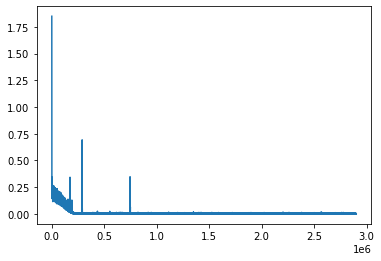

 94%|█████████▍| 9417/10000 [14:02:01<56:02,  5.77s/it]

Loss at 2910000 = 2.895411671488546e-05


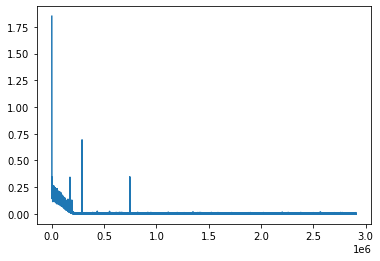

 94%|█████████▍| 9449/10000 [14:04:52<49:17,  5.37s/it]

Loss at 2920000 = 3.085044590989128e-05


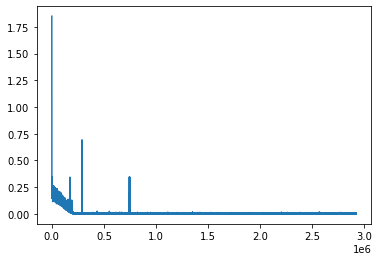

 95%|█████████▍| 9482/10000 [14:07:56<46:53,  5.43s/it]

Loss at 2930000 = 2.462928205204662e-05


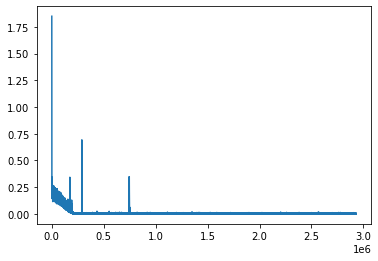

 95%|█████████▌| 9514/10000 [14:10:50<43:56,  5.42s/it]

Loss at 2940000 = 4.22532029915601e-05


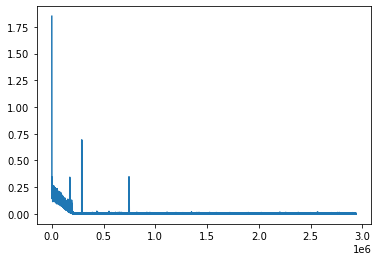

 95%|█████████▌| 9546/10000 [14:13:47<43:40,  5.77s/it]

Loss at 2950000 = 3.122647467534989e-05


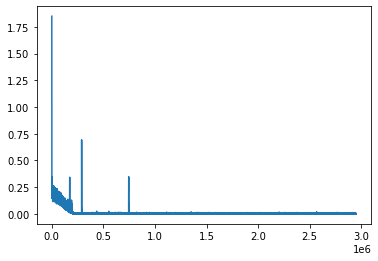

 96%|█████████▌| 9579/10000 [14:16:54<40:44,  5.81s/it]

Loss at 2960000 = 2.7204654543311335e-05


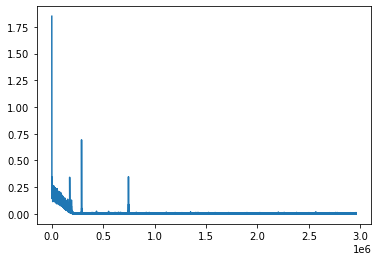

 96%|█████████▌| 9611/10000 [14:19:49<34:31,  5.32s/it]

Loss at 2970000 = 2.3921993488329463e-05


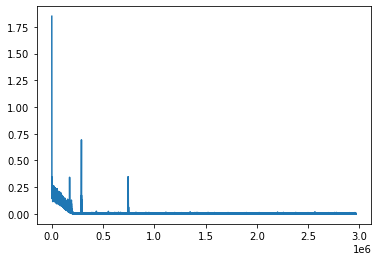

 96%|█████████▋| 9644/10000 [14:22:48<32:26,  5.47s/it]

Loss at 2980000 = 2.7314808903611265e-05


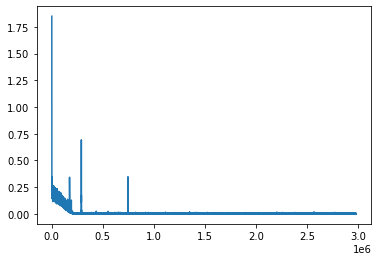

 97%|█████████▋| 9676/10000 [14:25:41<29:00,  5.37s/it]

Loss at 2990000 = 2.3803795556887053e-05


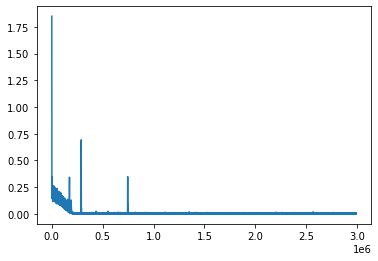

 97%|█████████▋| 9708/10000 [14:28:36<26:45,  5.50s/it]

Loss at 3000000 = 2.761194627964869e-05


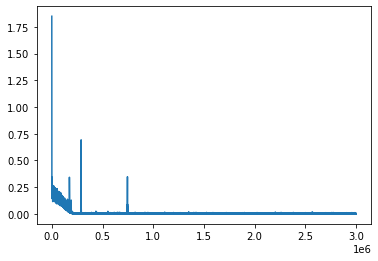

 97%|█████████▋| 9741/10000 [14:31:35<23:20,  5.41s/it]

Loss at 3010000 = 2.8753693186445162e-05


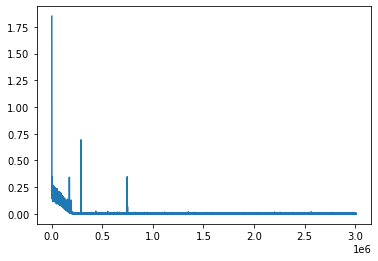

 98%|█████████▊| 9773/10000 [14:34:30<20:30,  5.42s/it]

Loss at 3020000 = 3.509141970425844e-05


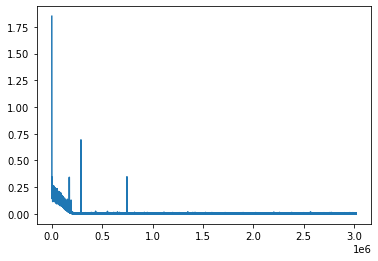

 98%|█████████▊| 9805/10000 [14:37:29<17:17,  5.32s/it]

Loss at 3030000 = 2.5575034669600427e-05


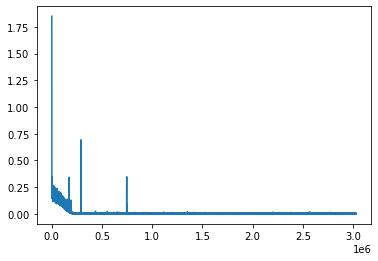

 98%|█████████▊| 9838/10000 [14:40:28<14:41,  5.44s/it]

Loss at 3040000 = 1.998104744416196e-05


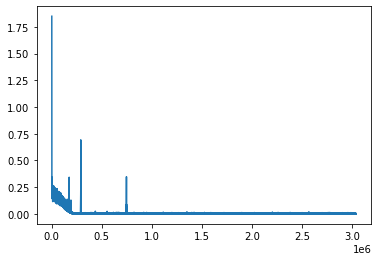

 99%|█████████▊| 9870/10000 [14:43:22<11:46,  5.43s/it]

Loss at 3050000 = 3.434432073845528e-05


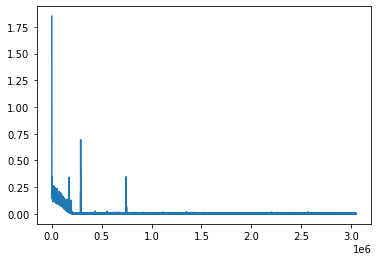

 99%|█████████▉| 9902/10000 [14:46:16<08:46,  5.37s/it]

Loss at 3060000 = 3.105710129602812e-05


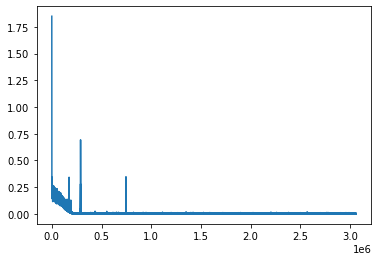

 99%|█████████▉| 9935/10000 [14:49:15<05:51,  5.41s/it]

Loss at 3070000 = 2.104399391100742e-05


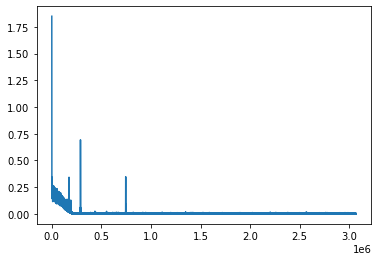

100%|█████████▉| 9967/10000 [14:52:09<02:58,  5.42s/it]

Loss at 3080000 = 2.8192724130349234e-05


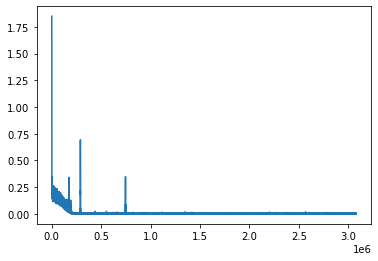

100%|█████████▉| 9999/10000 [14:55:02<00:05,  5.38s/it]

Loss at 3090000 = 1.9073318981099874e-05


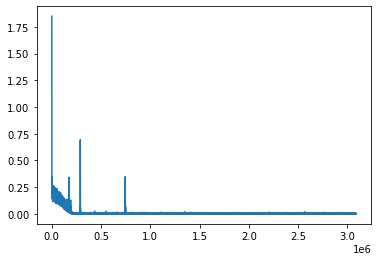

100%|██████████| 10000/10000 [14:55:08<00:00,  5.37s/it]


In [30]:
C_real = train(Classifier().cuda(), X_train, y_train, epochs=10000)

In [31]:
def test(net, X_test, y_test):
    with torch.no_grad():
        net.eval()
        print(X_test.shape)
        print(y_test.shape)
        dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(),
                                                 torch.from_numpy(y_test).long())
        loader = torch.utils.data.DataLoader(dataset, batch_size=mb_size)
        pred = []
        for X, y in loader:
            X, y = X.cuda(), y.cuda()
            out = net(X)
            _, out = torch.max(out, 1)
            pred.append(out.cpu().numpy())
        pred = np.concatenate(pred)
        print(classification_report(y_test, pred, digits=4))
    return pred

In [32]:
test(C_real, X_test, y_test)

(5990898, 51)
(5990898,)


c:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.8831    0.8945    0.8888   1849505
           2     0.9724    0.9719    0.9722   3031804
           3     0.9785    0.9668    0.9726    112734
           4     0.8437    0.8386    0.8411    871447
           5     0.5103    0.4468    0.4764    125408

    accuracy                         0.9175   5990898
   macro avg     0.6980    0.6864    0.6919   5990898
weighted avg     0.9166    0.9175    0.9170   5990898



c:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

  0%|          | 16/10000 [02:44<28:28:07, 10.27s/it]

Loss at 10000 = 0.10383834689855576


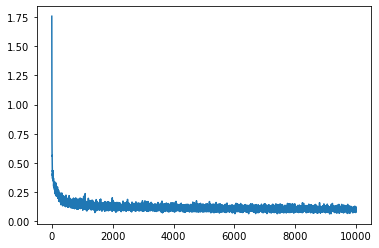

  0%|          | 32/10000 [05:28<28:26:53, 10.27s/it]

Loss at 20000 = 0.0938122346997261


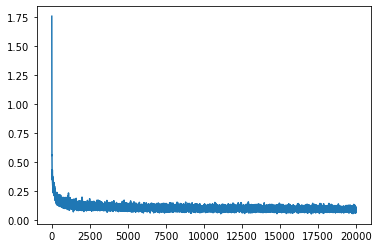

  0%|          | 48/10000 [08:12<28:16:48, 10.23s/it]

Loss at 30000 = 0.10495853424072266


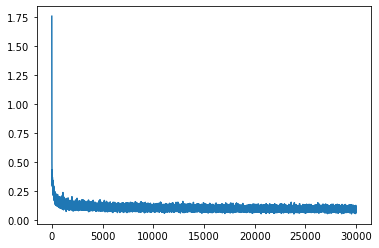

  1%|          | 64/10000 [10:57<28:21:15, 10.27s/it]

Loss at 40000 = 0.0894661396741867


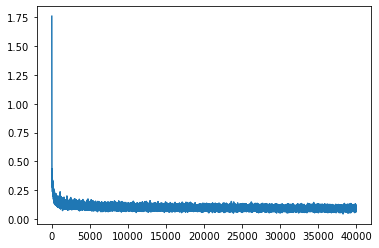

  1%|          | 81/10000 [13:52<28:16:37, 10.26s/it]

Loss at 50000 = 0.10525398701429367


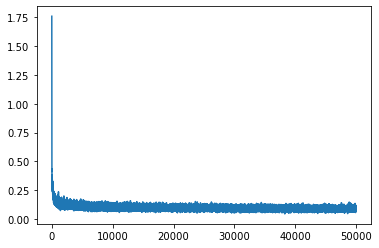

  1%|          | 97/10000 [16:36<28:08:07, 10.23s/it]

Loss at 60000 = 0.07957608997821808


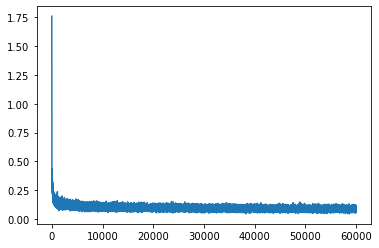

  1%|          | 113/10000 [19:20<28:11:57, 10.27s/it]

Loss at 70000 = 0.09118680655956268


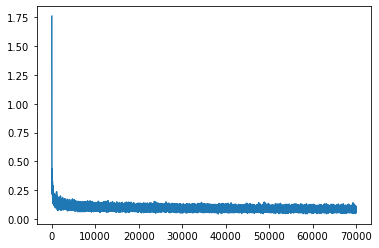

  1%|▏         | 129/10000 [22:05<28:06:38, 10.25s/it]

Loss at 80000 = 0.05981375649571419


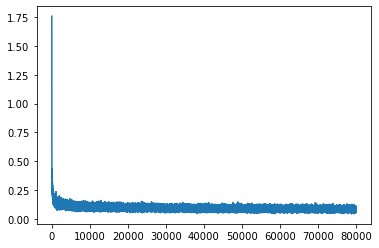

  1%|▏         | 145/10000 [24:49<28:05:16, 10.26s/it]

Loss at 90000 = 0.0781092718243599


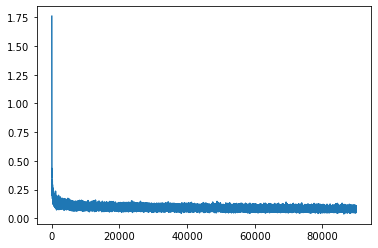

  2%|▏         | 162/10000 [27:44<28:02:39, 10.26s/it]

Loss at 100000 = 0.08818016201257706


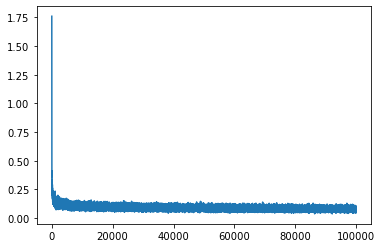

  2%|▏         | 178/10000 [30:28<28:12:27, 10.34s/it]

Loss at 110000 = 0.09572865068912506


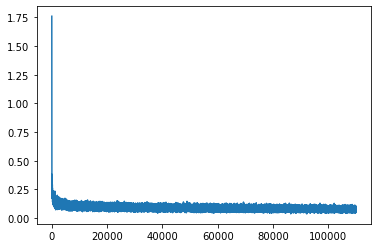

  2%|▏         | 194/10000 [33:16<28:08:09, 10.33s/it]

Loss at 120000 = 0.07433976233005524


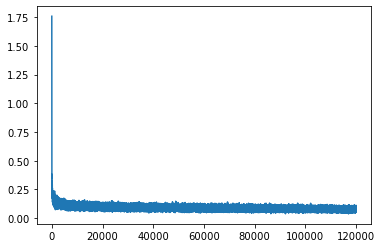

  2%|▏         | 210/10000 [36:01<28:03:42, 10.32s/it]

Loss at 130000 = 0.08864901959896088


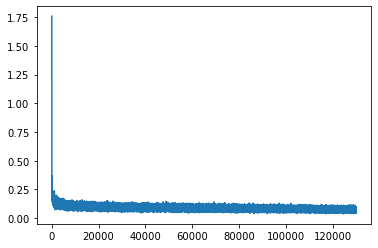

  2%|▏         | 226/10000 [38:46<27:51:04, 10.26s/it]

Loss at 140000 = 0.06066323444247246


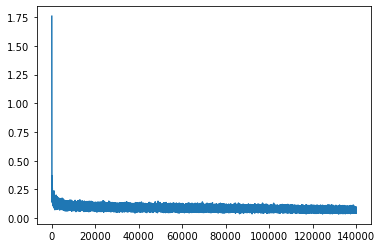

  2%|▏         | 243/10000 [41:41<27:49:24, 10.27s/it]

Loss at 150000 = 0.059791434556245804


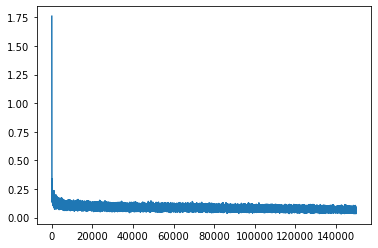

  3%|▎         | 259/10000 [44:25<27:38:18, 10.21s/it]

Loss at 160000 = 0.06721902638673782


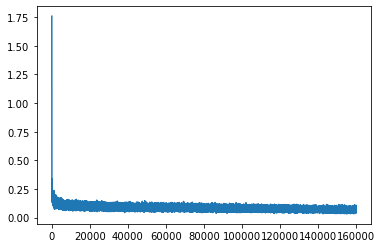

  3%|▎         | 275/10000 [47:09<27:44:59, 10.27s/it]

Loss at 170000 = 0.04987272620201111


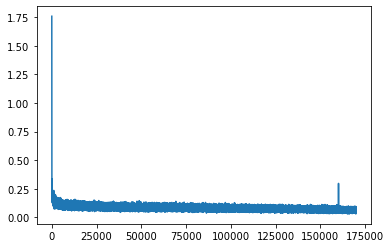

  3%|▎         | 291/10000 [49:54<27:42:14, 10.27s/it]

Loss at 180000 = 0.054464370012283325


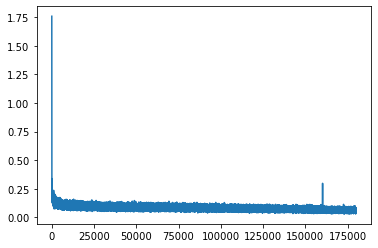

  3%|▎         | 307/10000 [52:38<27:34:59, 10.24s/it]

Loss at 190000 = 0.0674692839384079


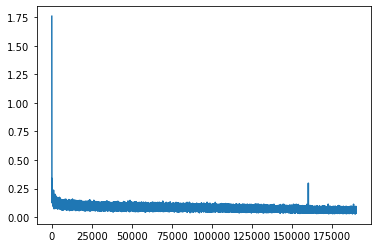

  3%|▎         | 324/10000 [55:33<27:30:39, 10.24s/it]

Loss at 200000 = 0.053709544241428375


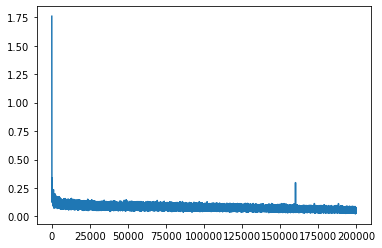

  3%|▎         | 340/10000 [58:17<27:30:20, 10.25s/it]

Loss at 210000 = 0.03572084754705429


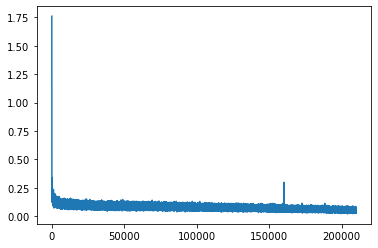

  4%|▎         | 356/10000 [1:01:02<27:33:27, 10.29s/it]

Loss at 220000 = 0.04423641040921211


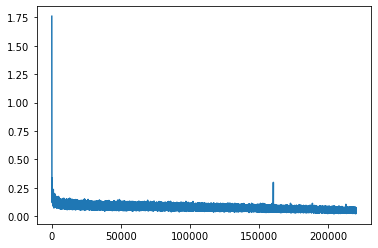

  4%|▎         | 372/10000 [1:03:47<27:31:55, 10.29s/it]

Loss at 230000 = 0.04949039965867996


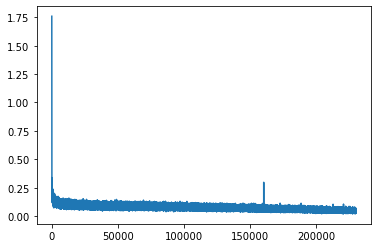

  4%|▍         | 388/10000 [1:06:31<27:19:36, 10.23s/it]

Loss at 240000 = 0.05351242795586586


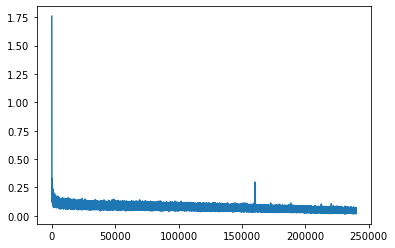

  4%|▍         | 405/10000 [1:09:25<27:16:16, 10.23s/it]

Loss at 250000 = 0.03631105646491051


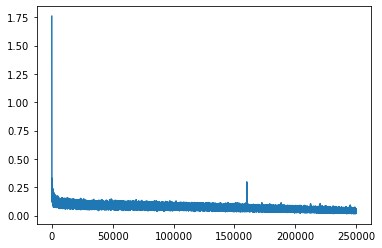

  4%|▍         | 421/10000 [1:12:10<27:15:23, 10.24s/it]

Loss at 260000 = 0.023847421631217003


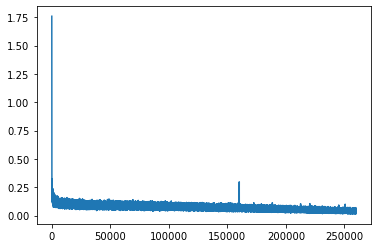

  4%|▍         | 437/10000 [1:14:54<27:10:20, 10.23s/it]

Loss at 270000 = 0.05478250980377197


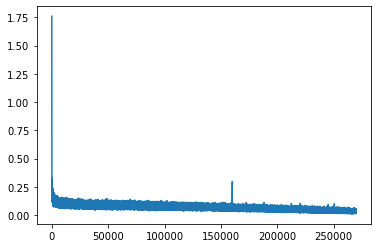

  5%|▍         | 453/10000 [1:17:38<27:13:31, 10.27s/it]

Loss at 280000 = 0.037543199956417084


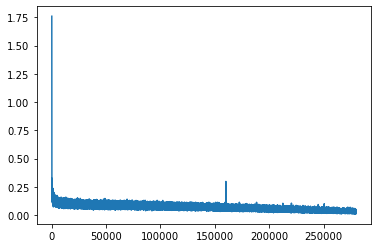

  5%|▍         | 470/10000 [1:20:33<27:09:45, 10.26s/it]

Loss at 290000 = 0.04222820699214935


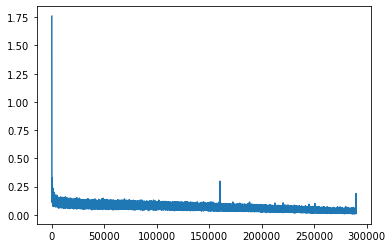

  5%|▍         | 486/10000 [1:23:18<27:07:34, 10.26s/it]

Loss at 300000 = 0.03083612211048603


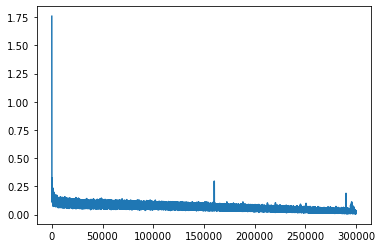

  5%|▌         | 502/10000 [1:26:03<27:12:11, 10.31s/it]

Loss at 310000 = 0.019382115453481674


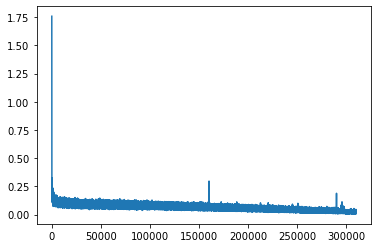

  5%|▌         | 518/10000 [1:28:47<27:07:20, 10.30s/it]

Loss at 320000 = 0.013801970519125462


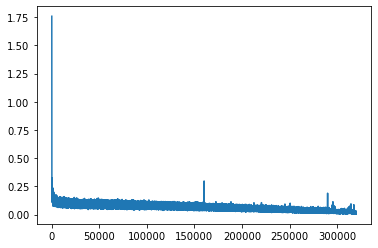

  5%|▌         | 534/10000 [1:31:32<27:03:17, 10.29s/it]

Loss at 330000 = 0.016309106722474098


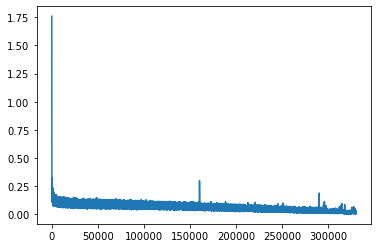

  6%|▌         | 551/10000 [1:34:27<26:51:11, 10.23s/it]

Loss at 340000 = 0.013056416064500809


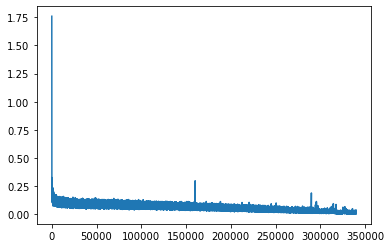

  6%|▌         | 567/10000 [1:37:11<27:02:13, 10.32s/it]

Loss at 350000 = 0.006402838043868542


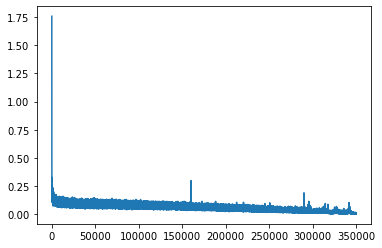

  6%|▌         | 583/10000 [1:39:56<27:01:55, 10.33s/it]

Loss at 360000 = 0.0028874354902654886


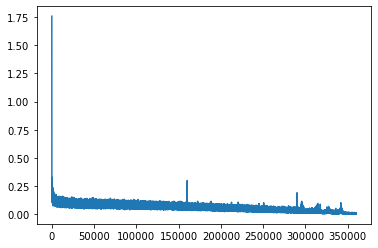

  6%|▌         | 599/10000 [1:42:41<26:50:25, 10.28s/it]

Loss at 370000 = 0.0034264943096786737


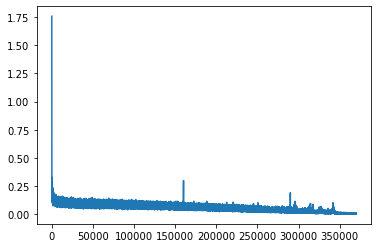

  6%|▌         | 615/10000 [1:45:25<26:41:37, 10.24s/it]

Loss at 380000 = 0.00304917199537158


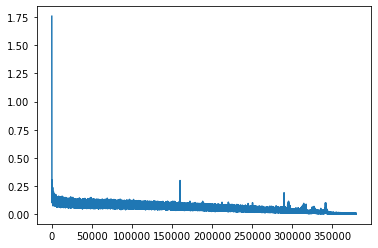

  6%|▋         | 632/10000 [1:48:20<26:44:31, 10.28s/it]

Loss at 390000 = 0.0013105821562930942


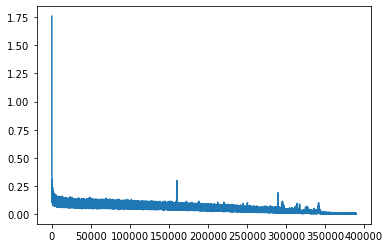

  6%|▋         | 648/10000 [1:51:05<26:36:31, 10.24s/it]

Loss at 400000 = 0.0014232734683901072


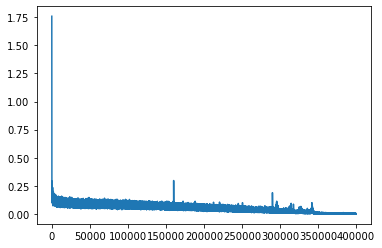

  7%|▋         | 664/10000 [1:53:49<26:34:01, 10.24s/it]

Loss at 410000 = 0.0010838519083335996


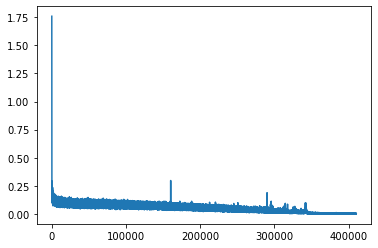

  7%|▋         | 680/10000 [1:56:34<26:41:22, 10.31s/it]

Loss at 420000 = 0.0010504540987312794


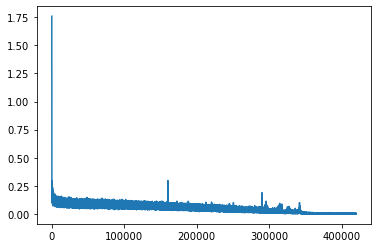

  7%|▋         | 696/10000 [1:59:18<26:33:50, 10.28s/it]

Loss at 430000 = 0.0008699740865267813


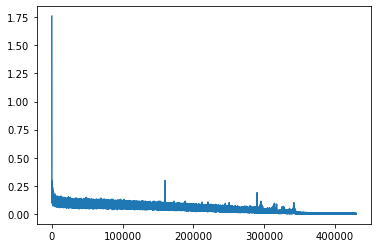

  7%|▋         | 713/10000 [2:02:13<26:32:25, 10.29s/it]

Loss at 440000 = 0.0003658086061477661


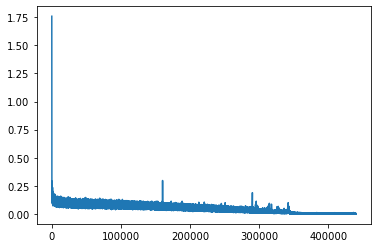

  7%|▋         | 729/10000 [2:04:58<26:29:49, 10.29s/it]

Loss at 450000 = 0.0004735847469419241


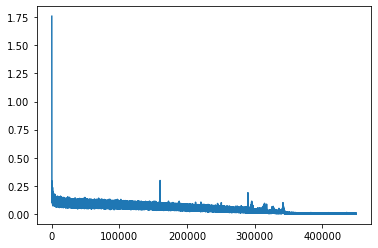

  7%|▋         | 745/10000 [2:07:43<26:24:16, 10.27s/it]

Loss at 460000 = 0.00048483230057172477


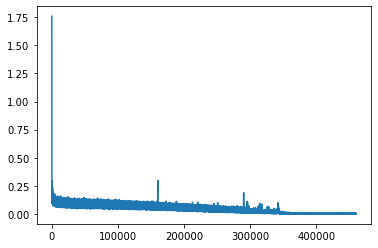

  8%|▊         | 761/10000 [2:10:27<26:26:33, 10.30s/it]

Loss at 470000 = 0.0006809225887991488


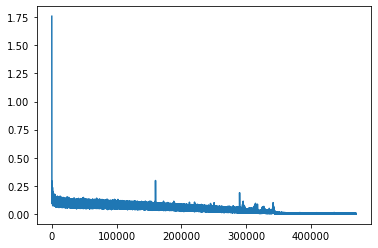

  8%|▊         | 777/10000 [2:13:12<26:17:25, 10.26s/it]

Loss at 480000 = 0.000614847696851939


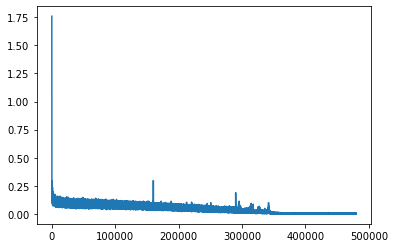

  8%|▊         | 794/10000 [2:16:07<26:12:40, 10.25s/it]

Loss at 490000 = 0.00041491014417260885


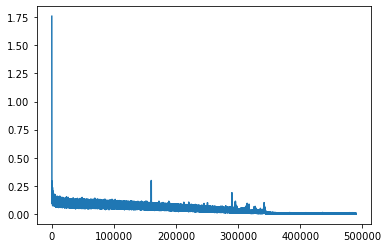

  8%|▊         | 810/10000 [2:18:51<26:15:13, 10.28s/it]

Loss at 500000 = 0.0002720319898799062


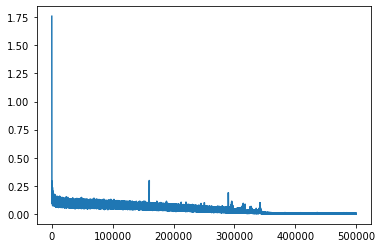

  8%|▊         | 826/10000 [2:21:36<26:11:43, 10.28s/it]

Loss at 510000 = 0.0037780257407575846


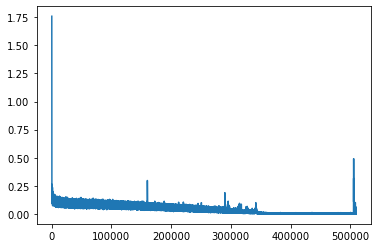

  8%|▊         | 842/10000 [2:24:21<26:09:02, 10.28s/it]

Loss at 520000 = 0.000547477975487709


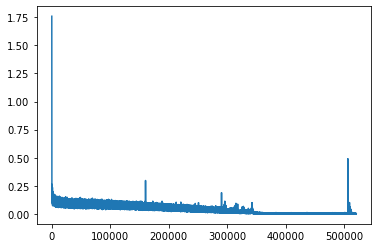

  9%|▊         | 858/10000 [2:27:06<26:07:20, 10.29s/it]

Loss at 530000 = 0.0006235067266970873


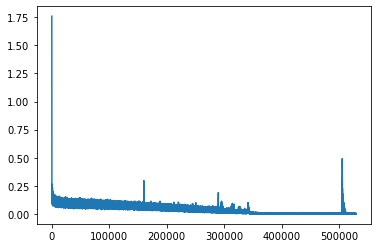

  9%|▉         | 875/10000 [2:30:01<26:02:19, 10.27s/it]

Loss at 540000 = 0.0003579564508982003


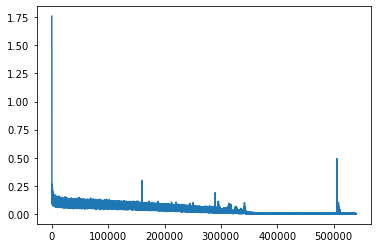

  9%|▉         | 891/10000 [2:32:46<26:02:23, 10.29s/it]

Loss at 550000 = 0.0002547364274505526


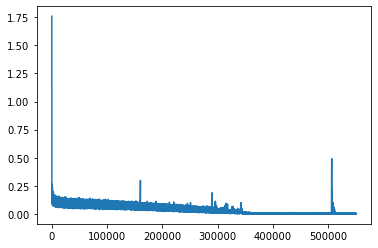

  9%|▉         | 907/10000 [2:35:31<25:55:59, 10.27s/it]

Loss at 560000 = 0.00033685428206808865


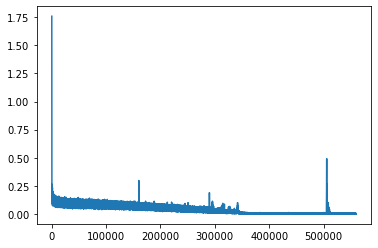

  9%|▉         | 923/10000 [2:38:16<25:58:40, 10.30s/it]

Loss at 570000 = 0.00032255396945402026


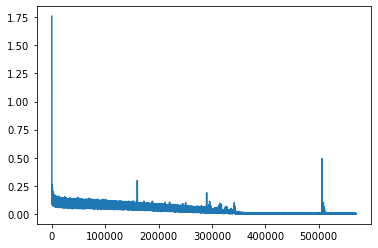

  9%|▉         | 940/10000 [2:41:11<25:57:57, 10.32s/it]

Loss at 580000 = 0.0003264570259489119


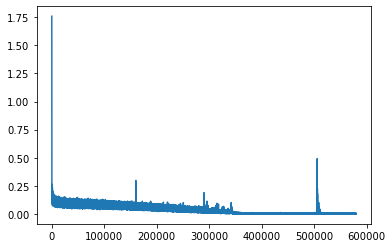

 10%|▉         | 956/10000 [2:43:56<25:52:18, 10.30s/it]

Loss at 590000 = 0.0019006942166015506


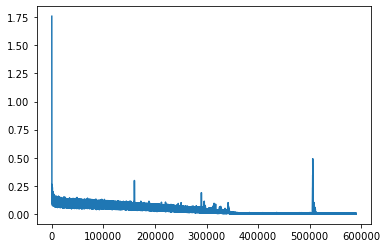

 10%|▉         | 972/10000 [2:46:40<25:41:51, 10.25s/it]

Loss at 600000 = 0.0002096662065014243


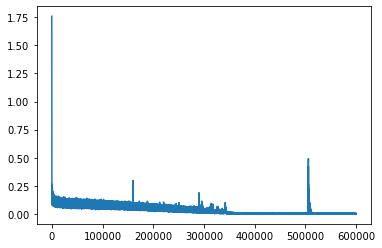

 10%|▉         | 988/10000 [2:49:24<25:38:44, 10.24s/it]

Loss at 610000 = 0.00035368662793189287


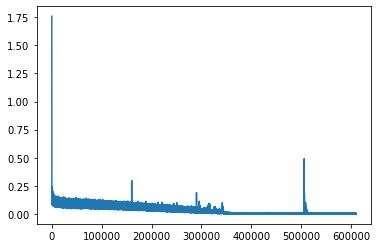

 10%|█         | 1004/10000 [2:52:10<25:51:15, 10.35s/it]

Loss at 620000 = 0.0002177025016862899


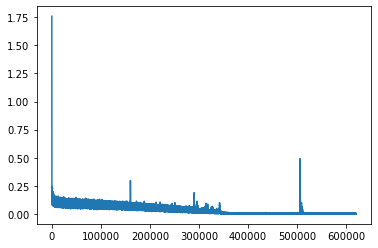

 10%|█         | 1021/10000 [2:55:05<25:37:13, 10.27s/it]

Loss at 630000 = 0.00023851462174206972


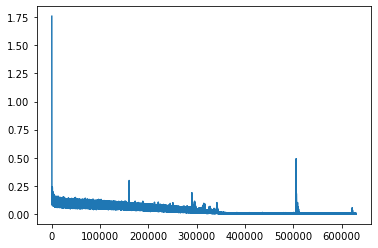

 10%|█         | 1037/10000 [2:57:51<25:42:59, 10.33s/it]

Loss at 640000 = 0.00029647938208654523


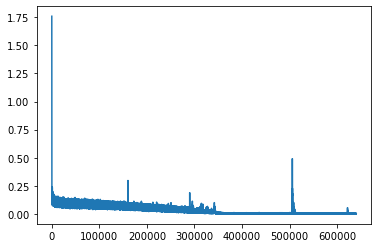

 11%|█         | 1053/10000 [3:00:36<25:36:47, 10.31s/it]

Loss at 650000 = 0.0002178779395762831


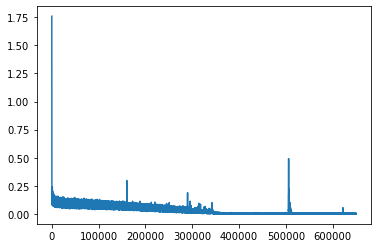

 11%|█         | 1069/10000 [3:03:21<25:32:33, 10.30s/it]

Loss at 660000 = 0.00020157212566118687


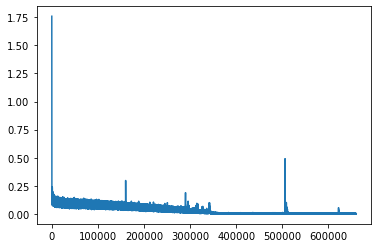

 11%|█         | 1085/10000 [3:06:05<25:22:23, 10.25s/it]

Loss at 670000 = 0.00020862871315330267


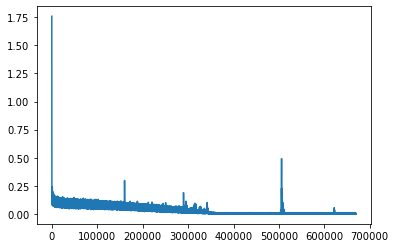

 11%|█         | 1102/10000 [3:09:01<25:27:02, 10.30s/it]

Loss at 680000 = 0.00016460297047160566


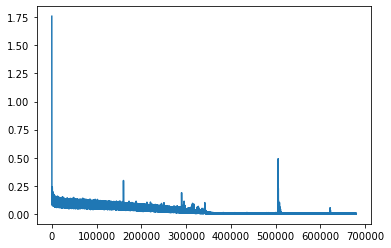

 11%|█         | 1118/10000 [3:11:46<25:26:08, 10.31s/it]

Loss at 690000 = 0.00011791108408942819


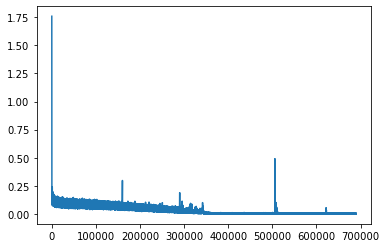

 11%|█▏        | 1134/10000 [3:14:31<25:20:44, 10.29s/it]

Loss at 700000 = 0.00022213117335923016


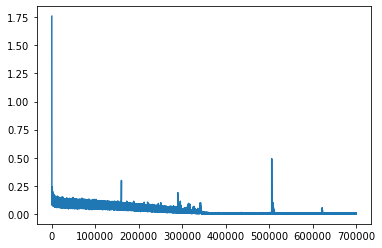

 12%|█▏        | 1150/10000 [3:17:16<25:17:00, 10.28s/it]

Loss at 710000 = 0.0001847823878051713


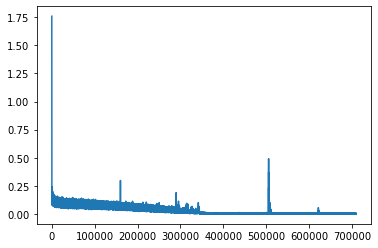

 12%|█▏        | 1166/10000 [3:20:00<25:12:31, 10.27s/it]

Loss at 720000 = 0.0001906715042423457


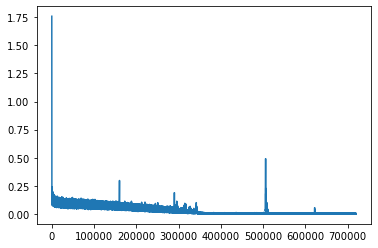

 12%|█▏        | 1183/10000 [3:22:56<25:20:02, 10.34s/it]

Loss at 730000 = 0.00017109014152083546


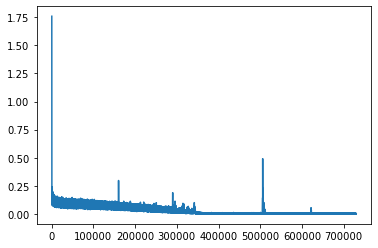

 12%|█▏        | 1199/10000 [3:25:41<25:12:25, 10.31s/it]

Loss at 740000 = 0.0001892767904791981


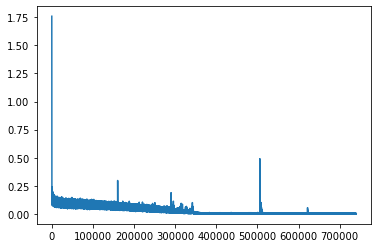

 12%|█▏        | 1215/10000 [3:28:26<25:04:23, 10.27s/it]

Loss at 750000 = 0.00012889740173704922


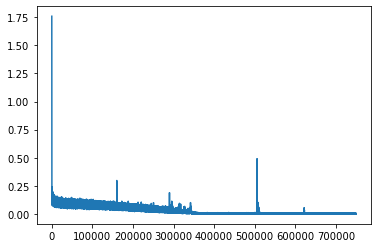

 12%|█▏        | 1231/10000 [3:31:11<25:02:48, 10.28s/it]

Loss at 760000 = 0.00021758968068752438


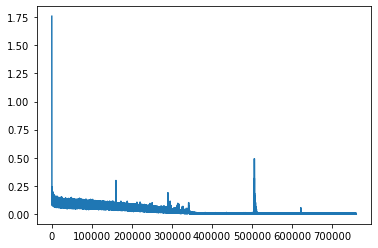

 12%|█▏        | 1247/10000 [3:33:56<24:56:08, 10.26s/it]

Loss at 770000 = 0.00014393262972589582


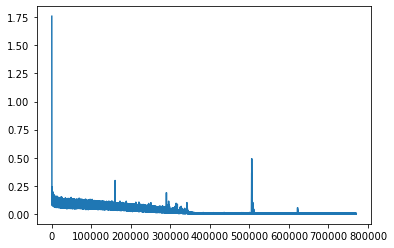

 13%|█▎        | 1264/10000 [3:36:51<24:56:38, 10.28s/it]

Loss at 780000 = 9.962361218640581e-05


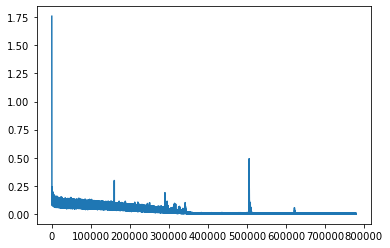

 13%|█▎        | 1280/10000 [3:39:36<25:00:14, 10.32s/it]

Loss at 790000 = 0.00012948903895448893


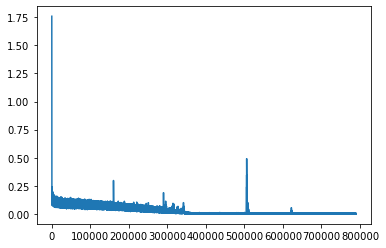

 13%|█▎        | 1296/10000 [3:42:22<24:53:47, 10.30s/it]

Loss at 800000 = 0.00011010257003363222


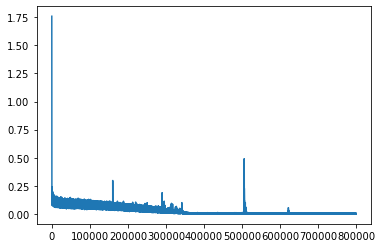

 13%|█▎        | 1312/10000 [3:45:07<24:47:44, 10.27s/it]

Loss at 810000 = 9.934903937391937e-05


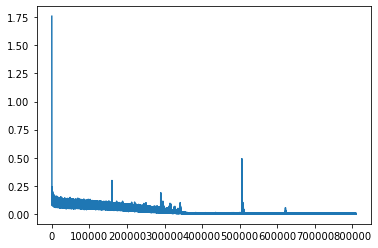

 13%|█▎        | 1329/10000 [3:48:02<24:54:34, 10.34s/it]

Loss at 820000 = 0.00017733148706611246


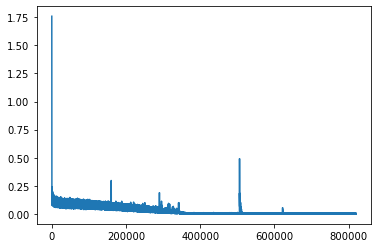

 13%|█▎        | 1345/10000 [3:50:47<24:44:53, 10.29s/it]

Loss at 830000 = 0.00011990927305305377


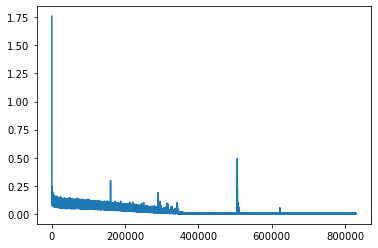

 14%|█▎        | 1361/10000 [3:53:33<25:02:22, 10.43s/it]

Loss at 840000 = 0.00013969991414342076


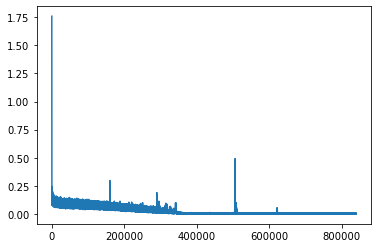

 14%|█▍        | 1377/10000 [3:56:19<24:59:01, 10.43s/it]

Loss at 850000 = 0.00013005938671994954


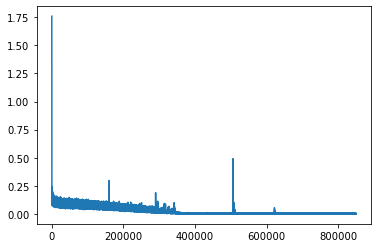

 14%|█▍        | 1393/10000 [3:59:12<25:48:35, 10.80s/it]

Loss at 860000 = 0.00013707559264730662


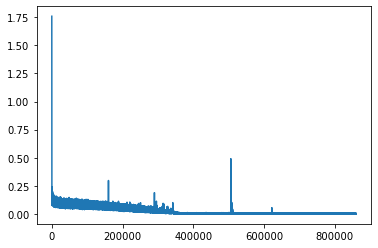

 14%|█▍        | 1410/10000 [4:02:09<24:40:24, 10.34s/it]

Loss at 870000 = 0.00015372358029708266


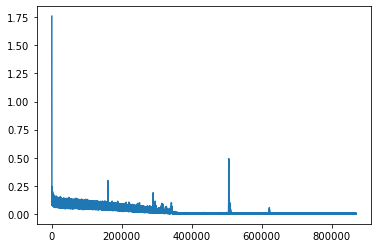

 14%|█▍        | 1426/10000 [4:04:55<24:27:57, 10.27s/it]

Loss at 880000 = 0.00012948510993737727


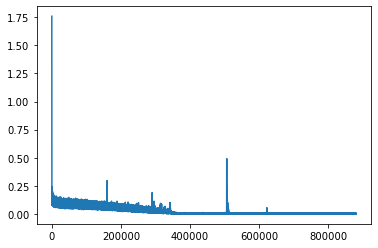

 14%|█▍        | 1442/10000 [4:07:40<24:24:05, 10.26s/it]

Loss at 890000 = 7.110329897841439e-05


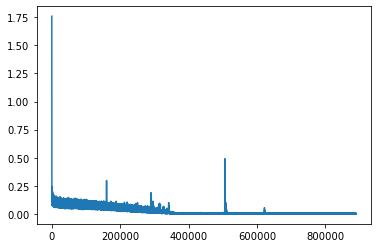

 15%|█▍        | 1458/10000 [4:10:25<24:38:12, 10.38s/it]

Loss at 900000 = 0.00010539427603362128


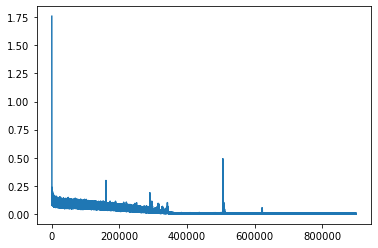

 15%|█▍        | 1474/10000 [4:13:11<24:30:28, 10.35s/it]

Loss at 910000 = 6.756996299372986e-05


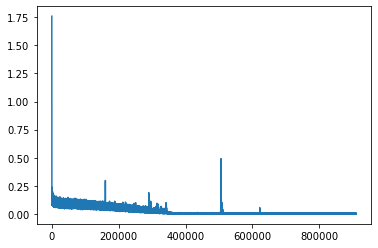

 15%|█▍        | 1491/10000 [4:16:07<24:18:55, 10.29s/it]

Loss at 920000 = 0.00014110063784755766


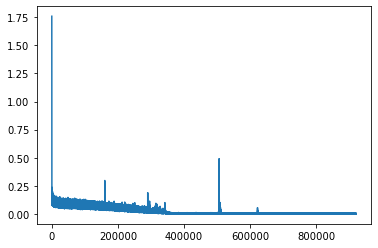

 15%|█▌        | 1507/10000 [4:18:52<24:22:00, 10.33s/it]

Loss at 930000 = 0.00010542049130890518


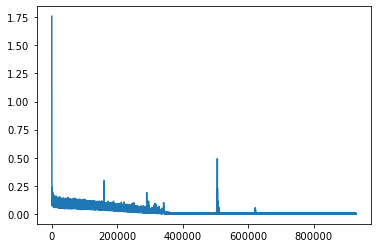

 15%|█▌        | 1523/10000 [4:21:38<24:22:53, 10.35s/it]

Loss at 940000 = 0.0001150972384493798


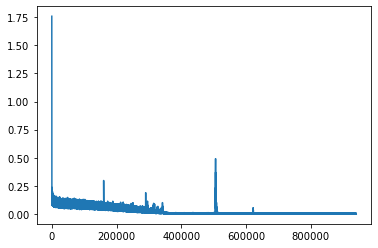

 15%|█▌        | 1539/10000 [4:24:23<24:22:20, 10.37s/it]

Loss at 950000 = 9.446588956052437e-05


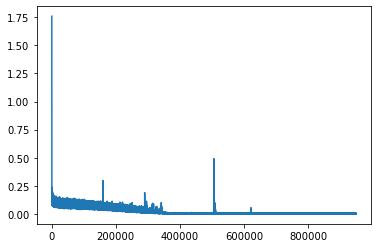

 16%|█▌        | 1555/10000 [4:27:09<24:12:05, 10.32s/it]

Loss at 960000 = 0.00014805732644163072


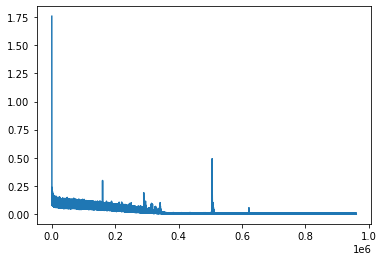

 16%|█▌        | 1572/10000 [4:30:05<24:08:44, 10.31s/it]

Loss at 970000 = 0.00011908908345503733


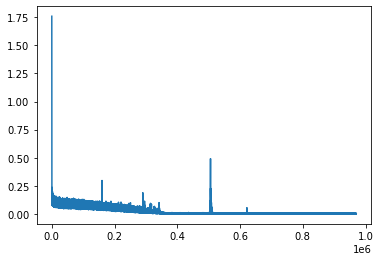

 16%|█▌        | 1588/10000 [4:32:52<24:19:09, 10.41s/it]

Loss at 980000 = 6.495892012026161e-05


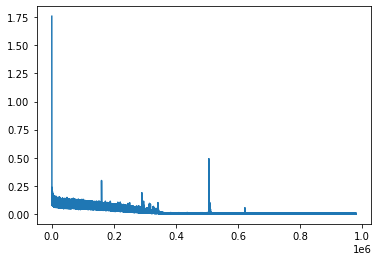

 16%|█▌        | 1604/10000 [4:35:37<24:02:08, 10.31s/it]

Loss at 990000 = 0.00010873939754674211


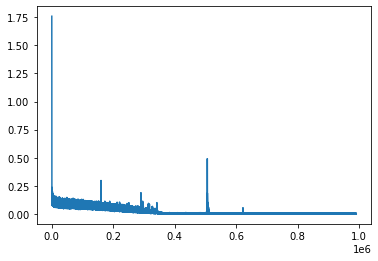

 16%|█▌        | 1620/10000 [4:38:23<24:02:35, 10.33s/it]

Loss at 1000000 = 0.0001160434476332739


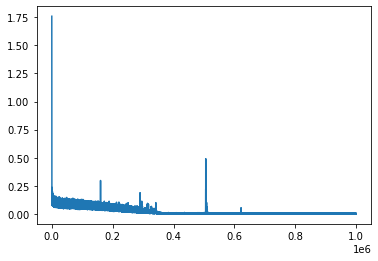

 16%|█▋        | 1636/10000 [4:41:09<24:15:10, 10.44s/it]

Loss at 1010000 = 0.00015908297791611403


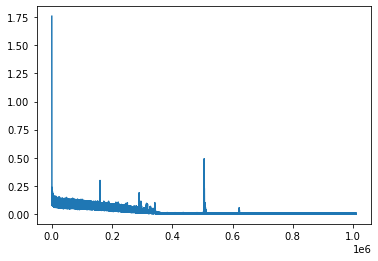

 17%|█▋        | 1653/10000 [4:44:05<23:59:12, 10.35s/it]

Loss at 1020000 = 6.357893289532512e-05


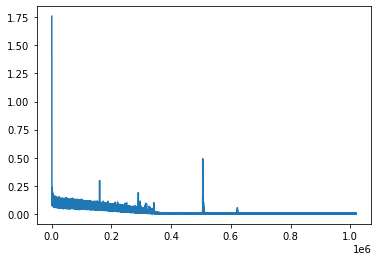

 17%|█▋        | 1669/10000 [4:46:51<23:59:54, 10.37s/it]

Loss at 1030000 = 0.00014233734691515565


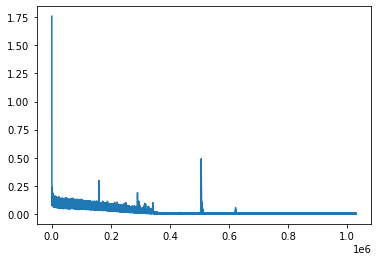

 17%|█▋        | 1685/10000 [4:49:37<23:56:53, 10.37s/it]

Loss at 1040000 = 6.532632687594742e-05


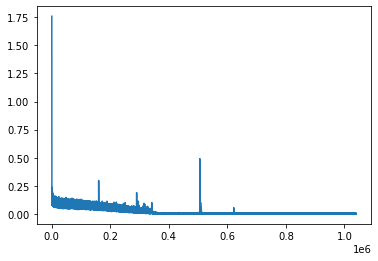

 17%|█▋        | 1701/10000 [4:52:23<23:58:27, 10.40s/it]

Loss at 1050000 = 7.073963934089988e-05


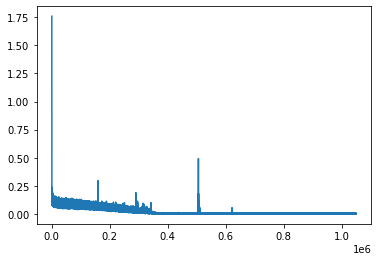

 17%|█▋        | 1717/10000 [4:55:09<23:54:36, 10.39s/it]

Loss at 1060000 = 5.429611337604001e-05


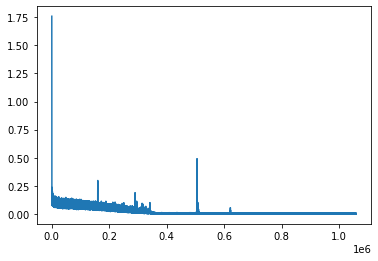

 17%|█▋        | 1734/10000 [4:58:06<23:56:02, 10.42s/it]

Loss at 1070000 = 0.000150574094732292


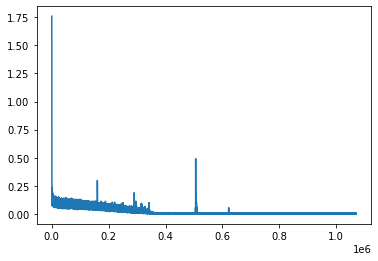

 18%|█▊        | 1750/10000 [5:00:52<23:45:03, 10.36s/it]

Loss at 1080000 = 6.0463451518444344e-05


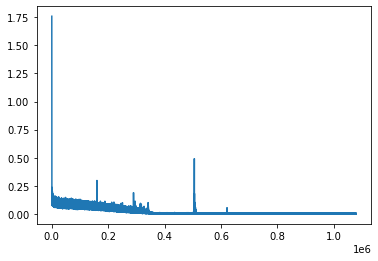

 18%|█▊        | 1766/10000 [5:03:39<23:43:54, 10.38s/it]

Loss at 1090000 = 6.855429819552228e-05


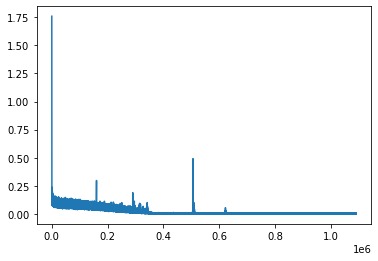

 18%|█▊        | 1782/10000 [5:06:24<23:49:56, 10.44s/it]

Loss at 1100000 = 0.00014656927669420838


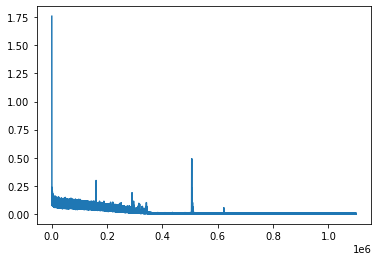

 18%|█▊        | 1799/10000 [5:09:21<23:56:37, 10.51s/it]

Loss at 1110000 = 4.701628495240584e-05


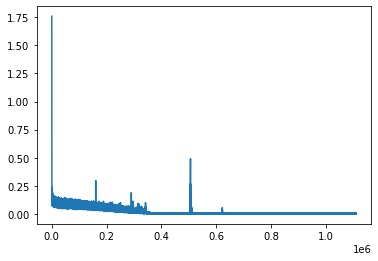

 18%|█▊        | 1815/10000 [5:12:08<23:42:00, 10.42s/it]

Loss at 1120000 = 4.953805546392687e-05


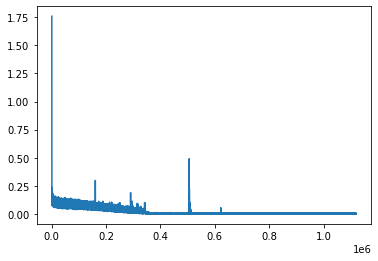

 18%|█▊        | 1831/10000 [5:14:55<23:35:52, 10.40s/it]

Loss at 1130000 = 7.213361095637083e-05


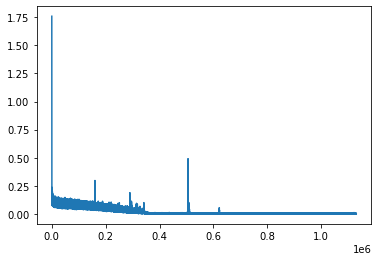

 18%|█▊        | 1847/10000 [5:17:42<23:33:54, 10.41s/it]

Loss at 1140000 = 6.140518235042691e-05


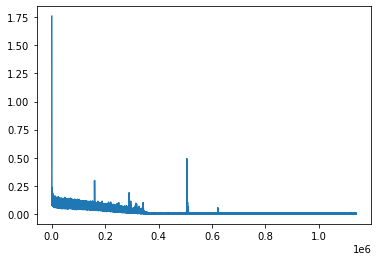

 19%|█▊        | 1863/10000 [5:20:29<23:27:57, 10.38s/it]

Loss at 1150000 = 5.603485624305904e-05


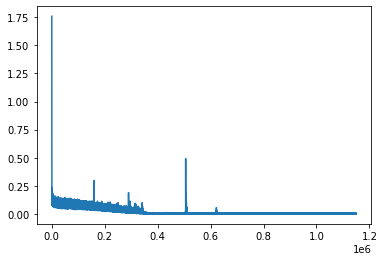

 19%|█▉        | 1880/10000 [5:23:26<23:30:42, 10.42s/it]

Loss at 1160000 = 0.00010518010094529018


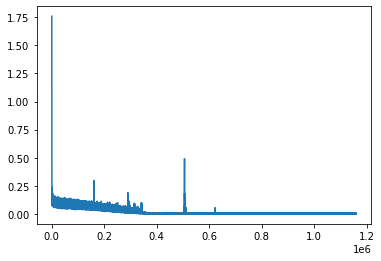

 19%|█▉        | 1896/10000 [5:26:15<24:30:02, 10.88s/it]

Loss at 1170000 = 4.13234083680436e-05


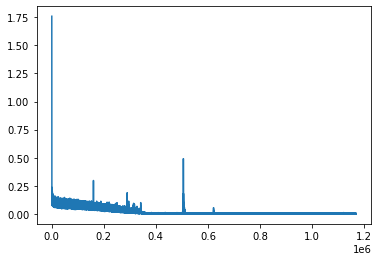

In [33]:
C_fake = train(Classifier().cuda(), np.concatenate((X_train, fake_X_train)), np.concatenate((y_train, fake_y_train)), epochs=10000)

The augmented classifier seems to work at least as well as the original one. This is encouraging for using GANs as a data augmentation strategy in a weakly-supervised hyperspectral image classification context.

In [ ]:
test(C_fake, X_test, y_test)

(40695, 103)
(40695,)
             precision    recall  f1-score   support

          1     0.9407    0.9483    0.9445      6310
          2     0.9679    0.9771    0.9725     17716
          3     0.8349    0.7912    0.8125      2007
          4     0.9688    0.9433    0.9558      2926
          5     0.9953    0.9961    0.9957      1276
          6     0.9204    0.9137    0.9170      4795
          7     0.8902    0.8594    0.8745      1273
          8     0.8625    0.8743    0.8684      3501
          9     0.9989    0.9888    0.9938       891

avg / total     0.9416    0.9419    0.9417     40695



array([8, 1, 1, ..., 2, 2, 2])